In [1]:
import pandas as pd
from catomatic.BinaryCatalogue import BinaryBuilder
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from protocols import utils
import os
import math
import pandas as pd
import numpy as np
import piezo
import multiprocessing as mp
from collections import defaultdict
import matplotlib.colors as mcolors
from matplotlib import cm as c_map

import warnings
from pathlib import Path
import json
import seaborn as sns
import itertools

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'Helvetica'  
plt.rcParams['font.size'] =7 
plt.rcParams['figure.figsize'] = (6.69, 5.02)

warnings.simplefilter("ignore", category=DeprecationWarning)
%load_ext autoreload
%autoreload 2

# Intro

This notebook aims to build, optimise, and compare catomatic and WHO catalogues on various datasets. It contains the following sections:
- Data preperation functions
- Build and predict workflow demo with rifampicin
- Parameter grid search with catomatic built on crypticv3
- Performance comparisons:
    - catomatic_v1 vs whov1 on crypticv1
    - catomatic_v1 vs whov1 vs catomatic_v3 vs whov2 on crypticv3
- Catalgoue discordance analysis:
    - catomatic_v1 vs whov1
    - catomatic_v3 vs whov2

catomatic versions (v1/v3) simply indicate the cryptic dataset they were built on.

Important functions are defined here, the rest are imported from protocols/utils.py

# Data Prep Functions

In [2]:
def prep_phenotypes(drug, pheno_path, genomes_path, samples_path, version, validation=False):
    #import phenotypes and samples and genoms
    phenotypes = utils.read_data(pheno_path).reset_index()
    genomes = utils.read_data(genomes_path).reset_index()
    samples = utils.read_data(samples_path).reset_index()

    if version == 'v1.0':
        matched = samples[(samples.in_final_tables)&(samples.dataset=='CRyPTIC-v1.0')].UNIQUEID.unique()
        phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]
    elif version == 'v2.0':
        matched = samples[(samples.in_final_tables)&(samples.dataset.isin(['CRyPTIC-v1.0', 'CRyPTIC-v2.0']))].UNIQUEID.unique()
        phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]
    elif version == 'v3.0':
        if validation:
            matched = samples[(samples.in_final_tables)&(samples.dataset=='CRyPTIC-v3.0')].UNIQUEID.unique()
            phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]
        else:
            matched = samples[(samples.in_final_tables)].UNIQUEID.unique()
            phenotypes = phenotypes[phenotypes.UNIQUEID.isin(matched)]

    #filter for drug
    phenotypes = phenotypes[phenotypes.DRUG==drug]
    #discoard low quality phenotypes
    phenotypes = phenotypes[phenotypes.PHENOTYPE.isin(['R', 'S'])]
    #handle duplicates (keep R if R, otherwise first)
    phenotypes = phenotypes.groupby("UNIQUEID", group_keys=False).apply(utils.filter_multiple_phenos).reset_index(drop=True)
    # filter relevant columns for catomatic and rename id column
    phenotypes = phenotypes[['UNIQUEID', 'DRUG', 'PHENOTYPE', 'METHOD_MIC', 'METHOD_3']]
    return phenotypes

drug_genes = {
    "AMI": ["eis", "rrs"],
    "CAP": ["rrs", "tlyA"],
    "CIP": ["gyrA"],
    "DLM": ["ddn"],
    "EMB": ["embA", "embB"],
    "ETH": ["ethA", "fabG1", "inhA"],
    "INH": ["katG", "inhA", "ahpC", "fabG1"],
    "KAN": ["eis", "rrs"],
    "LEV": ["gyrA", "gyrB"],
    "LZD": ["rplC"],
    "MXF": ["gyrA", "gyrB"],
    "RIF": ["rpoB"],
    "STM": ["gid", "rpsL", "rrs"]
}

def prep_mutations(path, genes, version, mut_path, var_path, train=True):
    #Uses most up to date mutations table, as this should contain all genomes from previous versions
    mut_dir = f"{path}{'_'.join(genes)}_MUTATIONS.csv"
    var_dir = f"{path}{'_'.join(genes)}_VARIANTS.csv"
    if not os.path.exists(mut_dir):
        mutations = utils.read_data(mut_path).reset_index()
        variants = utils.read_data(var_path).reset_index()
        mutations[mutations.GENE.isin(genes)].to_csv(mut_dir)
        variants[variants.GENE.isin(genes)].to_csv(var_dir)

    mutations = pd.read_csv(mut_dir, low_memory=False)
    variants = pd.read_csv(var_dir, low_memory=False)

    if version == 'v1':
        variants['FRS'] = variants.apply(lambda row: 1 if row['IS_FILTER_PASS'] is True else row['COVERAGE'] / row['DP'], axis=1)
        mutations = pd.merge(mutations, variants[['UNIQUEID', 'GENE', 'POSITION', 'FRS']], on=['UNIQUEID', 'GENE', 'POSITION'], how='left')
        mutations = mutations[~mutations.IS_NULL]

    elif version == 'v3.0.0':
        variants["FRS"] = variants.apply(lambda row: row["MINOR_READS"] / row["COVERAGE"] if row["MINOR_READS"] > 0 else 1, axis=1) 
        mutations = pd.merge(mutations, variants[['UNIQUEID', 'GENE', 'GENE_POSITION', 'FRS']], on=['UNIQUEID', 'GENE', 'GENE_POSITION'], how='left')
        mutations = mutations[~mutations.IS_NULL]
        mutations['MUTATION'] = mutations.apply(
        lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR'] else x['MUTATION']}",
        axis=1,
        )
    elif version == 'v3.1.0':
        #recalcaulte FRS from variants table to be 100% sure
        variants["FRS"] = variants.apply(lambda row: row["MINOR_READS"] / row["COVERAGE"] if row["MINOR_READS"] > 0 else 1, axis=1) 
        mutations = mutations.drop(columns=['FRS'])
        mutations = pd.merge(mutations, variants[['UNIQUEID', 'GENE', 'GENE_POSITION', 'FRS']], on=['UNIQUEID', 'GENE', 'GENE_POSITION'], how='left')
        mutations = mutations[~mutations.IS_NULL]
        mutations['MUTATION'] = mutations.apply(
        lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR'] else x['MUTATION']}",
        axis=1,
        )


    #flag synonymous mutations
    mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1])
    #filter out synonymous mutations
    if train:
        #if validating, would keep synonymous mutations
        mutations = mutations[~mutations.IS_SYNONYMOUS]
    #drop duplicate entries 
    mutations = mutations.drop_duplicates(['UNIQUEID', 'MUTATION', 'FRS'], keep='first')
    # filter relevant columns for catomatic and rename id column
    mutations = mutations[['UNIQUEID', 'MUTATION', 'FRS']].rename(columns={'ENA_RUN': 'UNIQUEID'})
    return mutations




# Catalogue Construction workflow

The following functions are used to import the data tables, and prepare them for catomatic for a particular drug and defined set of candidate genes.

In [3]:
phenotypes = prep_phenotypes('RIF', 'data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl', 'data/cryptic-tables-v3.1.0/GENOMES.parquet',  'data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet', version='v1.0')
phenotypes

UNIQUEID DRUG PHENOTYPE METHOD_MIC  \
0      site.00.subj.1000347.lab.H111540004.iso.1  RIF         R        NaN   
1      site.00.subj.1000595.lab.H123460044.iso.1  RIF         R        NaN   
2      site.00.subj.1004213.lab.H111060034.iso.1  RIF         R        NaN   
3      site.00.subj.1004213.lab.H112000008.iso.1  RIF         R        NaN   
4      site.00.subj.1004213.lab.H113100007.iso.1  RIF         R        NaN   
...                                          ...  ...       ...        ...   
35707     site.ENA.subj.SAMN08215478.lab.1.iso.1  RIF         R        NaN   
35708     site.ENA.subj.SAMN08215479.lab.1.iso.1  RIF         S        NaN   
35709     site.ENA.subj.SAMN08215480.lab.1.iso.1  RIF         S        NaN   
35710     site.ENA.subj.SAMN08215481.lab.1.iso.1  RIF         S        NaN   
35711     site.ENA.subj.SAMN08215482.lab.1.iso.1  RIF         S        NaN   

               METHOD_3  
0      resistance ratio  
1      resistance ratio  
2      resistance ratio  
3      resistance ratio  
4      resistance ratio  
...                 ...  
35707           MGIT960  
35708           MGIT960  
35709           MGIT960  
35710           MGIT960  
35711           MGIT960  

[35712 rows x 5 columns]

In [4]:
mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes["RIF"], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet')
mutations

UNIQUEID    MUTATION       FRS
0                     site.02.subj.0069.lab.22A019.iso.1  rpoB@S450L  1.000000
4      site.03.subj.6236-05_LIB12062.lab.6236-05_LIB1...  rpoB@S450L  1.000000
5                    site.04.subj.00255.lab.709124.iso.1  rpoB@S450L  1.000000
8           site.06.subj.RLH_0305-14.lab.06MIL0297.iso.1  rpoB@c-61t  1.000000
9           site.06.subj.RLH_0305-14.lab.06MIL0297.iso.1  rpoB@S450L  1.000000
...                                                  ...         ...       ...
76711               site.ENA.subj.SRR6824487.lab.1.iso.1  rpoB@L430P  1.000000
76713               site.ENA.subj.SRR6824487.lab.1.iso.1  rpoB@C701W  0.665236
76714               site.ENA.subj.SRR5551664.lab.1.iso.1  rpoB@S450L  1.000000
76716               site.ENA.subj.ERR7911708.lab.1.iso.1  rpoB@S450L  1.000000
76717               site.ENA.subj.ERR7911708.lab.1.iso.1  rpoB@T400A  0.262500

[30335 rows x 3 columns]

## Build a catalogue for rifampicin

In [5]:
catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=0.1).build(test='Binomial', background=0.2, strict_unlock=True, p=0.95)
catalogue_df = catalogue.build_piezo(genbank_ref='NC00962.3', catalogue_name='rif_demo', version='0.0', drug='RIF', wildcards="./data/wildcards/rif_wildcards.json", json_dumps=True)
catalogue_df.to_csv('./catalogues/temp/demo_rif_catalogue.csv')
catalogue_df

GENBANK_REFERENCE CATALOGUE_NAME CATALOGUE_VERSION CATALOGUE_GRAMMAR  \
0           NC00962.3       rif_demo               0.0             GARC1   
1           NC00962.3       rif_demo               0.0             GARC1   
2           NC00962.3       rif_demo               0.0             GARC1   
3           NC00962.3       rif_demo               0.0             GARC1   
4           NC00962.3       rif_demo               0.0             GARC1   
..                ...            ...               ...               ...   
408         NC00962.3       rif_demo               0.0             GARC1   
409         NC00962.3       rif_demo               0.0             GARC1   
410         NC00962.3       rif_demo               0.0             GARC1   
411         NC00962.3       rif_demo               0.0             GARC1   
412         NC00962.3       rif_demo               0.0             GARC1   

    PREDICTION_VALUES DRUG              MUTATION PREDICTION SOURCE  \
0                 RUS  RIF            rpoB@c-61t          S     {}   
1                 RUS  RIF  rpoB@2546_ins_cgagga          S     {}   
2                 RUS  RIF            rpoB@E250G          S     {}   
3                 RUS  RIF            rpoB@L449Q          S     {}   
4                 RUS  RIF            rpoB@V695L          S     {}   
..                ...  ...                   ...        ...    ...   
408               RUS  RIF         rpoB@-*_indel          U     {}   
409               RUS  RIF          rpoB@*_indel          U     {}   
410               RUS  RIF              rpoB@-*?          U     {}   
411               RUS  RIF               rpoB@*?          U     {}   
412               RUS  RIF          rpoB@del_0.0          U     {}   

                                              EVIDENCE OTHER  
0    {"proportion": 0.007196162046908316, "confiden...    {}  
1    {"proportion": 0.0, "confidence": [0.0, 0.0687...    {}  
2    {"proportion": 0.043010752688172046, "confiden...    {}  
3    {"proportion": 0.0, "confidence": [0.0, 0.0770...    {}  
4    {"proportion": 0.056338028169014086, "confiden...    {}  
..                                                 ...   ...  
408                           {"default_rule": "True"}    {}  
409                           {"default_rule": "True"}    {}  
410                           {"default_rule": "True"}    {}  
411                           {"default_rule": "True"}    {}  
412                           {"default_rule": "True"}    {}  

[413 rows x 11 columns]

In [6]:
catalogue_df.PREDICTION.value_counts()

PREDICTION
U    360
R     41
S     12
Name: count, dtype: int64

### Use the catalogue to predict phenotypes


Now that we have built a catalogue for rifampicin, we can apply a simple prediction algorithm to test its senstivity for predicting resistance.

We can do this on the same dataset used to build the catalogues, but crucially, we also have a totally independent validation set.

[[ 9997   380   252]
 [  380 23767   936]]
Catalogue coverage of isolates: 0.9667338709677419
Sensitivity: 0.9633805531463814
Specificity: 0.984263055452023


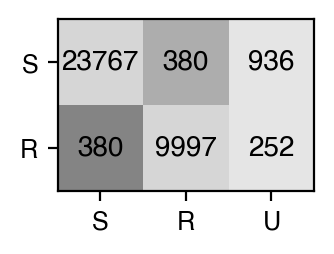

In [7]:
#test performance on training set

all = pd.merge(phenotypes, mutations[mutations.FRS>=0.1], on=['UNIQUEID'], how='left')
#note, this merge assumes the phenotypes df only contains samples that have been genotyped
cmatrix = utils.piezo_predict(iso_df=all, drug='RIF', catalogue_file='./catalogues/temp/demo_rif_catalogue.csv', U_to_S=False, Print=True)[0]
cmatrix= pd.DataFrame(cmatrix, index=["R", "S"], columns=["R", "S", 'U'])

utils.plot_truthtables(cmatrix, U_to_S=False, colors=["#666666", "#cccccc", "#999999", "#cccccc","#cccccc","#cccccc" ])

# Parameter Grid search

Build catalogues for all drugs on crypticv1 via a grid search, and choose the optimal parameters and 'flagship' catalogues.

Parameters are background and p-value.

Also investigate the effect of FRS on these chosen catalogues.

#### Background and p value

In [8]:
# Function to process one combination of drug, background, and p-value
def process_grid_search(args):
    drug, genes, mutations_dir, phenotypes_path, genomes_path, samples_path, mut_path, var_path, catfile_dir, FRS, background, p, geno_version, pheno_version = args

    results = {}

    mutations = prep_mutations(mutations_dir, genes, version=geno_version, mut_path=mut_path, var_path=var_path, train=True)
    test_mutations = prep_mutations(mutations_dir, genes, version=geno_version, mut_path=mut_path, var_path=var_path, train=False)
    phenotypes = prep_phenotypes(drug, phenotypes_path, genomes_path, samples_path , version=pheno_version)
    catfile = f"{catfile_dir}/{drug.lower()}/bg_{background}_p_{p}_FRS_{FRS}.csv"
    
    #if not os.path.exists(catfile):
    catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=FRS).build(test='Binomial', background=background, strict_unlock=True, p=p)
    catalogue.to_piezo(genbank_ref='NC00962.3', catalogue_name=f'{drug}-{background}-{p}', version='0.0', 
                        drug=drug, wildcards=f"./data/wildcards/{drug.lower()}_wildcards.json", json_dumps=True, outfile=catfile)

    all_data = pd.merge(phenotypes, test_mutations[test_mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
    cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all_data, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False)
    results[(drug, background, p)] = {"cm": cm, "cov": cov, "sens": sens, "spec": spec}

    return results

# Main function for parallel execution
def parallel_grid_search(mutations_dir, phenotypes_path, genomes_path, samples_path, mut_path, var_path, catfile_dir, FRS, geno_version, pheno_version, cores):
    grid_results = {}
    # Create list of tasks to parallelize
    tasks = []
    for drug, genes in drug_genes.items():
        for background in [0.05, 0.10, 0.15, 0.20, 0.25]:
            for p in [0.9, 0.95]:
                tasks.append((drug, genes, mutations_dir, phenotypes_path, genomes_path, samples_path, mut_path, var_path, catfile_dir, FRS, background, p, geno_version, pheno_version))

    ctx = mp.get_context("fork")  
    num_workers = min(cores, len(tasks))
    with ctx.Pool(num_workers) as pool:
        all_results = pool.map(process_grid_search, tasks)  # Run in parallel

    for result in all_results:
        grid_results.update(result)
    return grid_results


OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cap/bg_0.1_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v1/grid_search/cap/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/ami/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.1_p_0.95_FRS_0.1.csvOUTFILE
 catalogues/cryptic-v1/grid_search/dlm/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/ami/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/ami/bg_0.25_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.15_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cip/bg_0.2_p_0.95_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/dlm/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cap/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cap/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/ami/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/ami/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/eth/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/eth/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/ami/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cap/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cap/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/emb/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/emb/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v1/grid_search/cap/bg_0.15_p_0.95_

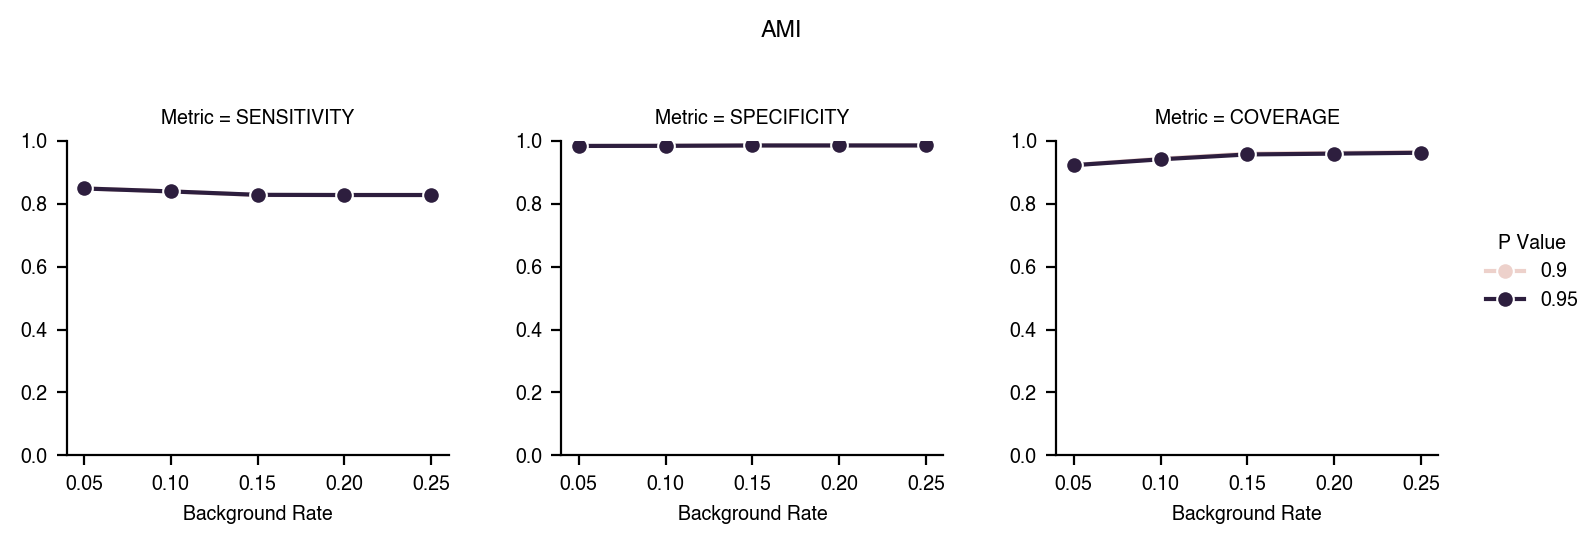

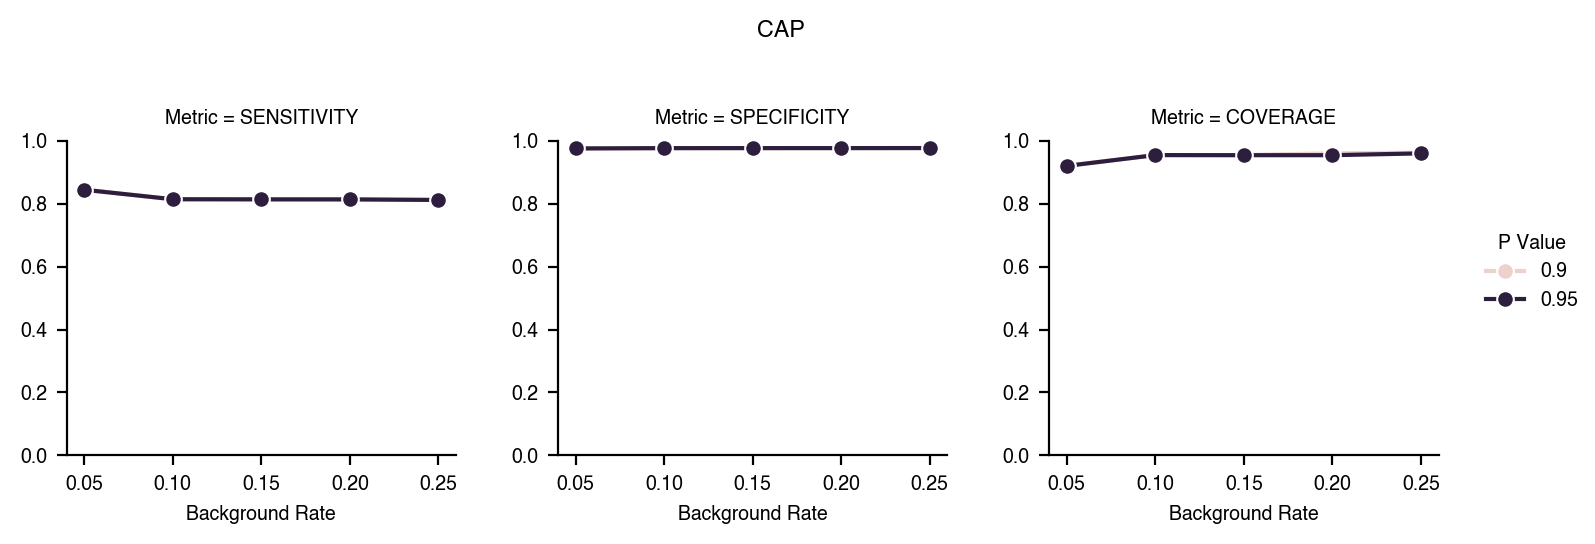

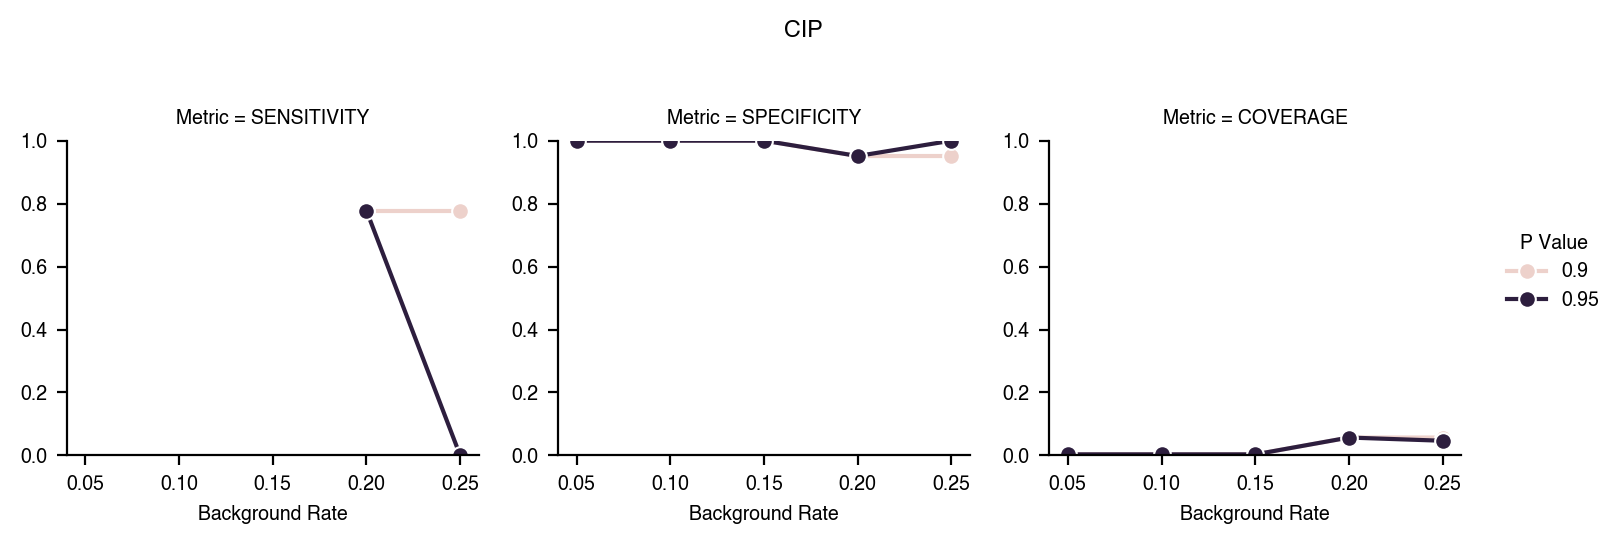

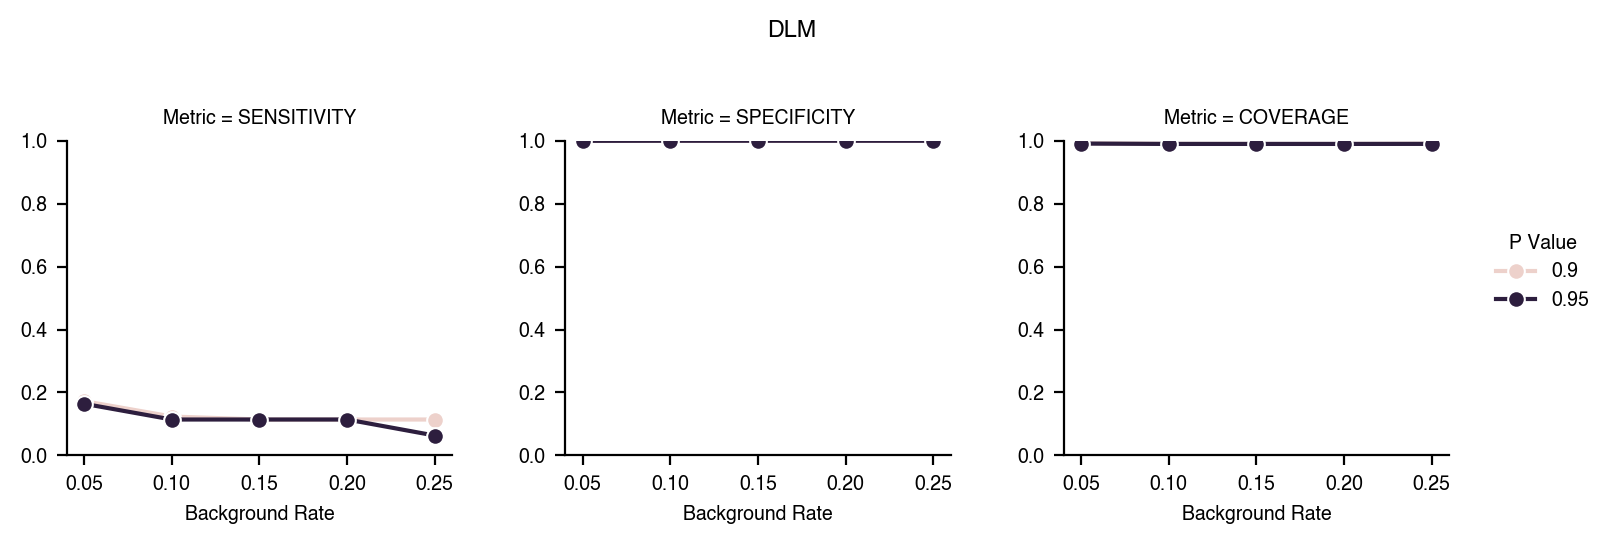

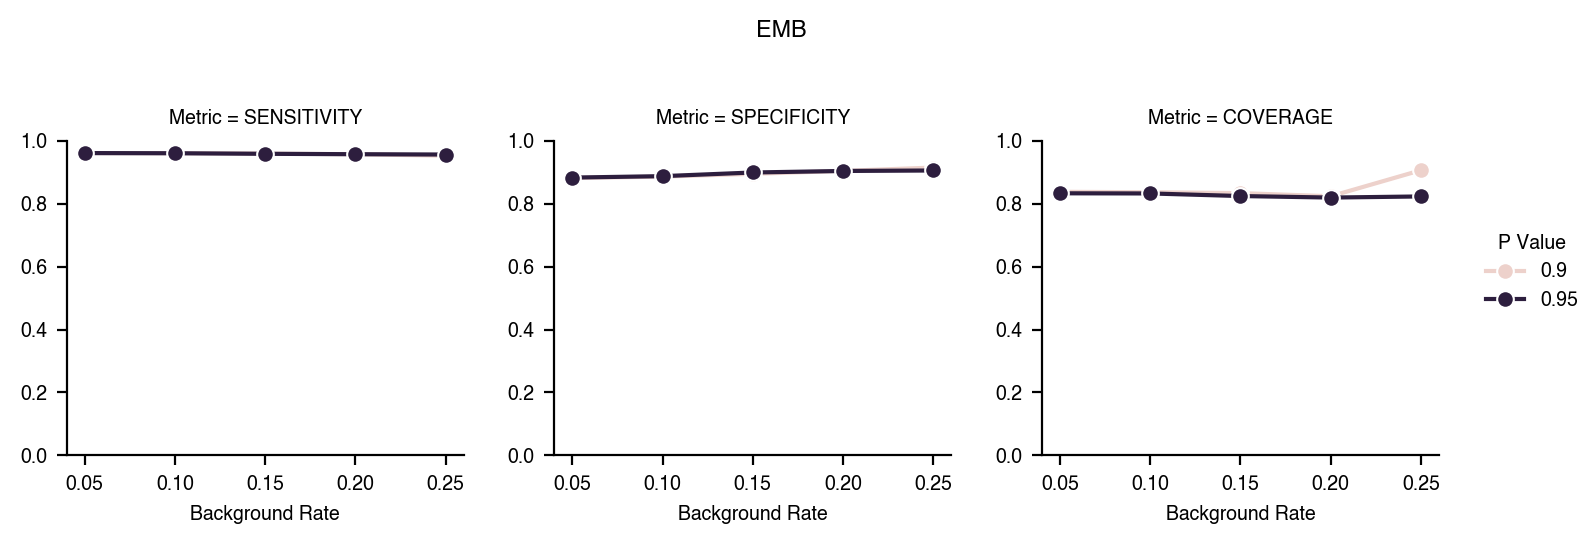

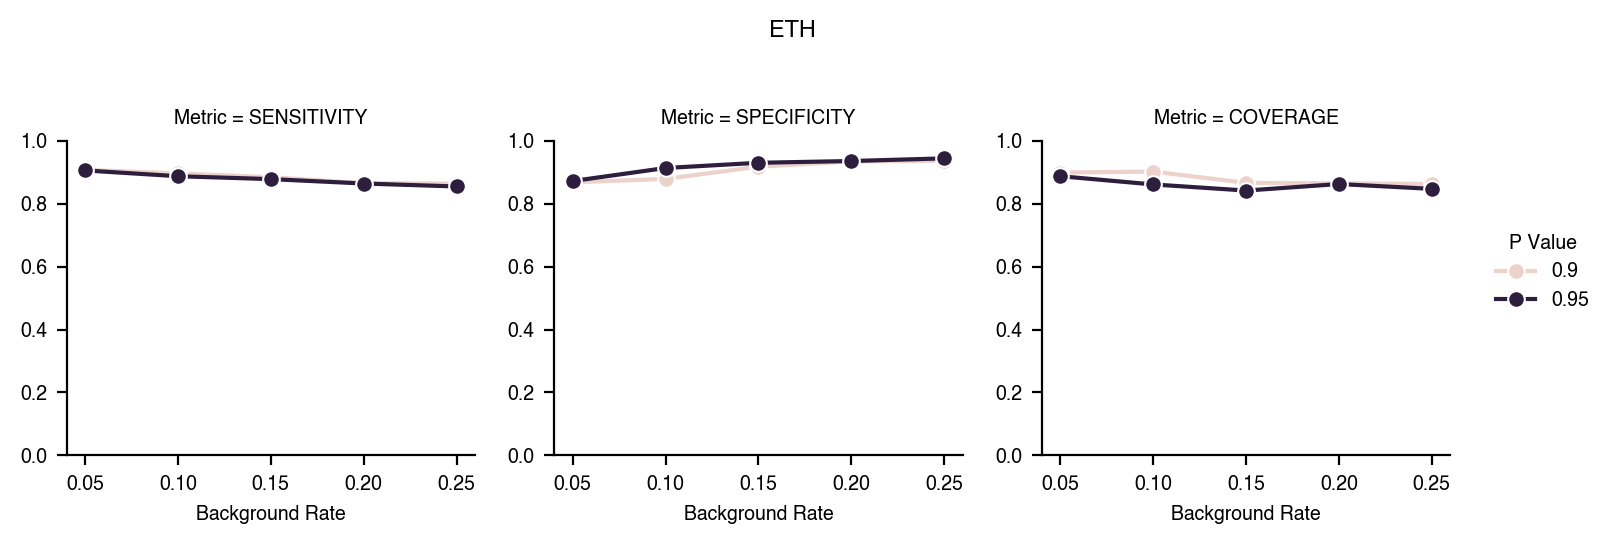

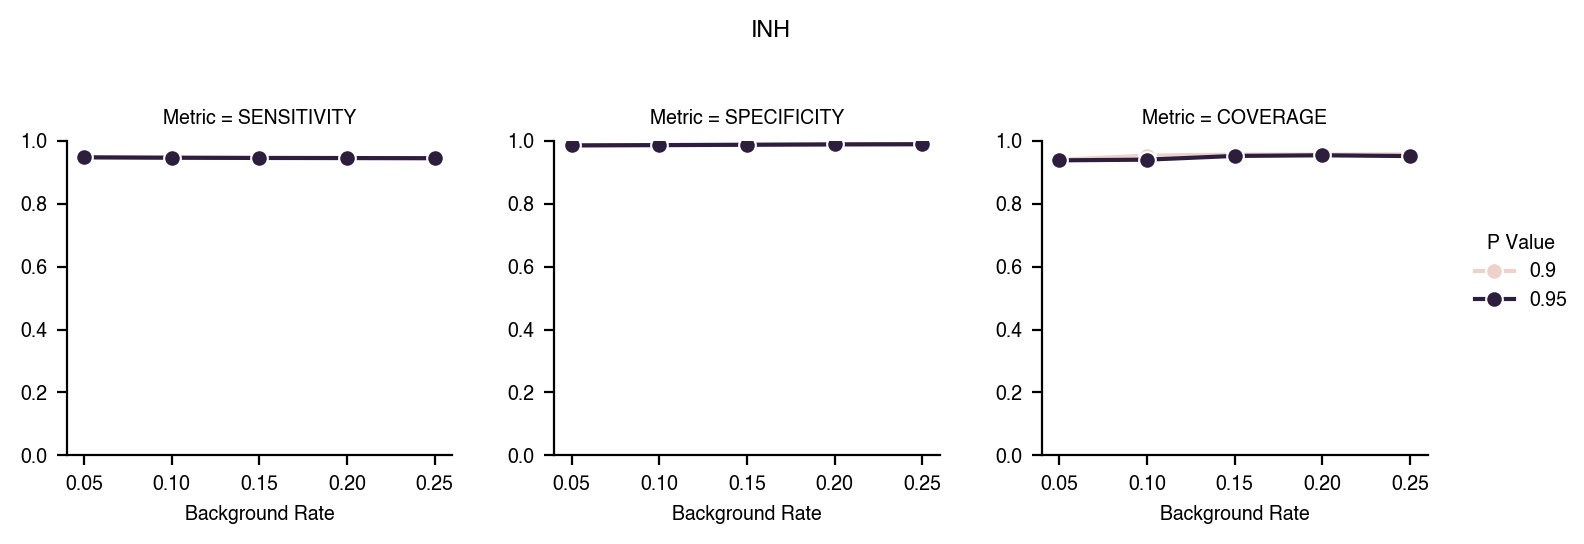

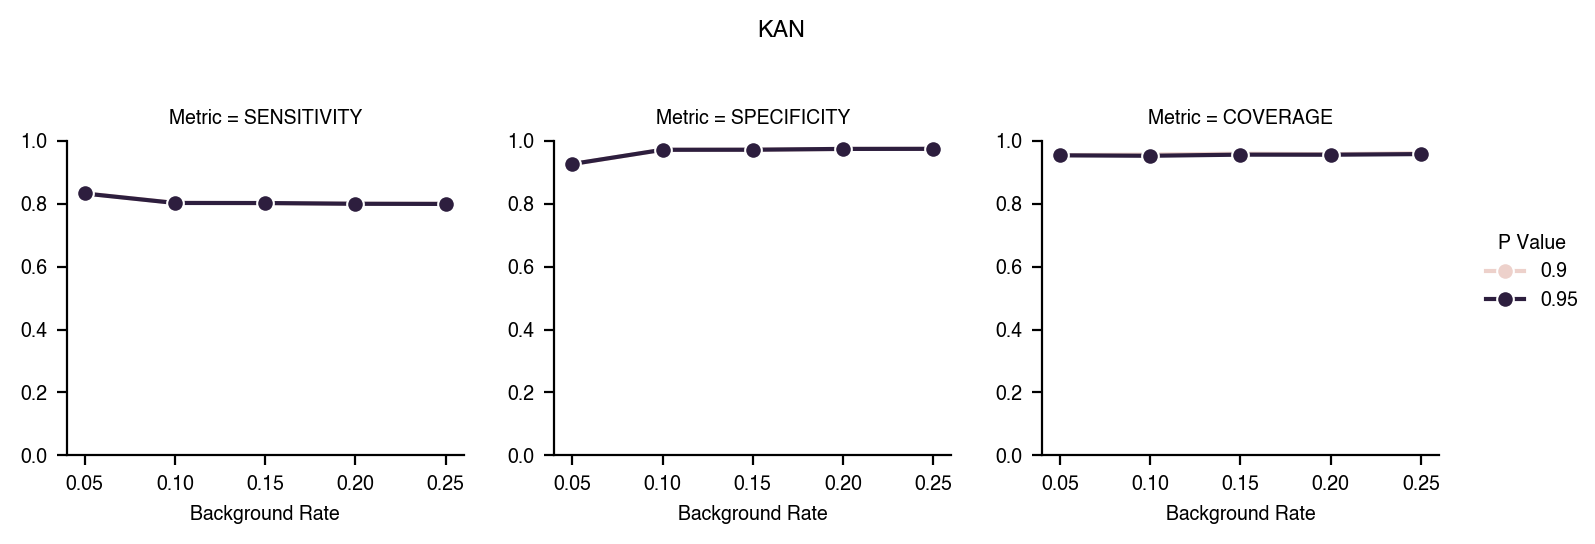

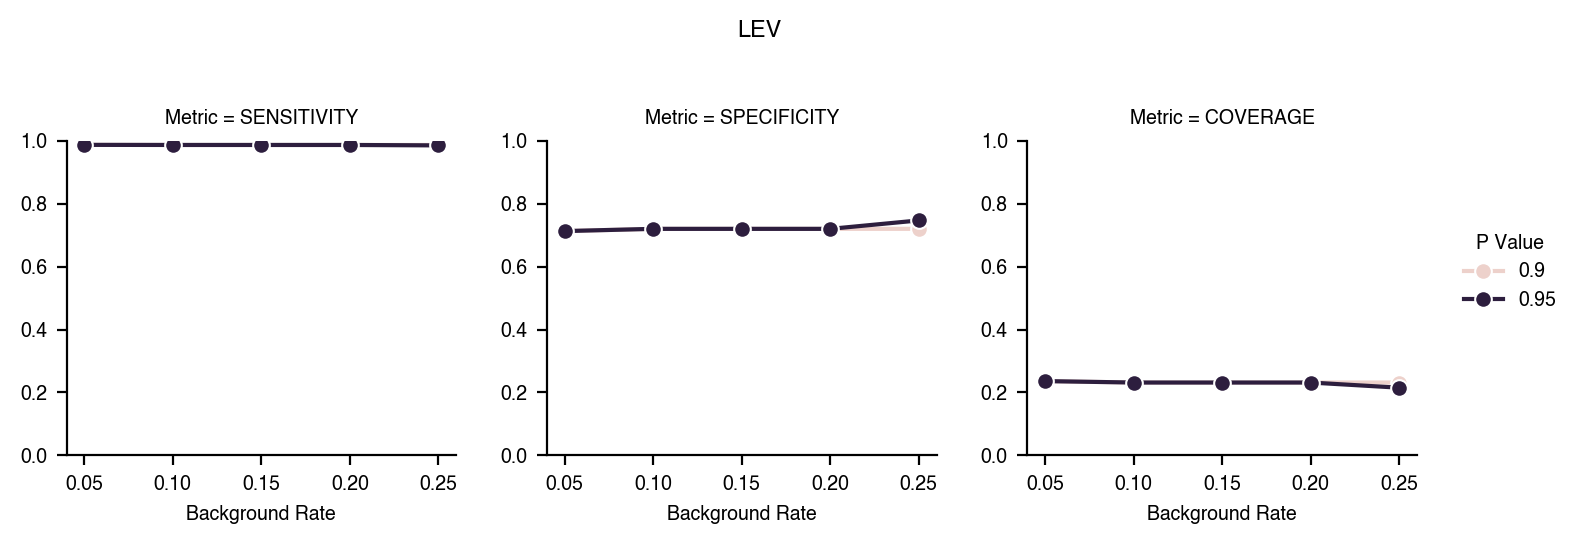

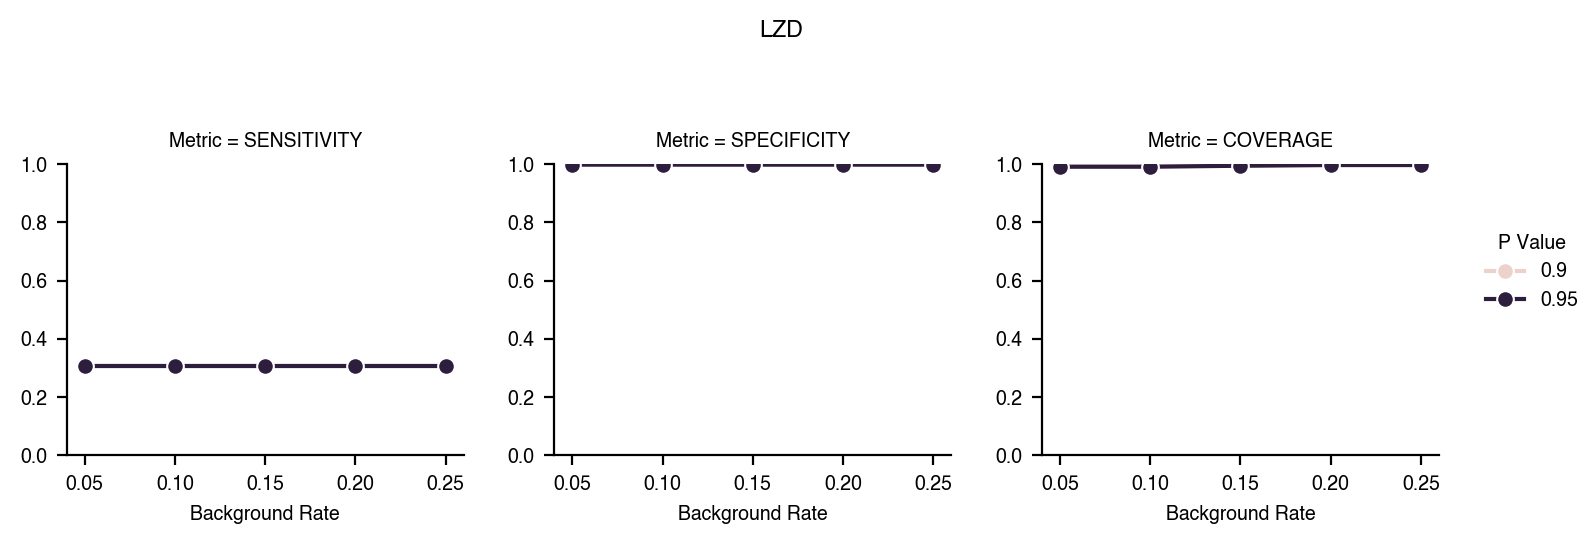

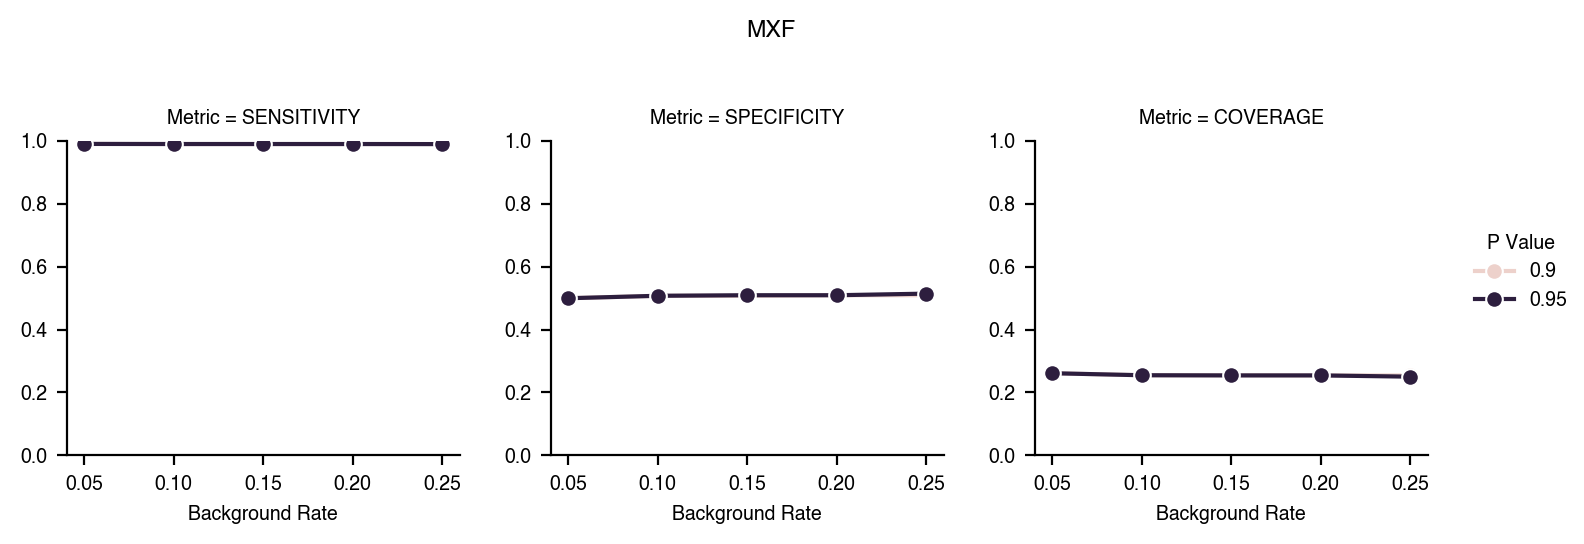

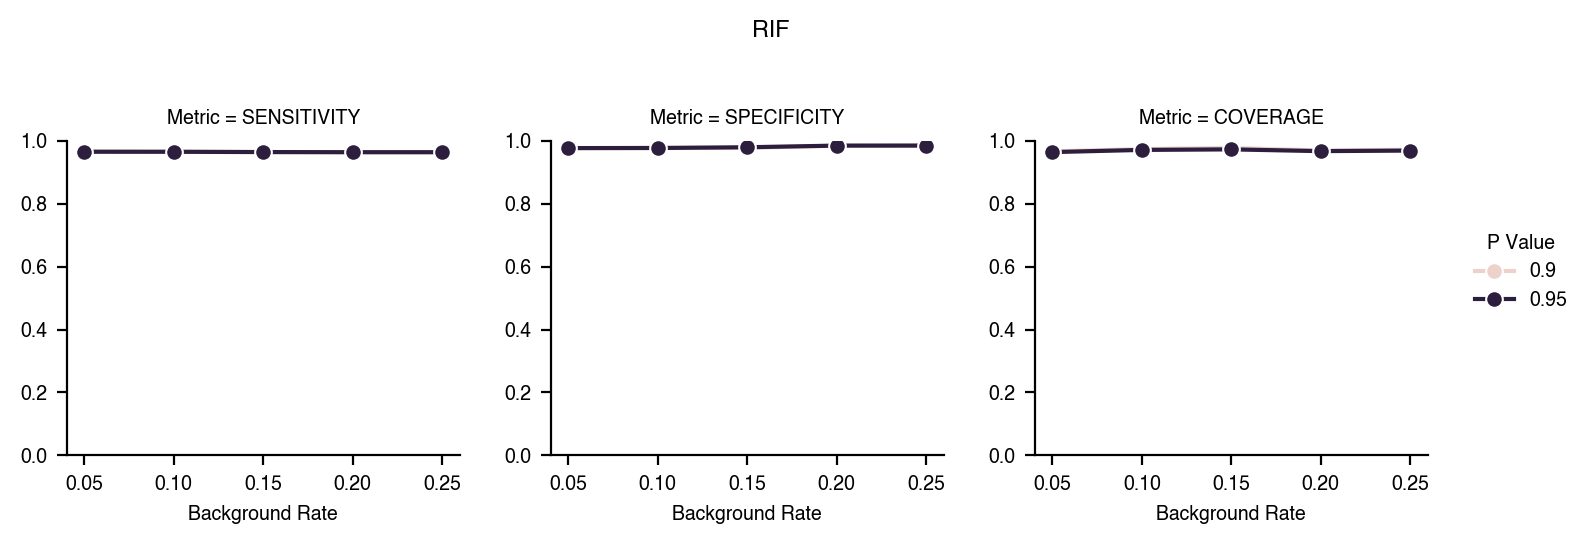

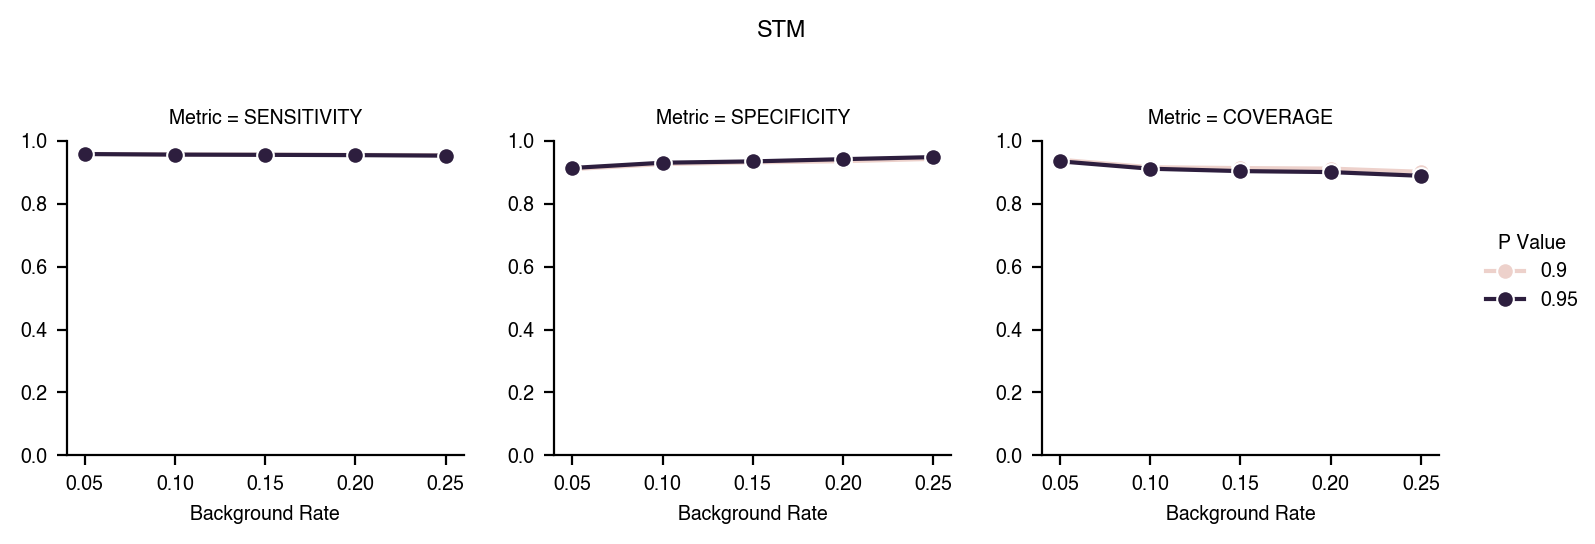

In [9]:
#run grid search on crypticv3 samples
grid_results = parallel_grid_search(
    "data/mutations-v3.1.0/",
    "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl",
    "data/cryptic-tables-v3.1.0/GENOMES.parquet",
    "data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet",
    "data/cryptic-tables-v3.1.0/MUTATIONS.parquet",
    "data/cryptic-tables-v3.1.0/VARIANTS.parquet",
    "catalogues/cryptic-v1/grid_search",
    0.1,
    'v3.1.0',
    'v1.0',
    cores=10 #best to run with 1 core when first generating mutations and variants tables, as mem requirements are steep!!
)

df = utils.flatten_grid_results(grid_results)

# Melt the DataFrame for plotting
melted_df = df.melt(
    id_vars=["DRUG", "BACKGROUND_RATE", "p_value"],
    value_vars=["SENSITIVITY", "SPECIFICITY", "COVERAGE"],
    var_name="Metric",
    value_name="Value",
)

for drug in melted_df["DRUG"].unique():
    drug_data = melted_df[melted_df["DRUG"] == drug]
    g = sns.FacetGrid(drug_data, col="Metric", col_wrap=3, sharey=False, height=2.5)
    g.map_dataframe(
        sns.lineplot, x="BACKGROUND_RATE", y="Value", hue="p_value", marker="o"
    )
    g.set_axis_labels("Background Rate", "")
    g.add_legend(title="P Value")
    g.figure.suptitle(drug, y=1.05)
    g.tight_layout()
    g.set(ylim=(0, 1)) 
    plt.savefig(f'figs/grid_search/{drug}.pdf')
    plt.show()

In [10]:
#determine best performing catalogue
opt_cats_v1 = utils.weighted_score(df).groupby("DRUG").head(1).reset_index(drop=True)
#pull out R, S, U counts from catalogue
cat_counts = pd.DataFrame([
    {
        "DRUG": opt_cats_v1['DRUG'][i],
        "R": cat["PREDICTION"].value_counts().get("R", 0),
        "S": cat["PREDICTION"].value_counts().get("S", 0),
        "U": cat["PREDICTION"].value_counts().get("U", 0),
        "Total": len(cat)
    }
    for i in opt_cats_v1.index
    for cat in [pd.read_csv(f"./catalogues/cryptic-v1/grid_search/{opt_cats_v1['DRUG'][i].lower()}/bg_{opt_cats_v1['BACKGROUND_RATE'][i]}_p_{opt_cats_v1['p_value'][i]}_FRS_0.1.csv")]
])

opt_cats_v1 = pd.merge(opt_cats_v1, cat_counts, on='DRUG')
opt_cats_v1['catalogue'] = 'catomatic_v1'
opt_cats_v1

DRUG  BACKGROUND_RATE  p_value  SENSITIVITY  SPECIFICITY  COVERAGE  \
0   RIF             0.25     0.90     0.963381     0.984365  0.971158   
1   INH             0.25     0.90     0.944363     0.988292  0.956400   
2   STM             0.20     0.90     0.954789     0.934732  0.911294   
3   EMB             0.25     0.90     0.952322     0.914556  0.906068   
4   AMI             0.05     0.90     0.848526     0.982960  0.922512   
5   CAP             0.05     0.90     0.844141     0.975157  0.920088   
6   ETH             0.05     0.90     0.907343     0.867731  0.898681   
7   KAN             0.05     0.90     0.832658     0.925637  0.953942   
8   LEV             0.25     0.95     0.985017     0.746639  0.215235   
9   MXF             0.25     0.95     0.989105     0.514035  0.250278   
10  CIP             0.25     0.90     0.777778     0.951220  0.056883   
11  LZD             0.20     0.95     0.306977     0.997886  0.996474   
12  DLM             0.05     0.90     0.172589     0.998996  0.991435   

       Score    R   S     U  Total     catalogue  
0   0.971232   41  25   347    413  catomatic_v1  
1   0.959949   60  23   617    700  catomatic_v1  
2   0.940073   89  12   509    610  catomatic_v1  
3   0.931741   17  53  1029   1099  catomatic_v1  
4   0.903654   14   8   387    409  catomatic_v1  
5   0.898635   43   4   232    279  catomatic_v1  
6   0.893727  295   4   358    657  catomatic_v1  
7   0.884808   23   6   357    386  catomatic_v1  
8   0.759547    5   3    80     88  catomatic_v1  
9   0.698819    6   3    88     97  catomatic_v1  
10  0.685631    2   2     6     10  catomatic_v1  
11  0.652149    1   5    37     43  catomatic_v1  
12  0.584280   17   1    49     67  catomatic_v1

#### Fraction Read Support

In [11]:
build_frs_values = np.arange(0.1, 1.0, 0.1)
test_frs_values = np.arange(0.1, 1.0, 0.1)

# Shared memory dictionaries for storing results
manager = mp.Manager()
sensitivity_matrix = manager.dict()
specificity_matrix = manager.dict()
coverage_matrix = manager.dict()

def process_drug_frs(drug):
    mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=True)
    test_mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=False)
    phenotypes = prep_phenotypes(
        drug,
        "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl",
        "data/cryptic-tables-v3.1.0/GENOMES.parquet",
        "data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet",
        'v1.0'
    )
    
    background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]
    sens_results, spec_results, cov_results = {}, {}, {}
    
    for build_FRS in build_frs_values:
        catfile = f"./catalogues/cryptic-v1/frs/{drug.lower()}/bg_{background}_p_{p}_FRS_{build_FRS}.csv"
        #if not os.path.exists(catfile):
        catalogue = BinaryBuilder(samples=phenotypes, mutations=mutations, FRS=build_FRS).build(
            test='Binomial', background=background, strict_unlock=True, p=p
        )
        catalogue.to_piezo(
            genbank_ref='NC00962.3',
            catalogue_name=f'{drug}-{background}-{p}-{np.round(build_FRS, 1)}',
            version='0.0',
            drug=drug,
            wildcards=f"./data/wildcards/{drug.lower()}_wildcards.json",
            json_dumps=True,
            outfile=catfile
        )
            
        sens_results[build_FRS], spec_results[build_FRS], cov_results[build_FRS] = {}, {}, {}
        
        for test_FRS in test_frs_values:
            all_data = pd.merge(
                phenotypes, 
                test_mutations[test_mutations.FRS >= test_FRS], 
                on=['UNIQUEID'], 
                how='left'
            )
            cm, cov, sens, spec, _, _ = utils.piezo_predict(
                iso_df=all_data, drug=drug, catalogue_file=catfile, U_to_S=False, Print=False
            )
            sens_results[build_FRS][test_FRS] = sens * 100
            spec_results[build_FRS][test_FRS] = spec * 100
            cov_results[build_FRS][test_FRS] = cov * 100
    
    sensitivity_matrix[drug] = sens_results
    specificity_matrix[drug] = spec_results
    coverage_matrix[drug] = cov_results

# Parallel execution
mp.set_start_method('fork', force=True)
with mp.Pool(mp.cpu_count() - 1) as pool:
    pool.map(process_drug_frs, opt_cats_v1['DRUG'])



OUTFILE ./catalogues/cryptic-v1/frs/lev/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/cap/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/kan/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/ami/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/eth/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/stm/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/rif/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/inh/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/emb/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE ./catalogues/cryptic-v1/frs/cap/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/kan/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/eth/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/ami/bg_0.05_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/stm/bg_0.2_p_0.9_FRS_0.2.csv
OUTFILE ./catalogues/cryptic-v1/frs/cap/bg_0.05_p_0.9_FRS_0.30000000000000004

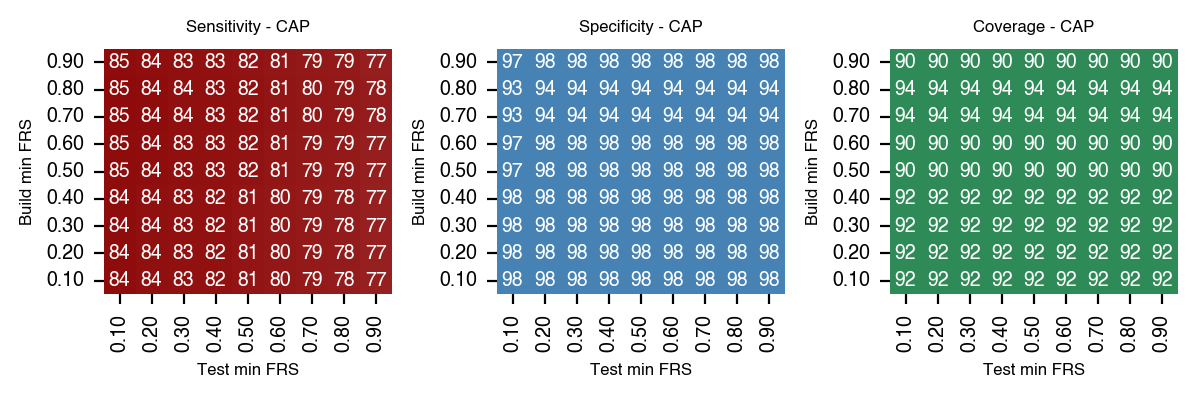

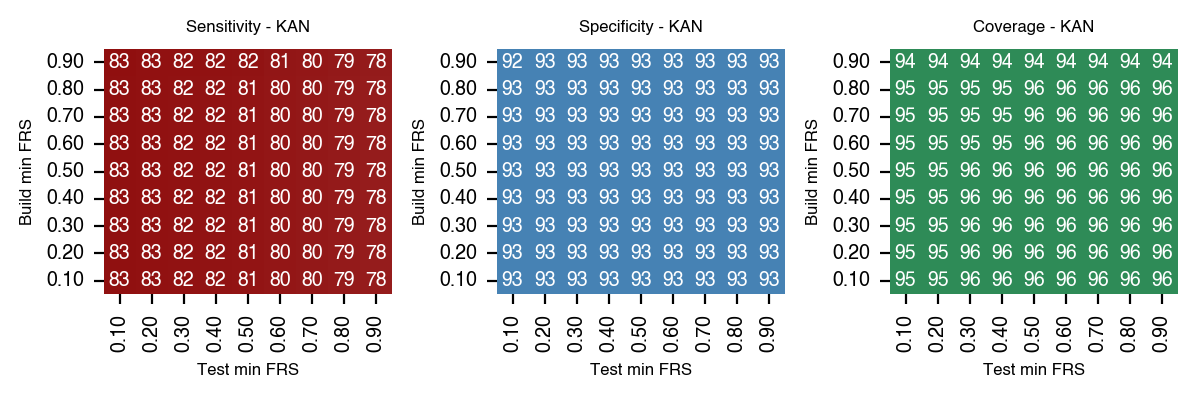

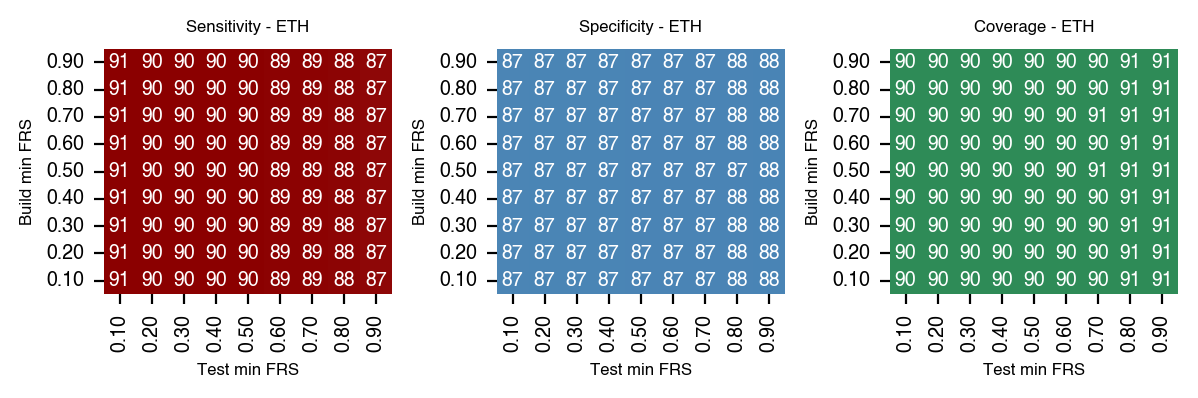

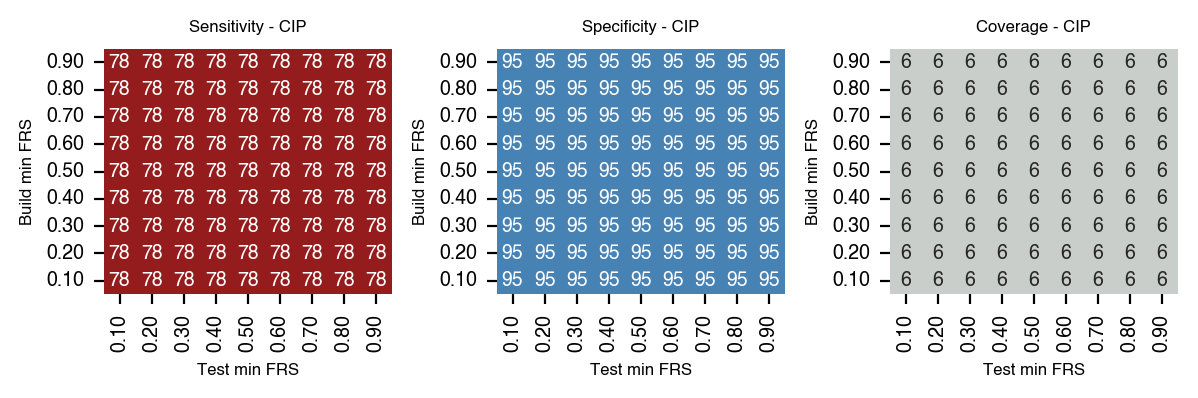

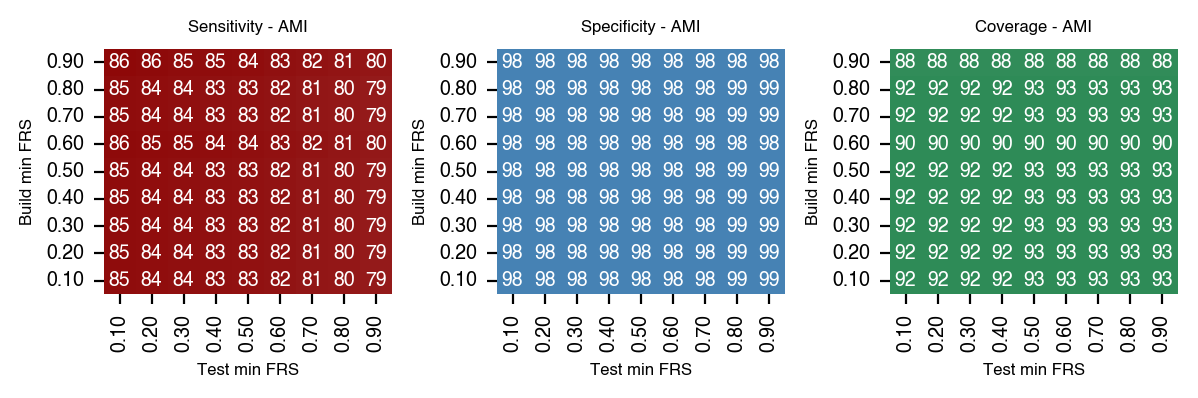

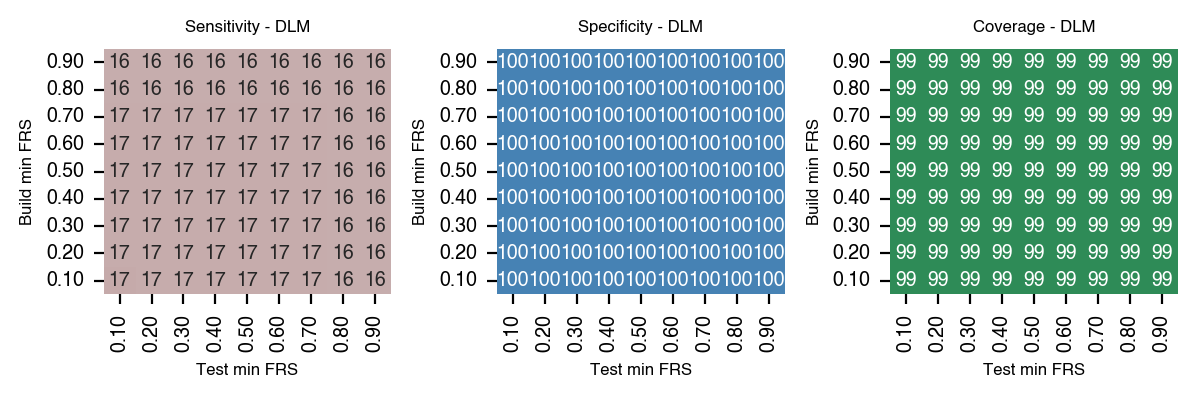

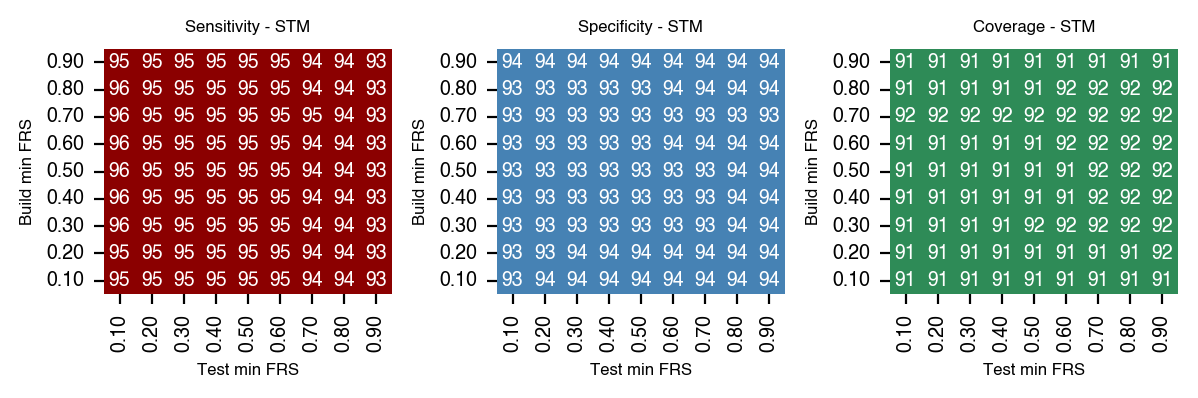

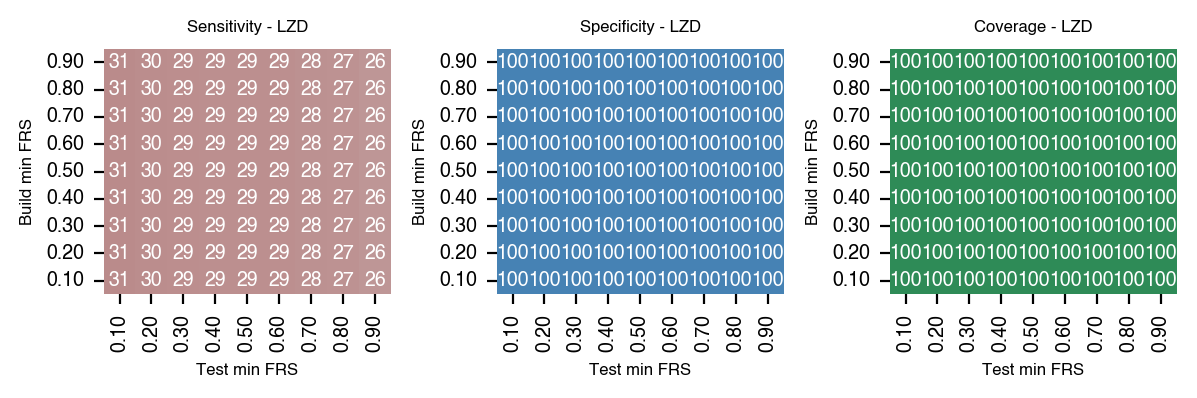

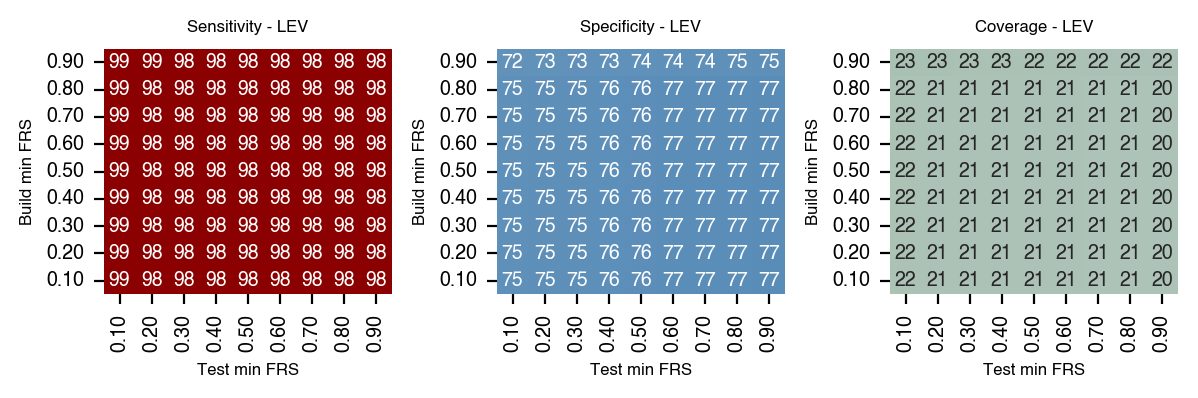

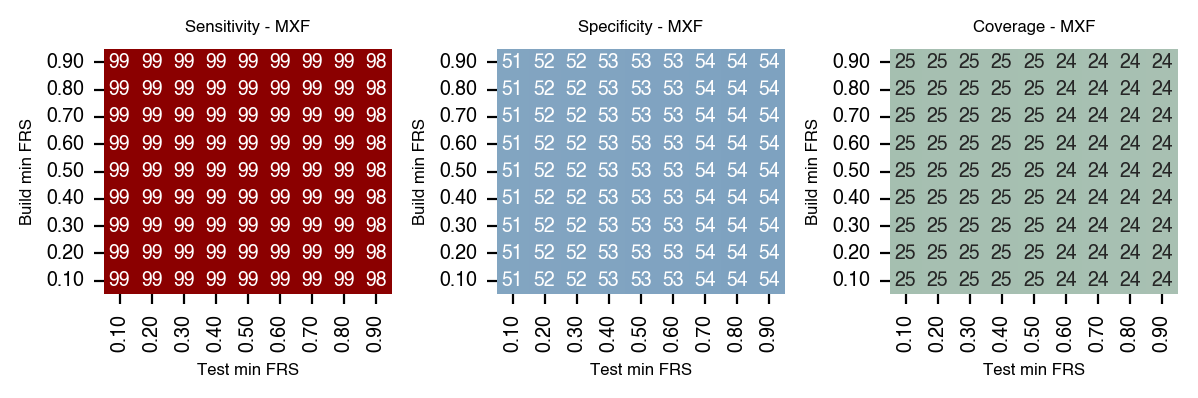

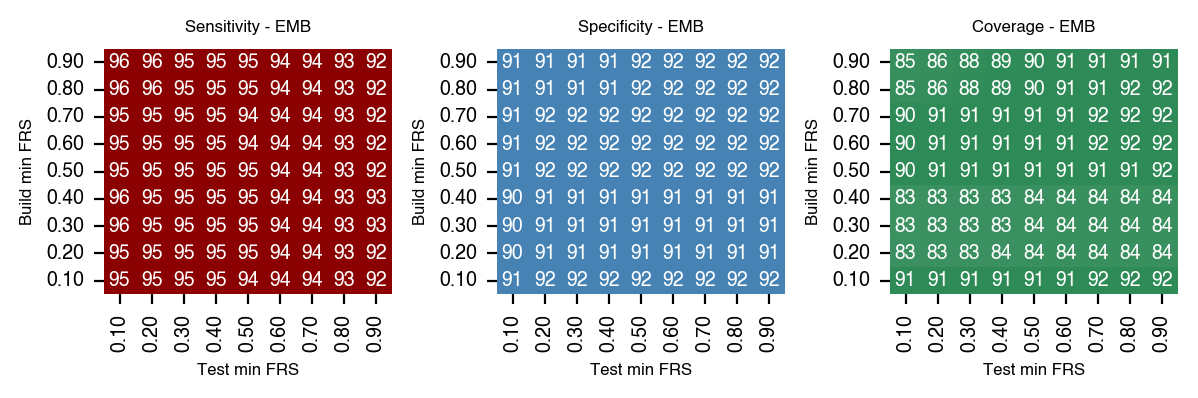

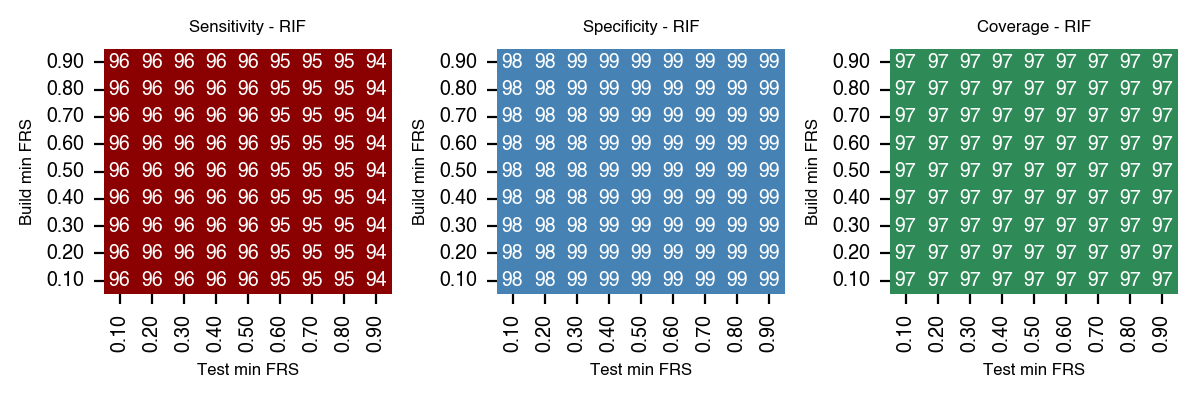

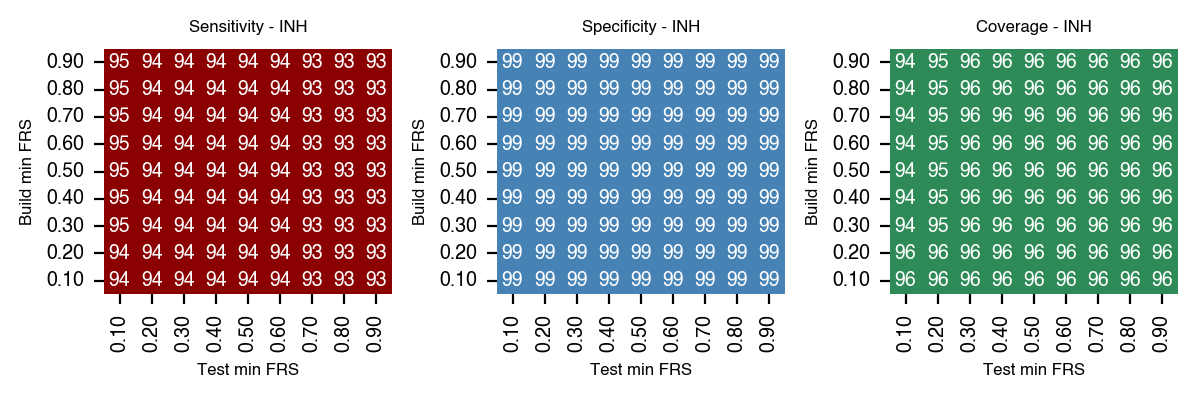

In [12]:
def convert_to_dataframe(matrix, metric):
    data = []
    
    for drug, builds in matrix.items():
        for build, tests in builds.items():
            for test, value in tests.items():
                data.append([drug, build, test, value])

    df = pd.DataFrame(data, columns=['Drug', 'Build_FRS', 'Test_FRS', metric])
    return df

sensitivity_df = convert_to_dataframe(sensitivity_matrix, 'Sensitivity')
specificity_df = convert_to_dataframe(specificity_matrix, 'Specificity')
coverage_df = convert_to_dataframe(coverage_matrix, 'Coverage')
perf_df = pd.merge(pd.merge(sensitivity_df, specificity_df, on=['Drug', 'Build_FRS', 'Test_FRS']), coverage_df, on=['Drug', 'Build_FRS', 'Test_FRS'])

utils.plot_perf_heatmaps(perf_df)

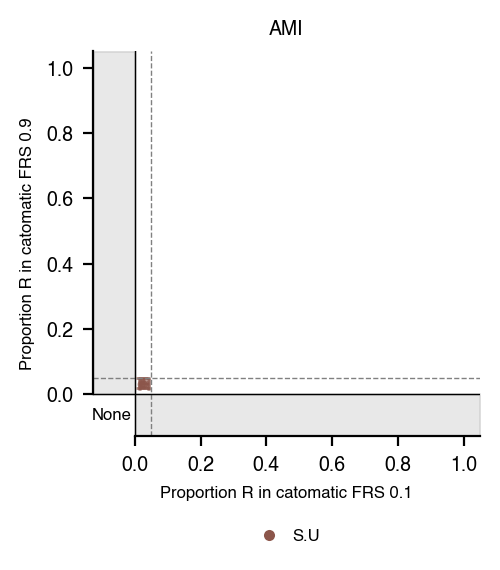

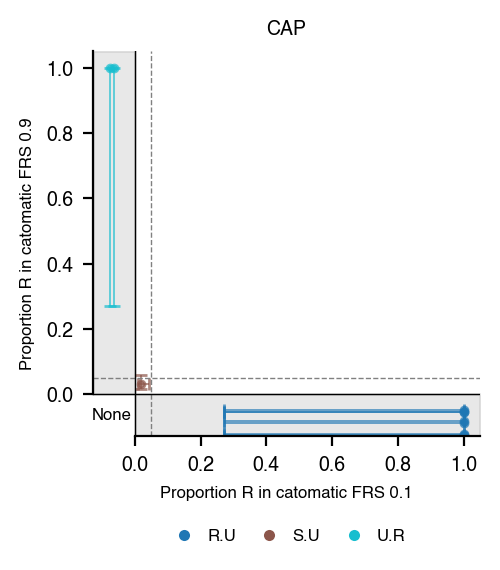

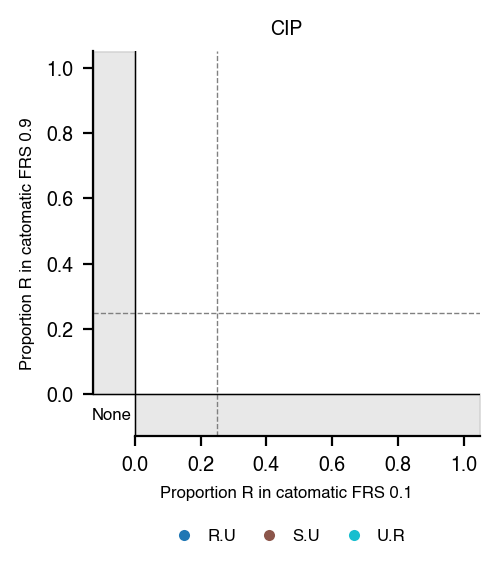

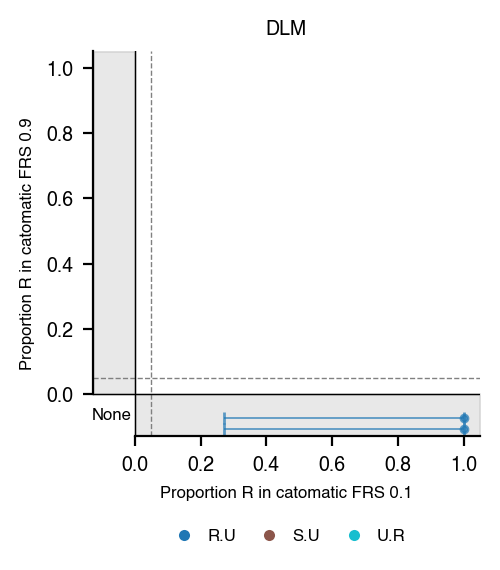

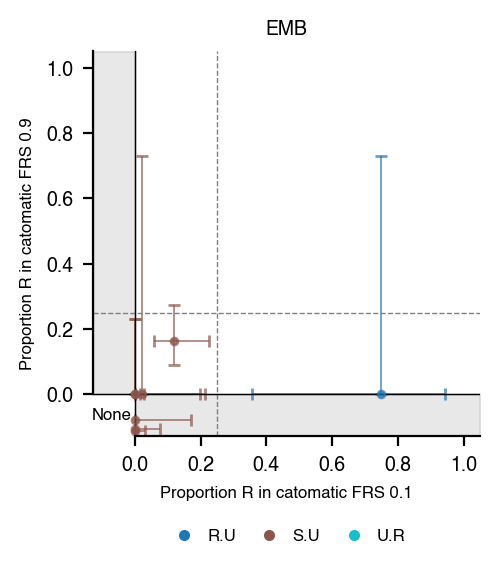

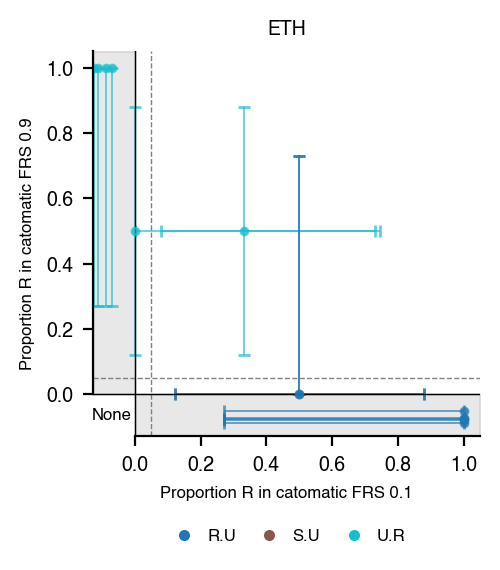

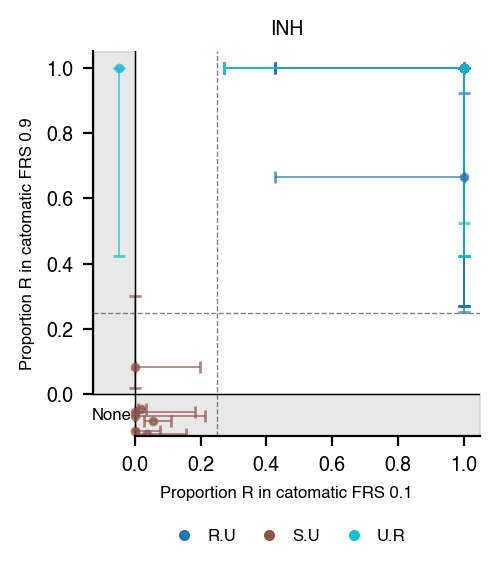

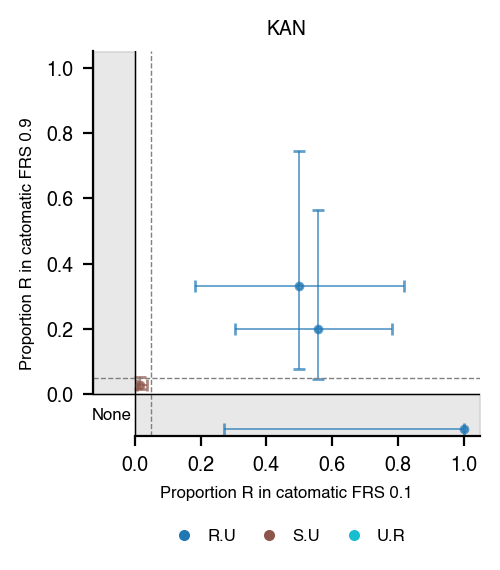

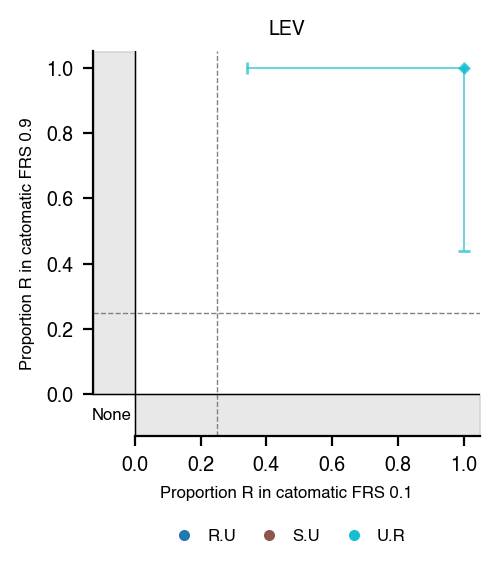

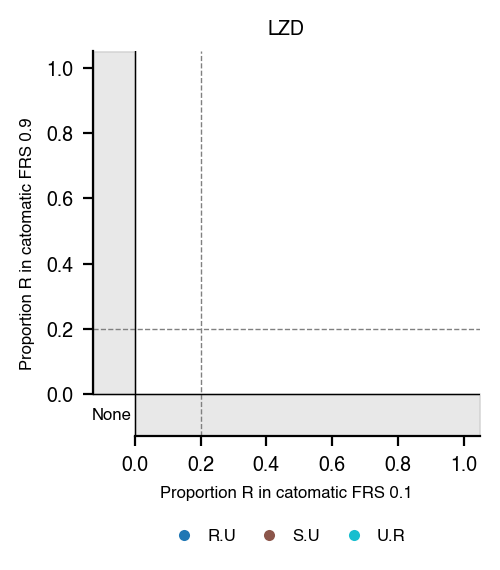

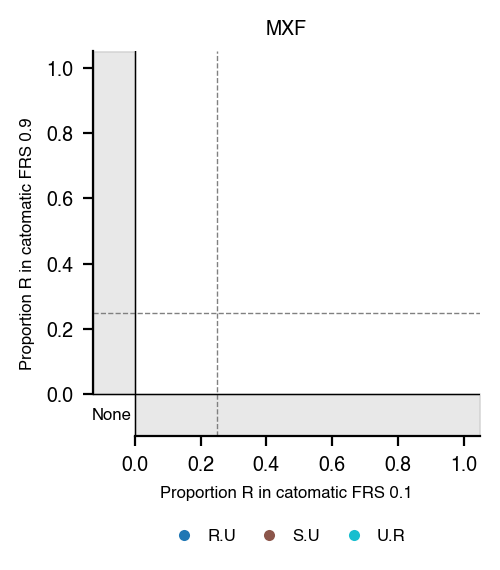

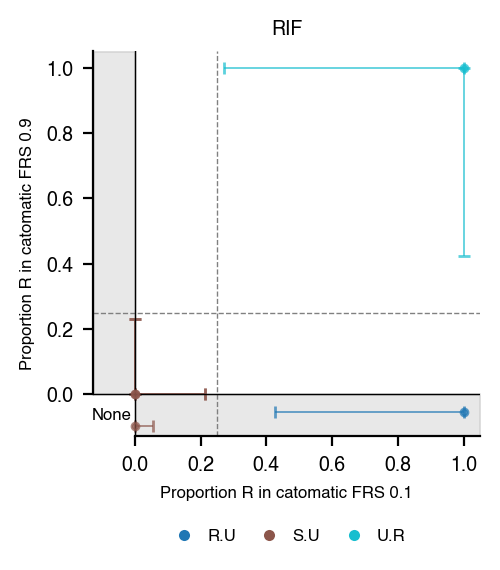

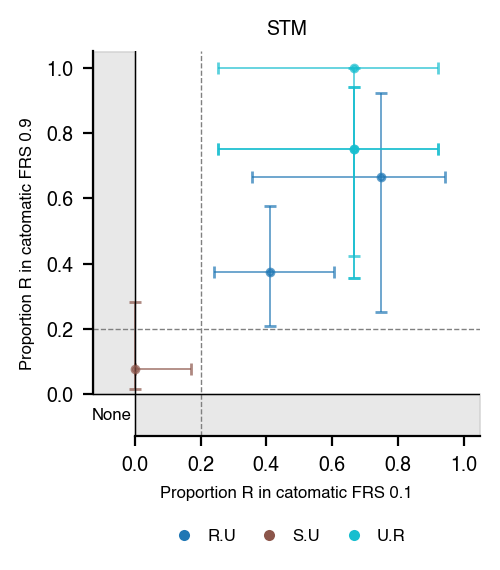

In [46]:
perf_df_filt = perf_df[perf_df['Build_FRS'].isin([0.1, 0.9])]
twoD_prop_data, oneD_prop_data = {}, {}

for (drug, test_frs), group in perf_df_filt.groupby(['Drug', 'Test_FRS']):
    if len(group) == 2:
        #if any(abs(group[col].max() - group[col].min()) > 0 for col in ['Sensitivity', 'Specificity', 'Coverage']):
        background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]

        cat1, cat2 = utils.load_catomatic_catalogue(drug, background, p, 0.1, dir='catalogues/cryptic-v1/frs/'), utils.load_catomatic_catalogue(drug, background, p, 0.9, dir='catalogues/cryptic-v1/frs/')

        df, merged_cats = utils.expand_and_classify_cats(cat1, cat2, drug)
        df = df[df.PREDICTION_PAIR.isin(['R.S', 'S.R', 'R.U', 'S.U', 'U.R', 'U.S'])].reset_index()

        #also pull out rows that only exist in 1 catalogue - these become the oneD data 
        df_1_prop = merged_cats[(pd.isna(merged_cats[['PROPORTION_cat1', 'PROPORTION_cat2', 'CONFIDENCE_cat1', 'CONFIDENCE_cat2']]).any(axis=1))&(merged_cats.PREDICTION_PAIR.isin(['R.U', 'S.U', 'U.R', 'U.S']))]

        x, y, xerr, yerr = utils.extract_errors(df, 'PROPORTION', 'CONFIDENCE')
        x_1_prop, y_1_prop, xerr_1_prop, yerr_1_prop = utils.extract_errors(df_1_prop, 'PROPORTION', 'CONFIDENCE')
        
        twoD_prop_data[drug] = {'x': x, 'y': y, 'xerr': xerr, 'yerr': yerr, 'categories': df['PREDICTION_PAIR'].values, 'background_1': background,'background_2': background, 'mutations':df['MUTATION'].values}
        oneD_prop_data[drug] = {'x': x_1_prop, 'y': y_1_prop, 'xerr': xerr_1_prop, 'yerr': yerr_1_prop, 'categories': df_1_prop['PREDICTION_PAIR'].values, 'background': background, 'mutations':df_1_prop['MUTATION'].values}

utils.plot_cat_comp_proportions(twoD_prop_data, oneD_prop_data, ax_labels={'x':'catomatic FRS 0.1', 'y':'catomatic FRS 0.9'}, figpath='figs/frs/') 


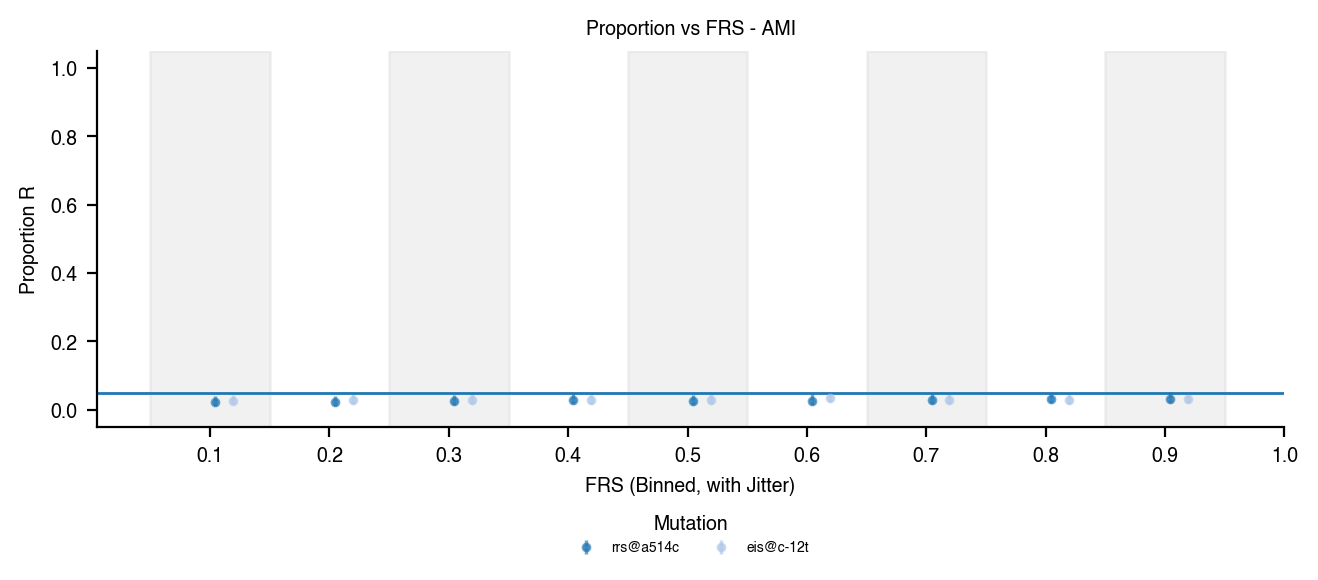

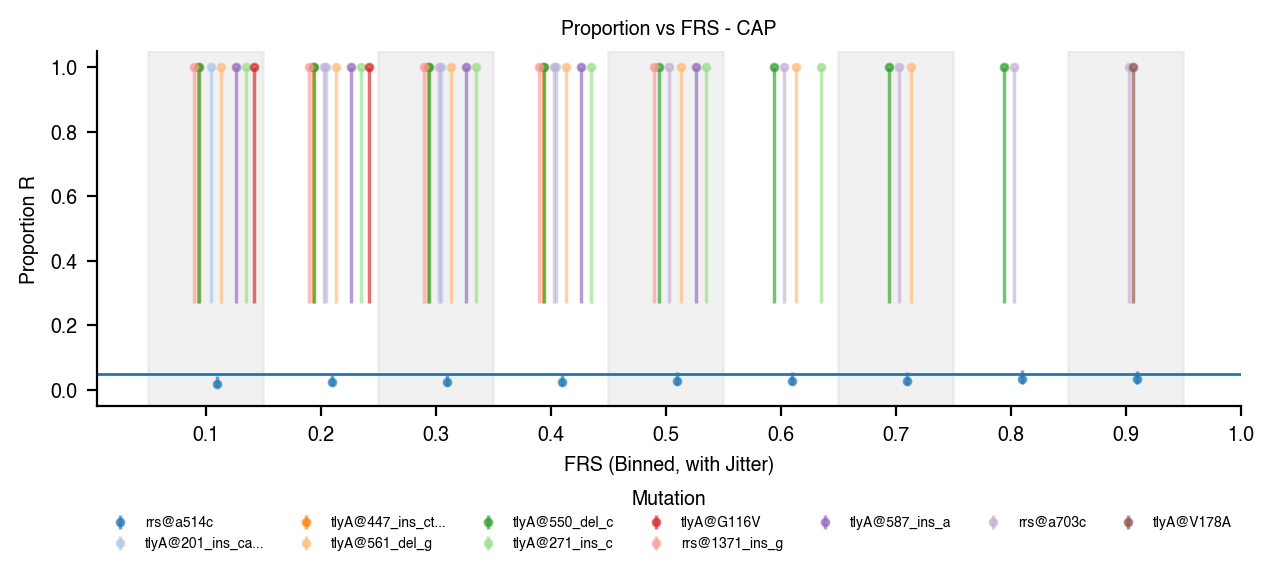

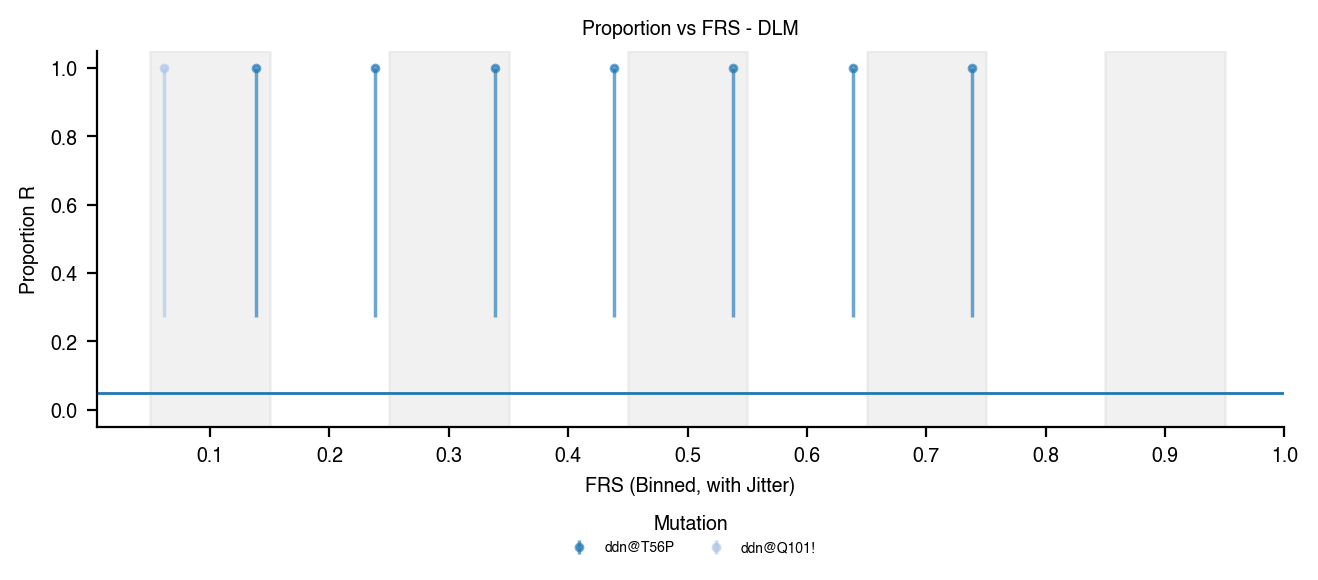

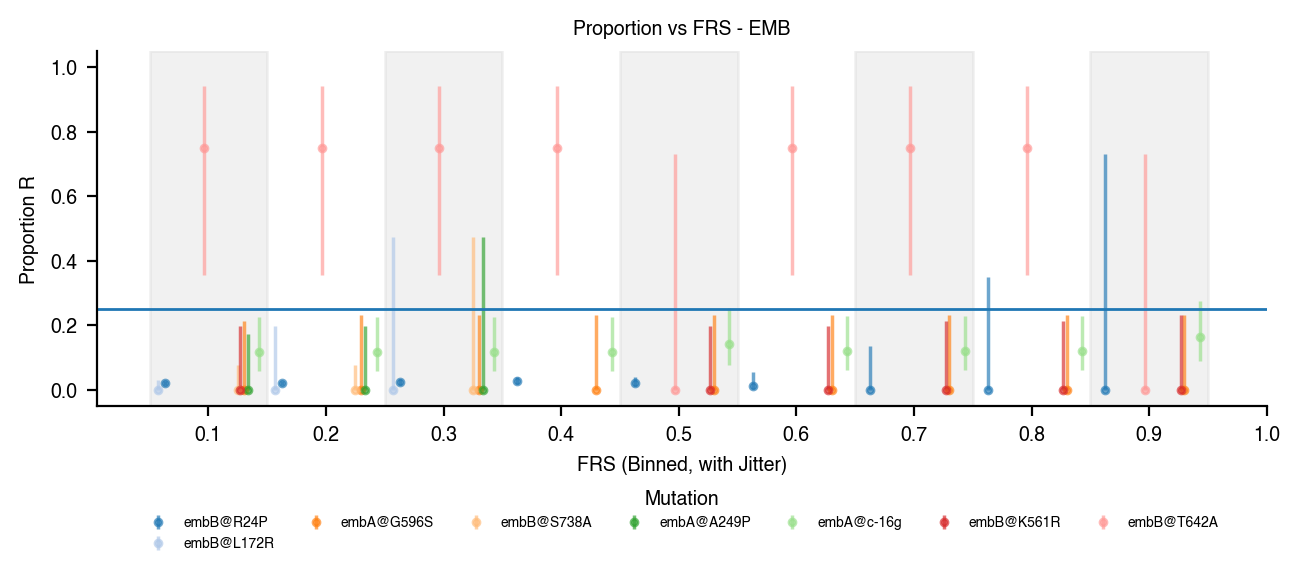

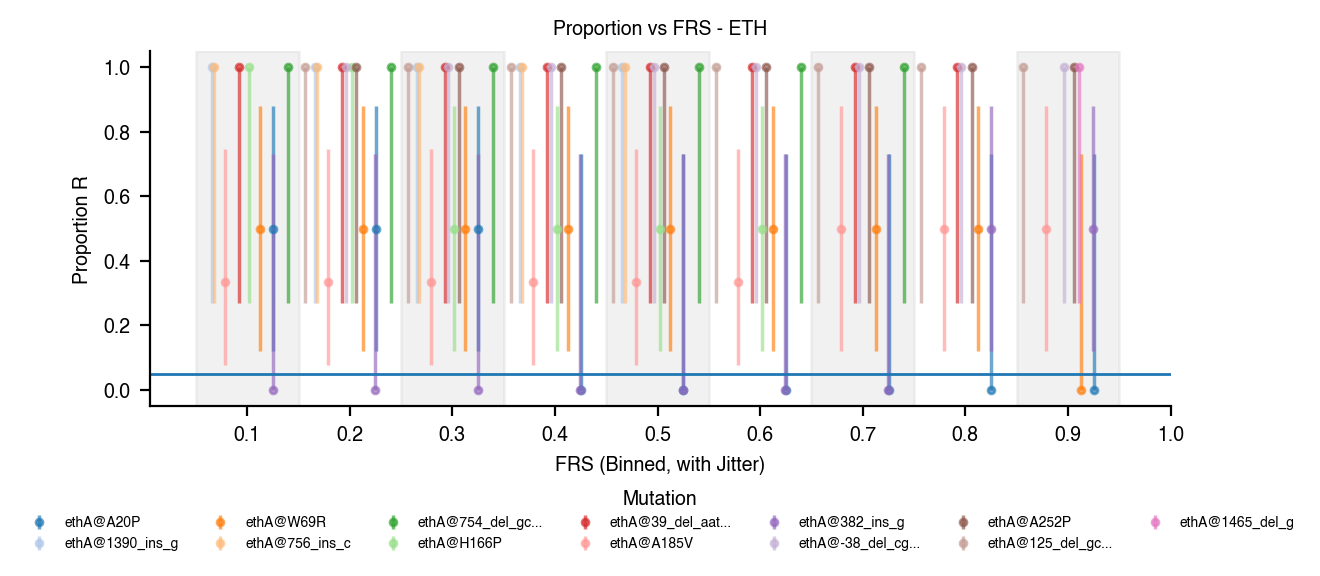

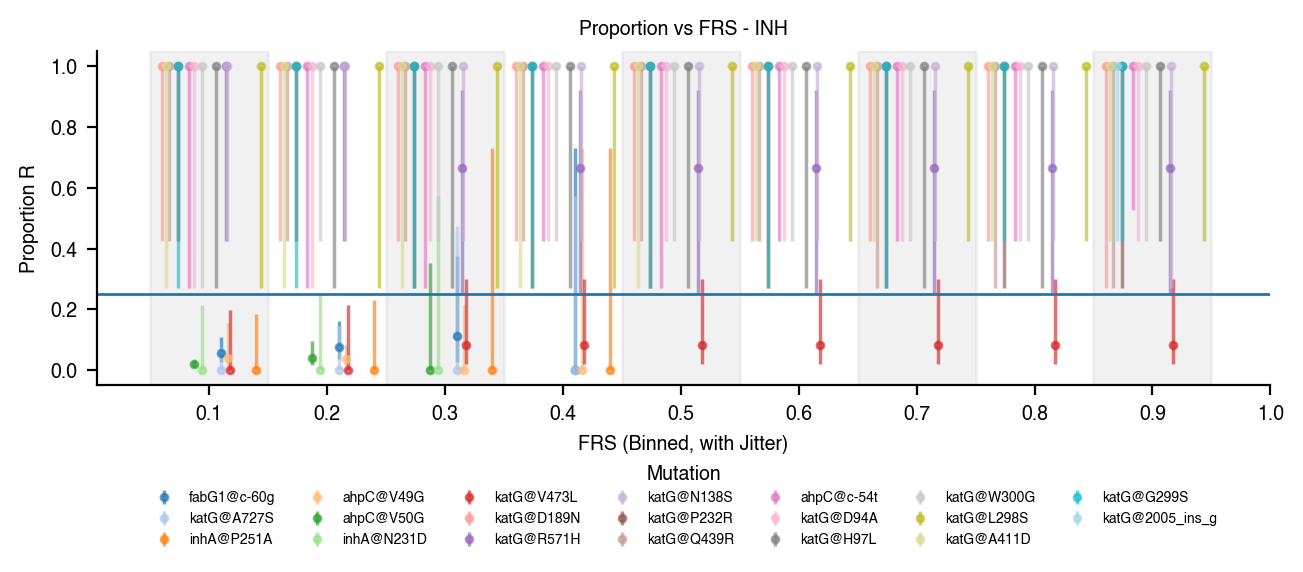

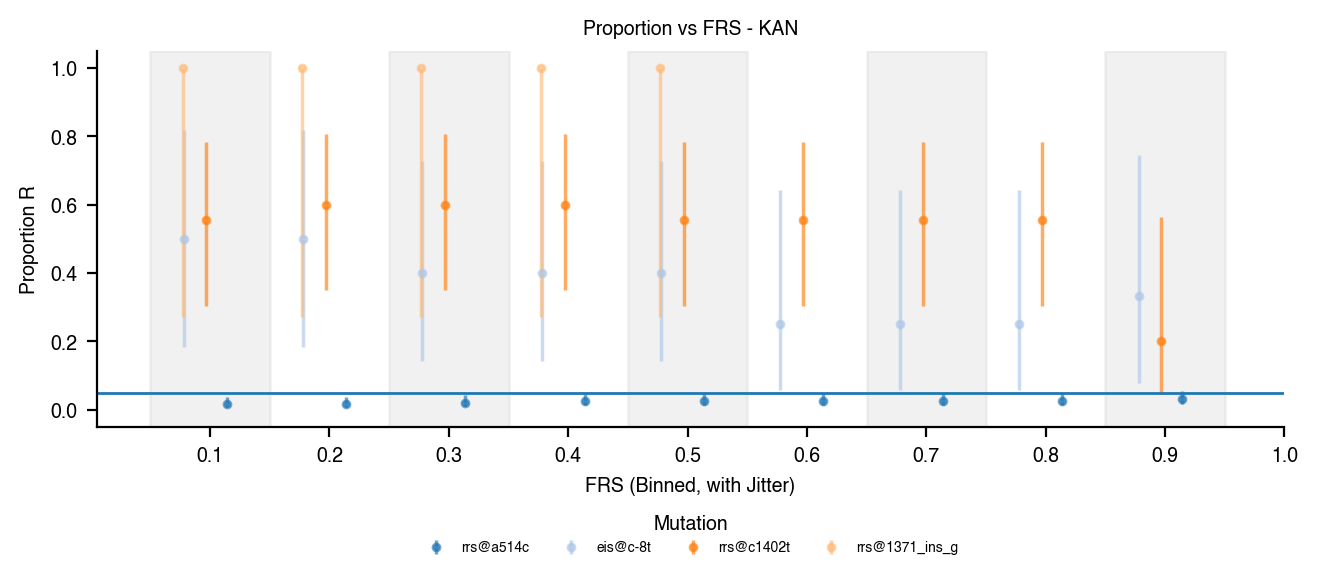

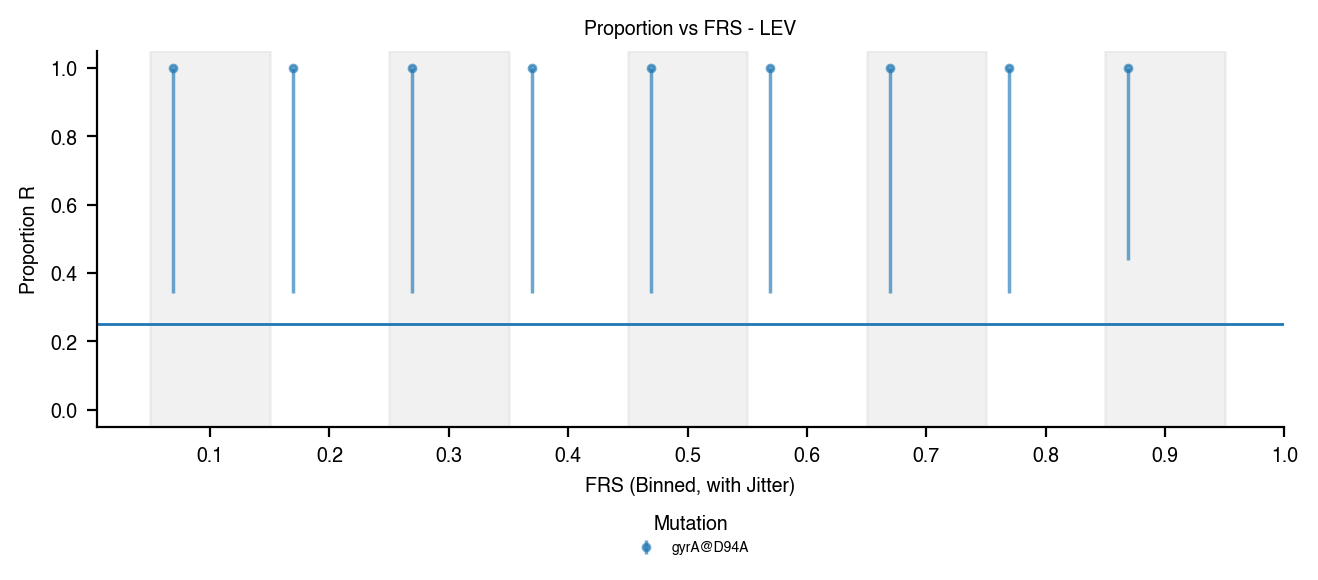

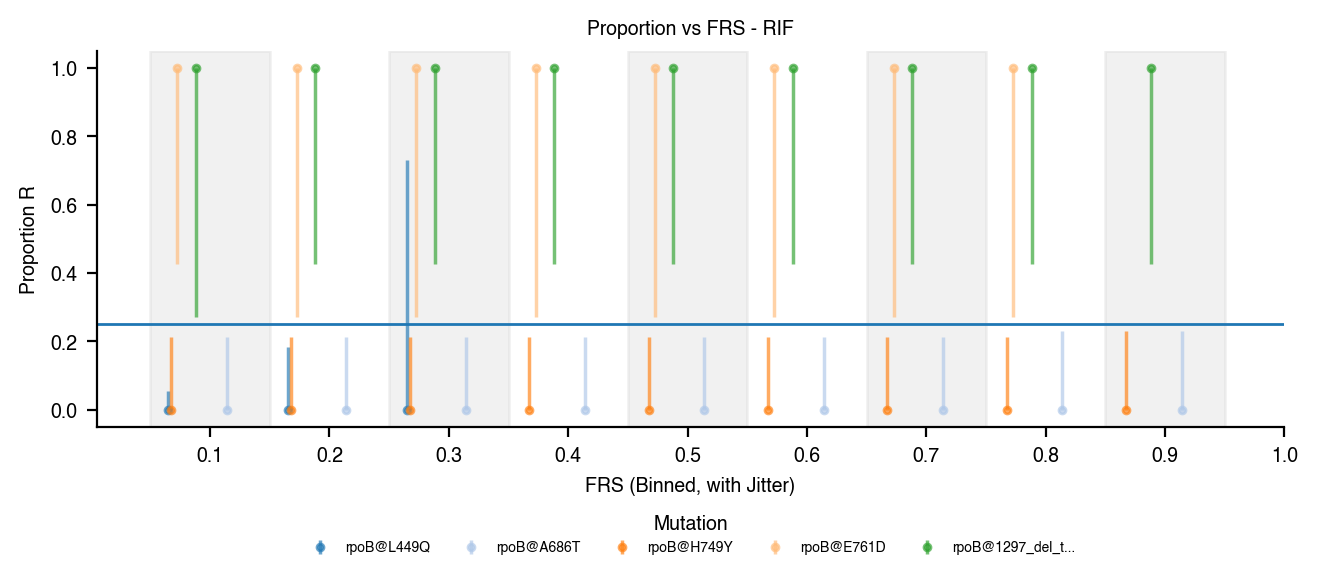

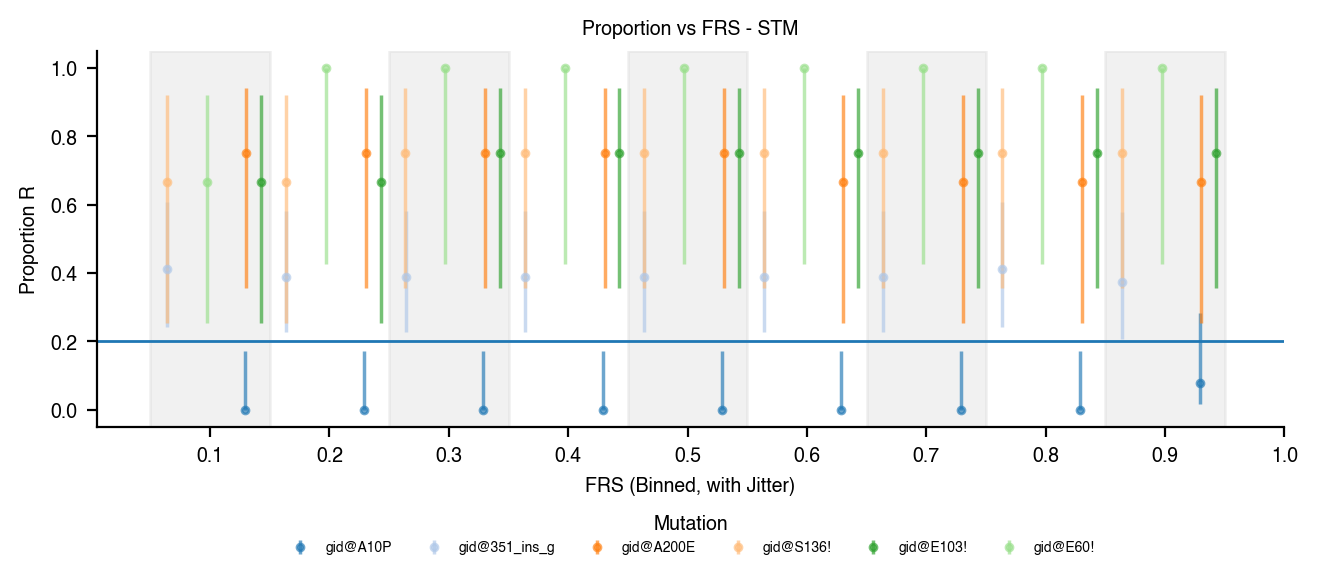

In [ ]:
frs_prop_data = defaultdict(lambda: defaultdict(lambda: {'frs': [], 'y': [], 'error': []}))

to_float = lambda x: float(x) if isinstance(x, np.float64) else x

for drug, v in twoD_prop_data.items():
    # Collect unique mutations
    muts = np.unique(np.concatenate([twoD_prop_data[drug]['mutations'], oneD_prop_data[drug]['mutations']]))
    background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]

    for frs in build_frs_values:
        catalogue = utils.load_catomatic_catalogue(drug, background, p, frs, dir='catalogues/cryptic-v1/frs/')
        for field in ['PROPORTION', 'CONFIDENCE']:
            catalogue[field] = catalogue['EVIDENCE'].apply(lambda x: utils.extract_value(x, field.lower()))

        catalogue_muts = catalogue[catalogue.MUTATION.isin(muts)]
        def extract_errors(df, prop_col, conf_col):
            def clean_ci(ci):
                if isinstance(ci, list) and len(ci) == 2:
                    return [max(0, float(ci[0])), min(1, float(ci[1]))] 
                return [np.nan, np.nan]
            prop = df[prop_col]
            err = df[conf_col].apply(clean_ci)

            if len(prop) > 1:
                return (np.array(prop).flatten(), np.vstack(err))
            elif len(prop) == 1:
                return (np.array(prop).flatten(), np.stack(err.values).T)
            else:
                return (np.array(prop).flatten(), err.to_numpy())

        prop, error = extract_errors(catalogue_muts, 'PROPORTION', 'CONFIDENCE')

        for i, mutation in enumerate(catalogue_muts.MUTATION.tolist()):
            frs_prop_data[drug][mutation]['frs'].append(to_float(frs))
            frs_prop_data[drug][mutation]['y'].append(prop[i])
            frs_prop_data[drug][mutation]['error'].append(error[i] if prop.shape[0] > 1 else error)
            frs_prop_data[drug][mutation]['background'] = background

frs_prop_data = {drug: dict(mutations) for drug, mutations in frs_prop_data.items()}

color_map = {}
for drug, mutations_dict in frs_prop_data.items():
    unique_mutations = list(mutations_dict.keys())
    color_map[drug] = dict(zip(unique_mutations, sns.color_palette("tab20", len(unique_mutations))))

utils.plot_mutation_error_bars(frs_prop_data, color_map=color_map, min_err=1, figpath='figs/frs/')


I think it would be sensible to look for any mutations that change classification across any of the FRS'? Results may make more sense as we would then get full picture of what is coming and going (ie rather than just between 0.9 and 0.1)

In [16]:
df_mic = {}
for drug, v in twoD_prop_data.items():
    mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=True)
    test_mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=False)
    phenotypes = prep_phenotypes(
        drug,
        "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl",
        "data/cryptic-tables-v3.1.0/GENOMES.parquet",
        "data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet",
        'v1.0'
    )
    all = pd.merge(phenotypes, mutations, on=['UNIQUEID'], how='left')
    all = all[all.METHOD_3.isin(['UKMYC5', 'UKMYC6'])]
    if len(all)>0:
        all["MIC_FLOAT"] = utils.cap_mic_to_float(all)

        muts = np.unique(np.concatenate([twoD_prop_data[drug]['mutations'], oneD_prop_data[drug]['mutations']])) # Convert to set for faster lookups
        # Group by 'UNIQUEID' and filter groups where the size is 1
        solos = all.groupby('UNIQUEID').filter(lambda x: len(x) == 1).UNIQUEID.unique()
        filtered = all[(all.UNIQUEID.isin(solos)) & (all.MUTATION.isin(muts))]
        df_mic[drug] = pd.DataFrame({
            "UNIQUEID": filtered.UNIQUEID.tolist(),
            "MUTATION": filtered.MUTATION.tolist(),
            "FRS": filtered.FRS.tolist(),
            "METHOD": filtered.METHOD_3.tolist(),
            "MIC": filtered.MIC_FLOAT.tolist(),
        })

        df_mic[drug]["binned_FRS"] = [str(round(i, 1)) for i in df_mic[drug].FRS.tolist()]
        df_mic[drug]["binned_MIC"] = [str(i) for i in df_mic[drug].MIC]
        df_mic[drug]["MIC"] = [str(i) for i in df_mic[drug].MIC] 




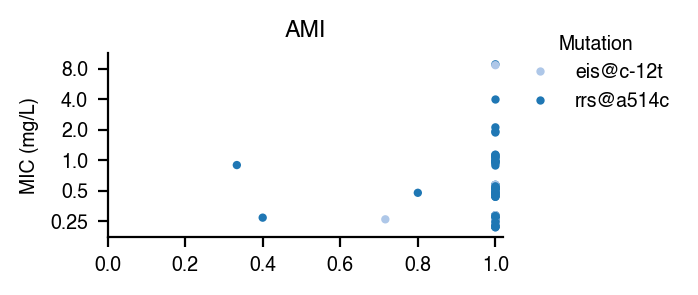

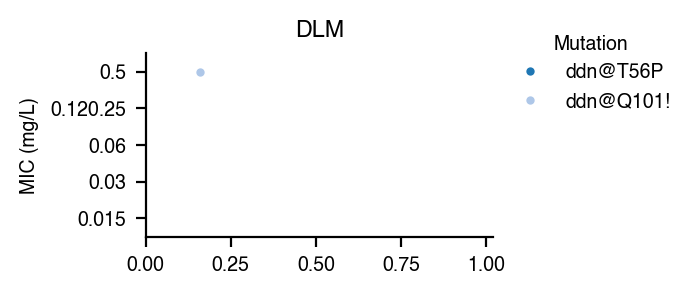

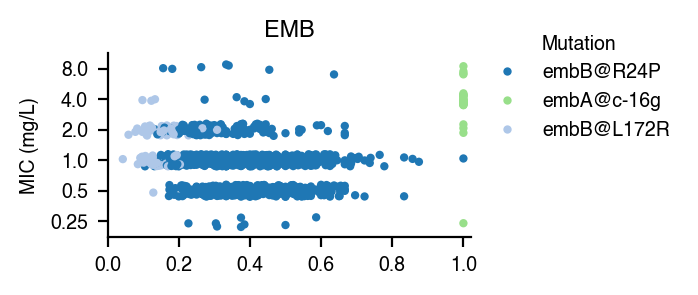

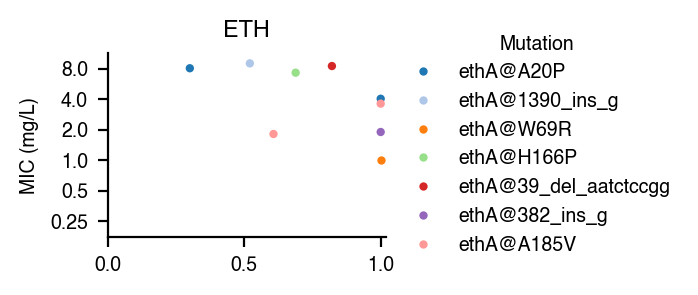

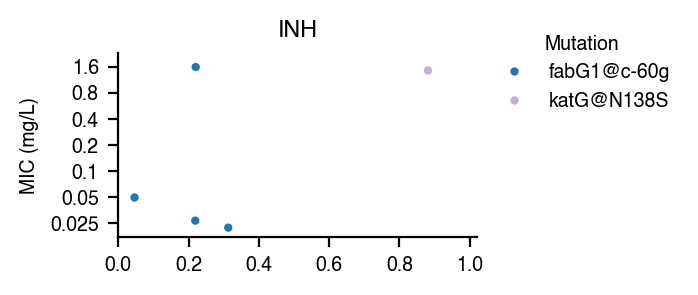

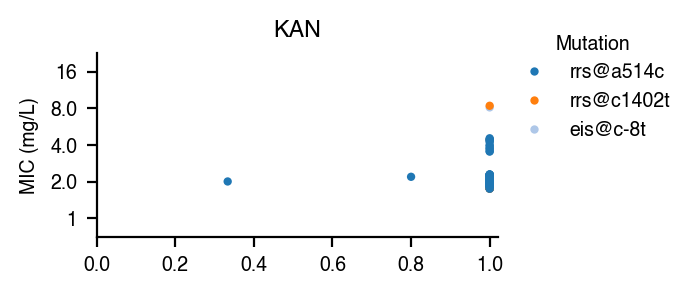

/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:1119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  # Compute the count for each (DRUG, PHENOTYPE)


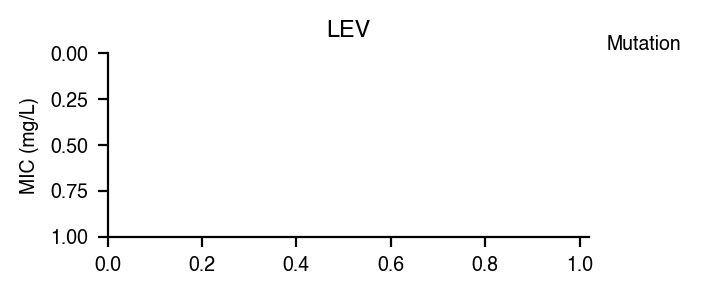

/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:1119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  # Compute the count for each (DRUG, PHENOTYPE)


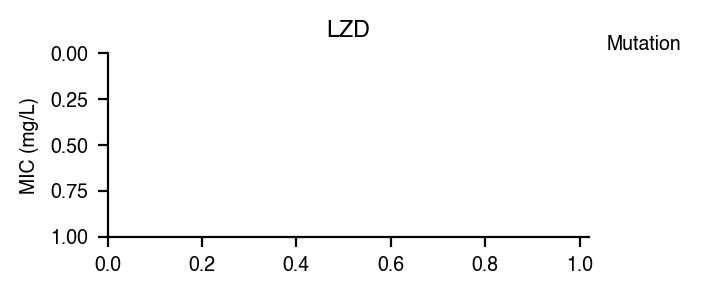

/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:1119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  # Compute the count for each (DRUG, PHENOTYPE)


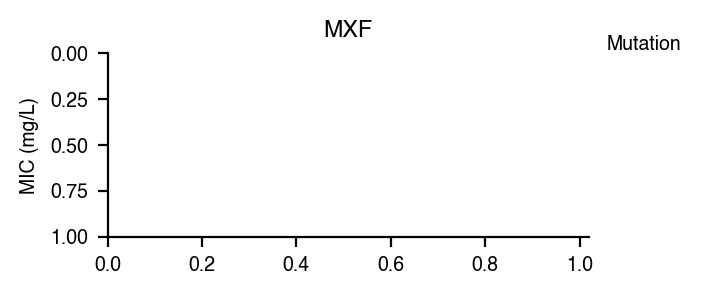

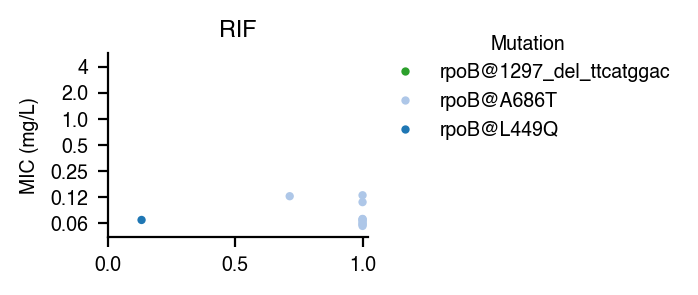

In [47]:
utils.plot_frs_vs_mic(df_mic, color_map=color_map, figpath='figs/frs/')

In [18]:
opt_cats_v1

DRUG  BACKGROUND_RATE  p_value  SENSITIVITY  SPECIFICITY  COVERAGE  \
0   RIF             0.25     0.90     0.963381     0.984365  0.971158   
1   INH             0.25     0.90     0.944363     0.988292  0.956400   
2   STM             0.20     0.90     0.954789     0.934732  0.911294   
3   EMB             0.25     0.90     0.952322     0.914556  0.906068   
4   AMI             0.05     0.90     0.848526     0.982960  0.922512   
5   CAP             0.05     0.90     0.844141     0.975157  0.920088   
6   ETH             0.05     0.90     0.907343     0.867731  0.898681   
7   KAN             0.05     0.90     0.832658     0.925637  0.953942   
8   LEV             0.25     0.95     0.985017     0.746639  0.215235   
9   MXF             0.25     0.95     0.989105     0.514035  0.250278   
10  CIP             0.25     0.90     0.777778     0.951220  0.056883   
11  LZD             0.20     0.95     0.306977     0.997886  0.996474   
12  DLM             0.05     0.90     0.172589     0.998996  0.991435   

       Score    R   S     U  Total     catalogue  
0   0.971232   41  25   347    413  catomatic_v1  
1   0.959949   60  23   617    700  catomatic_v1  
2   0.940073   89  12   509    610  catomatic_v1  
3   0.931741   17  53  1029   1099  catomatic_v1  
4   0.903654   14   8   387    409  catomatic_v1  
5   0.898635   43   4   232    279  catomatic_v1  
6   0.893727  295   4   358    657  catomatic_v1  
7   0.884808   23   6   357    386  catomatic_v1  
8   0.759547    5   3    80     88  catomatic_v1  
9   0.698819    6   3    88     97  catomatic_v1  
10  0.685631    2   2     6     10  catomatic_v1  
11  0.652149    1   5    37     43  catomatic_v1  
12  0.584280   17   1    49     67  catomatic_v1

- AMI: lose sensitivity at low FRS, owing to de-classification of high frequency, boderline variant eis@g-37t. However, the proportion is rather low, and its using a very low background - 211 vs 17 feels very S, what happens if we increase the background to capture this variant as S? (ie check perf of grid search at higher background). Not many UKMYC solos with MICs.

- CAP: increae cov at low FRS, owing to to classification of high frequency, borderline variant rrs@a514c. Similar to AMI, proportion and background is low - check spec and cov of grid search at higher background. No MIC data

- EMB: 4 variants are de-classified at low FRS due to lower proportion and wider confidence. One variant is classified R at high FRS. There are a couple susceptible variants classified at low FRS with tight confidence, like embB@L172R and emB@S378A. embB@R24P is interesting as at low FRS it is a high freq S variant, but is supported less and less as FRS increases until only 1 is seen at FRS 0.9 - only really exists at lower FRS. embB@N296H is classified S at low FRS, but its proportion gradually increases as FRS goes up until its U. The opposite happens to embA@c-16t whereby proportion decreases and it is classified S at high FRS.

- ETH: Coverage increases at low FRS due to the S classification of a bunch of low freq variant + high freq borderline ethA@S266R is also reclassified S at low FRS - same q as above, what if we use slight higher background? A few low-freq variants are reclassified R at low FRS. 2 low freq mutations are reclassified R at high FRS.

- INH: Coverage increases due to the classification of a bunch of fairly high freq S mutations at low FRS - these don't seem to exist at higher FRS (notably. katG@A727S, fabG1@c-60g, ahpC@V49G and ahpc@V60G). We also see the re-classification of a couple failry low-freq variants to/from R as FRS is increased. We also a handful of variants be classified R at high FRS.

- LEV: Specificity jumps big and holds constant at 0.9 to 0.8, while cocerage drops. Due to low frequency gryA@D639G and gyryA@s95T, which do not exist at low FRS. S95T is causal for the per jump, as it disappears at 0.8, while D630G exists through the jump.

- MXF: Major performance boost from 0.7 to 0.6, doe the reclassification of boderline high frequency S variant gryA@E21Q (again check grid search), which have bumped coverage, and the classification of a bunch of low and medium freq variants that only exist at low FRS - higher freq ones are gryA@D94G, gryA@A90V, and gryA@D94Y. Stark difference. No lower FRS MIC values for plates...

- STM: 10% coverage boost when FRS is lowered due to classification of high frequency boerline S variant gid@E92D. High frequency S borderline gid@Y195H doesnt appear at FRS 0.9, but does below 0.9. Medium-freq gid@A119T proportion increases lower than FRS 0.9 and is classified R. Low freq gid@G164V is relcassified U at low FRS. Cov boost due to E92D and Y195H. No MIC data from plates.



# Performance Benchmarking

Because the WHO catalogues have been parsed into a piezo format, we can easily run predictions from them on our training set (or any tarining set) and compare performance with catomatic's catalogues.

However, the WHO use a binary prediction system, whereby samples containing U mutations are assumed to be S (ie those mutations are removed). However, we can ignore this and use a ternary system to compare to ours (which will also be more informative as it will tell us how many WHO predictions are actual look-ups, and how many are assumptions).

##### Catalogues to compare:

- whov1
- whov2
- catomatic_v1 (built on same dataset as whov1)
- catomatic_v3

##### Test sets (may not need to compare all catalogues at same time. )
- crypticv1 (training set for whov1 and catomativ1 - allows only head-to-head training comp)
- cryptic v3 (training set for catomatic_v3)
- validation set (for now just use crypticv3 training set as placeholder)



### catomatic_v1 vs WHOv1 on CRyPTICv1

Can use piezo to calculate WHOv1 performance on cryptic-v1 

The WHO catalogue has slightly different numbering for some genes - need to correct for these.

In [19]:
import re

who_catalogue_path = 'catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS.csv'
who_catalogue = pd.read_csv(who_catalogue_path)

correction = {
    'eis': 1,
    'rrs': 1
}

# Function to correct a single mutation
def correct_single_mutation(mutation):

    gene = mutation.split('@')[0]
    mutation_part = mutation.split('@')[1]

    # Apply correction only if the gene is in the correction dictionary
    if gene in correction.keys():
        # Check if mutation contains a nucleotide change and is not an insertion/deletion
        if any(b in mutation_part for b in ['a', 't', 'c', 'g']) and ('ins' not in mutation_part) and ('del' not in mutation_part):
            match = re.findall(r'([a-zA-Z@_-]+)(-?\d+)([a-zA-Z@_-]*)', mutation_part)
            if match:  # Ensure there is a valid match before proceeding
                pre, pos, suf = match[0]
                pos = int(pos) + correction[gene]  # Apply position shift
                return f"{gene}@{pre}{pos}{suf}"  # Reconstruct mutation string

    # If no conditions match, return the original mutation
    return mutation

# Function to handle multiple mutations separated by '&'
def correct_mutations(mutation_string):
    mutations = mutation_string.split('&')  # Split multiple mutations
    corrected_mutations = [correct_single_mutation(m) for m in mutations]  # Apply correction to each
    return '&'.join(corrected_mutations)  # Rejoin corrected mutations

# Apply the mutation correction function to each row in the DataFrame
who_catalogue['MUTATION'] = who_catalogue['MUTATION'].apply(correct_mutations)
who_catalogue.to_csv('catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS_corrected.csv')

In [20]:
FRS = 0.1
whov1_results = {}
for drug, genes in drug_genes.items():
    who_catalogue = 'catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS_corrected.csv'
    if drug in pd.read_csv(who_catalogue)['DRUG'].unique():
        mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=False)
        phenotypes = prep_phenotypes(drug, "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl", "data/cryptic-tables-v3.1.0/GENOMES.parquet", "data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet", 'v1.0')        
        # Test the performance of the WHO on the training + synonymous set for this drug
        all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')
        cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all, drug=drug, catalogue_file=who_catalogue, U_to_S=False, Print=False)
        
        # Save results into grid_results
        whov1_results[drug] = {'catalogue': 'WHOv1', "SENSITIVITY": sens, "SPECIFICITY": spec, "COVERAGE": cov}

whov1_results = pd.DataFrame(whov1_results).T.reset_index().rename(columns={'index':'DRUG'})

In [21]:
mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes['AMI'], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet', train=False)
phenotypes = prep_phenotypes('AMI', "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl", "data/cryptic-tables-v3.1.0/GENOMES.parquet", "data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet", 'v1.0')        
# Test the performance of thffe WHO on the training + synonymous set for this drug
all = pd.merge(phenotypes, mutations[mutations.FRS >= 0.1], on=['UNIQUEID'], how='left')

/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


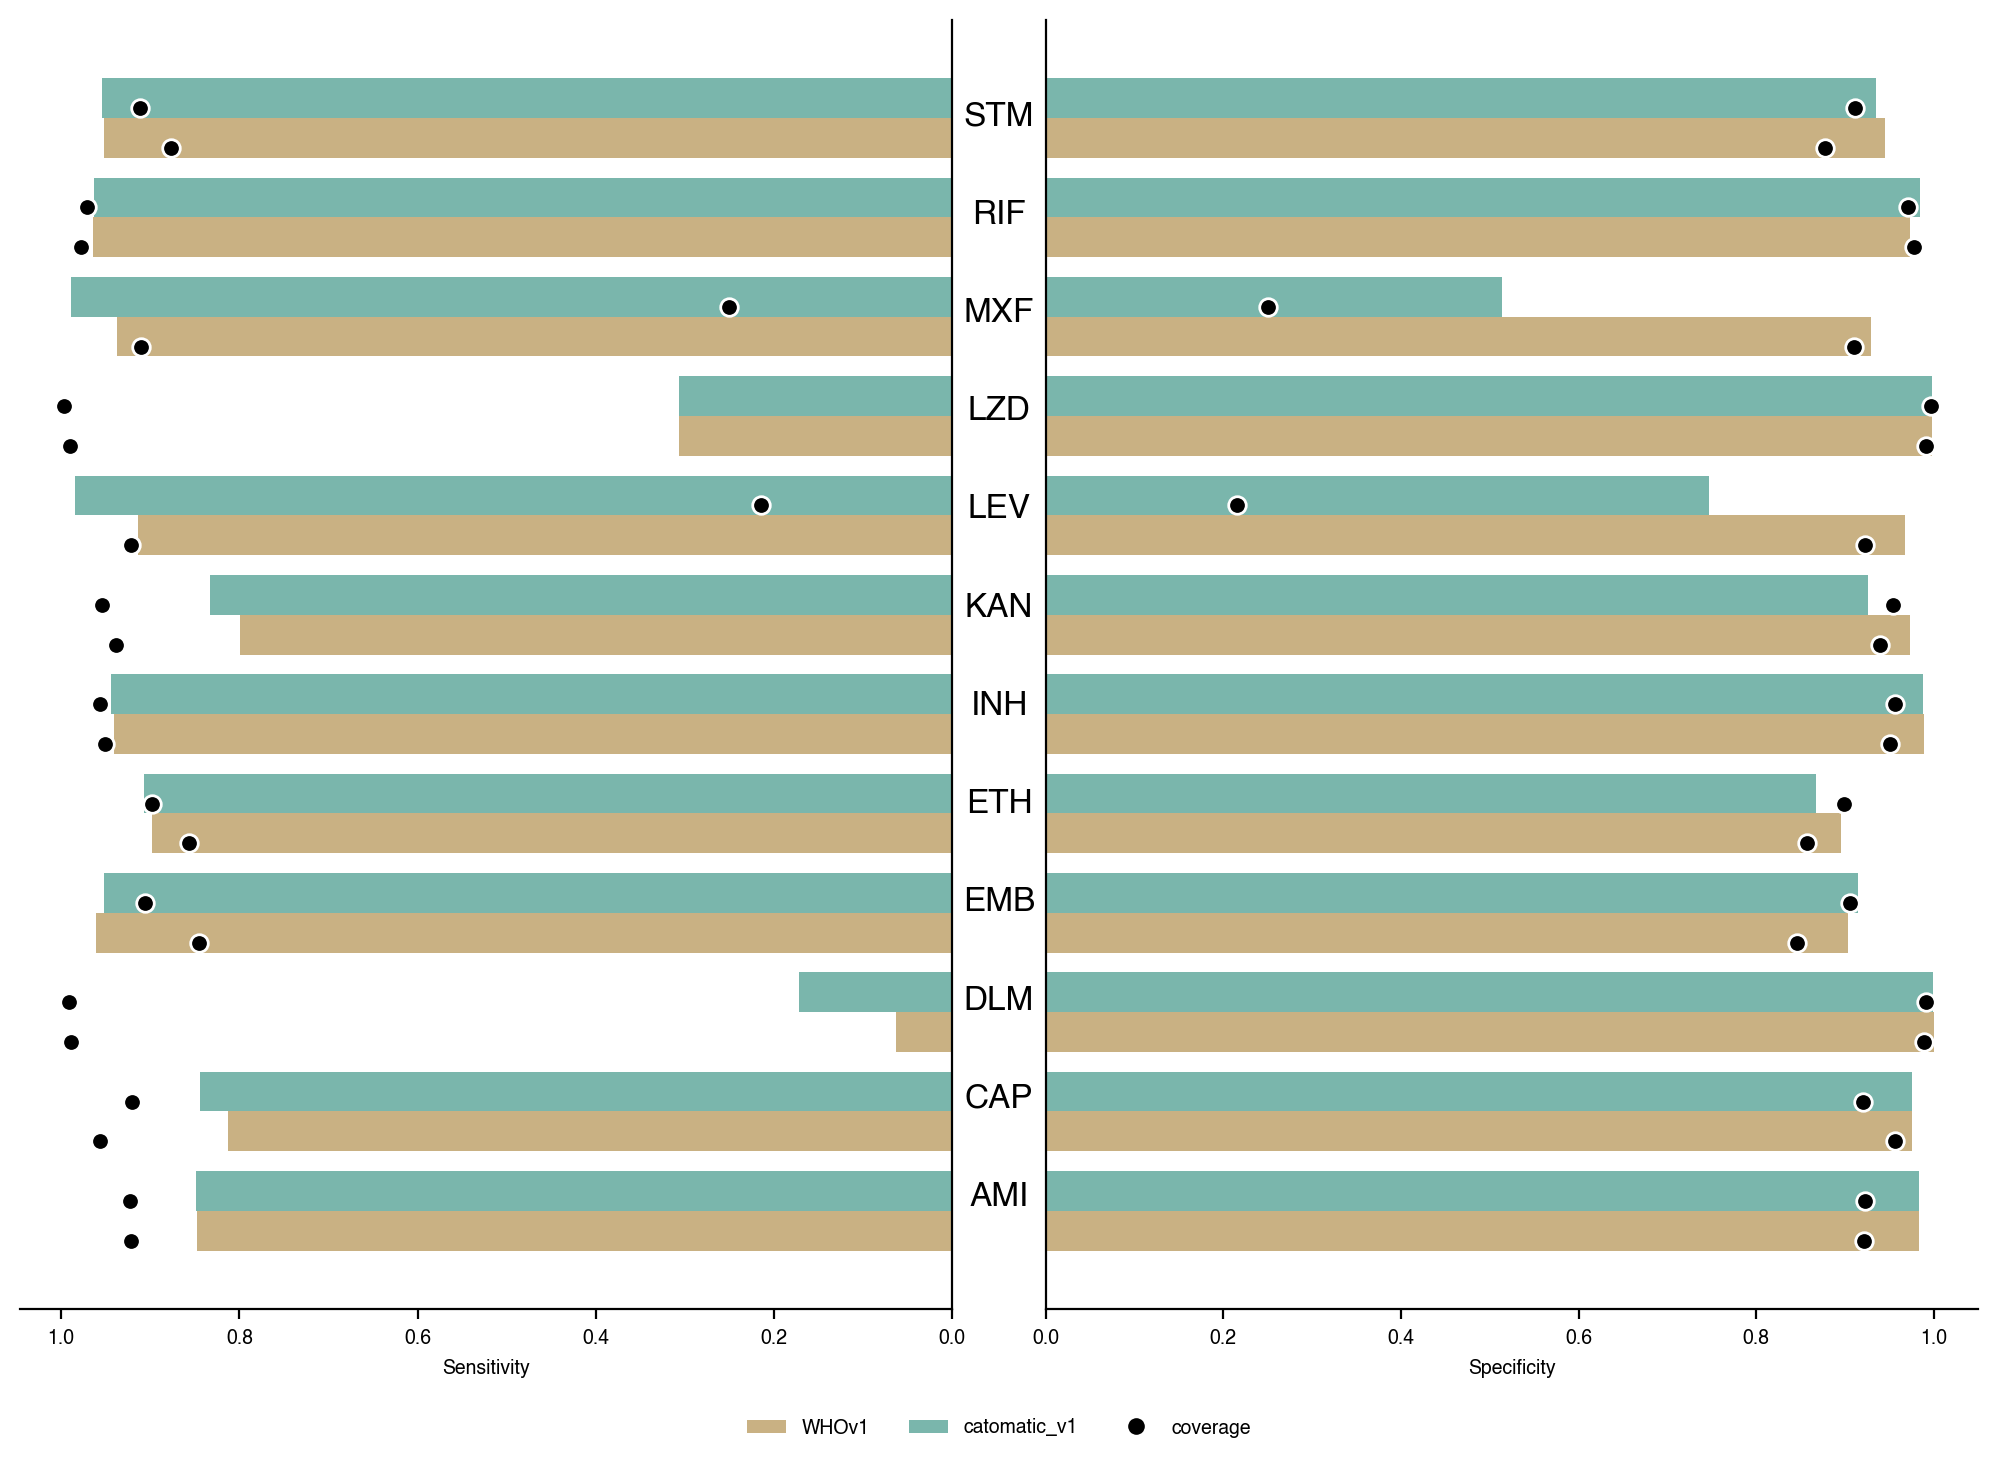

In [48]:
comp_train_perf_v1 = pd.concat([whov1_results, opt_cats_v1[opt_cats_v1.DRUG.isin(pd.read_csv(who_catalogue)['DRUG'].unique())][['DRUG', 'catalogue', 'SENSITIVITY', 'SPECIFICITY', 'COVERAGE']]], ignore_index=True).sort_values(by=['DRUG', 'catalogue'])
catalogue_palette = {
    "catomatic_v1": "#70c0b3",  # Slightly darker than #80cdc1 but lighter than #66b3aa
    "catomatic_v3": "#018571",  # Unchanged
    "WHOv1": "#d5b477",         # Slightly darker than #dfc27d but lighter than #c4a96c
    "WHOv2": "#a6611a",         # Unchanged
}

utils.back2back_sens_spec(comp_train_perf_v1, palette=catalogue_palette, savefig='figs/performance/whov1_catomaticv1.pdf')

### Discordance analysis between WHOv1 and catomatic_v1

The complications of direclty comparing catalogue contents are:
- Both contains default rules
- Both could contain expert rules (such as lof rules)

If we want an effective comparison, we have to take into account rules. The only way to do this fairly, is to expand all rules into the individual mutations that exist in the other catalogue and fall under that rule - this will give the number of variants effectively classified by each rule.

We can use piezo to do this, as it inherently understands the rules.

N.B some catalogues may contain a rule and specifici mutaitons that fall under that rule - just be aware in analysis we will get duplicates, but with different sources/evidence.

#### Catomatic-v1 vs WHOv1

This is the most fair, like-for-like comparison of the methods, as the training sets for these catalogues are the same

In [50]:
def load_who_catalogue(path):
    #Prep data for comparisons:
    who = pd.read_csv(path)
    who['EVIDENCE'] = who['EVIDENCE'].apply(utils.str_to_dict)
    who['GENBANK_REFERENCE'] = 'NC00962.3'
    who['CATALOGUE_VERSION'] = 0
    who['CATALOGUE_NAME'] = '-'
    #filter out default rules
    who = who[~who['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'reporting_rule' in x)]
    return who

who = load_who_catalogue('catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS_corrected.csv')
who['solo_R'] = who['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'Present_R'))
who['solo_S'] = who['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'Present_S'))
who['TOTAL'] = who['solo_R'] + who['solo_S']
who['PROPORTION'] = who['solo_R']/(who['solo_R']+who['solo_S'])
who['CONFIDENCE'] = who.apply(utils.wilson_ci, R_col='solo_R', S_col='solo_S', axis=1)
u_who = who[~who.PREDICTION.isin(['R','S'])]
who = who[who.PREDICTION.isin(['R','S'])]

#prep catomatic catalogues
valid_drugs = opt_cats_v1[opt_cats_v1.DRUG.isin(who.DRUG.unique())]
cats = valid_drugs.apply(
    lambda row: pd.read_csv(f"./catalogues/cryptic-v1/grid_search/{row['DRUG'].lower()}/bg_{row['BACKGROUND_RATE']}_p_{row['p_value']}_FRS_0.1.csv"),
    axis=1
).tolist()
cat = pd.concat(cats)

cat['CATALOGUE_VERSION'] = 0
cat['CATALOGUE_NAME'] = '-'
cat['EVIDENCE'] = cat['EVIDENCE'].apply(utils.str_to_dict)
#filter out default rules
cat = cat[~cat['EVIDENCE'].apply(lambda x: isinstance(x, dict) and 'default_rule' in x)]
cat['solo_R'] = cat['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 0))
cat['solo_S'] = cat['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 1))
cat['TOTAL'] = cat['solo_R'] + cat['solo_S']
cat['PROPORTION'] = cat['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'proportion'))
cat['CONFIDENCE'] = cat['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'confidence'))


#keep only R and S classifications
u_cat = cat[~cat.PREDICTION.isin(['R','S'])]
cat = cat[cat.PREDICTION.isin(['R','S'])]

valid_drugs = cat[cat.DRUG.isin(who.DRUG.unique())].DRUG.unique()

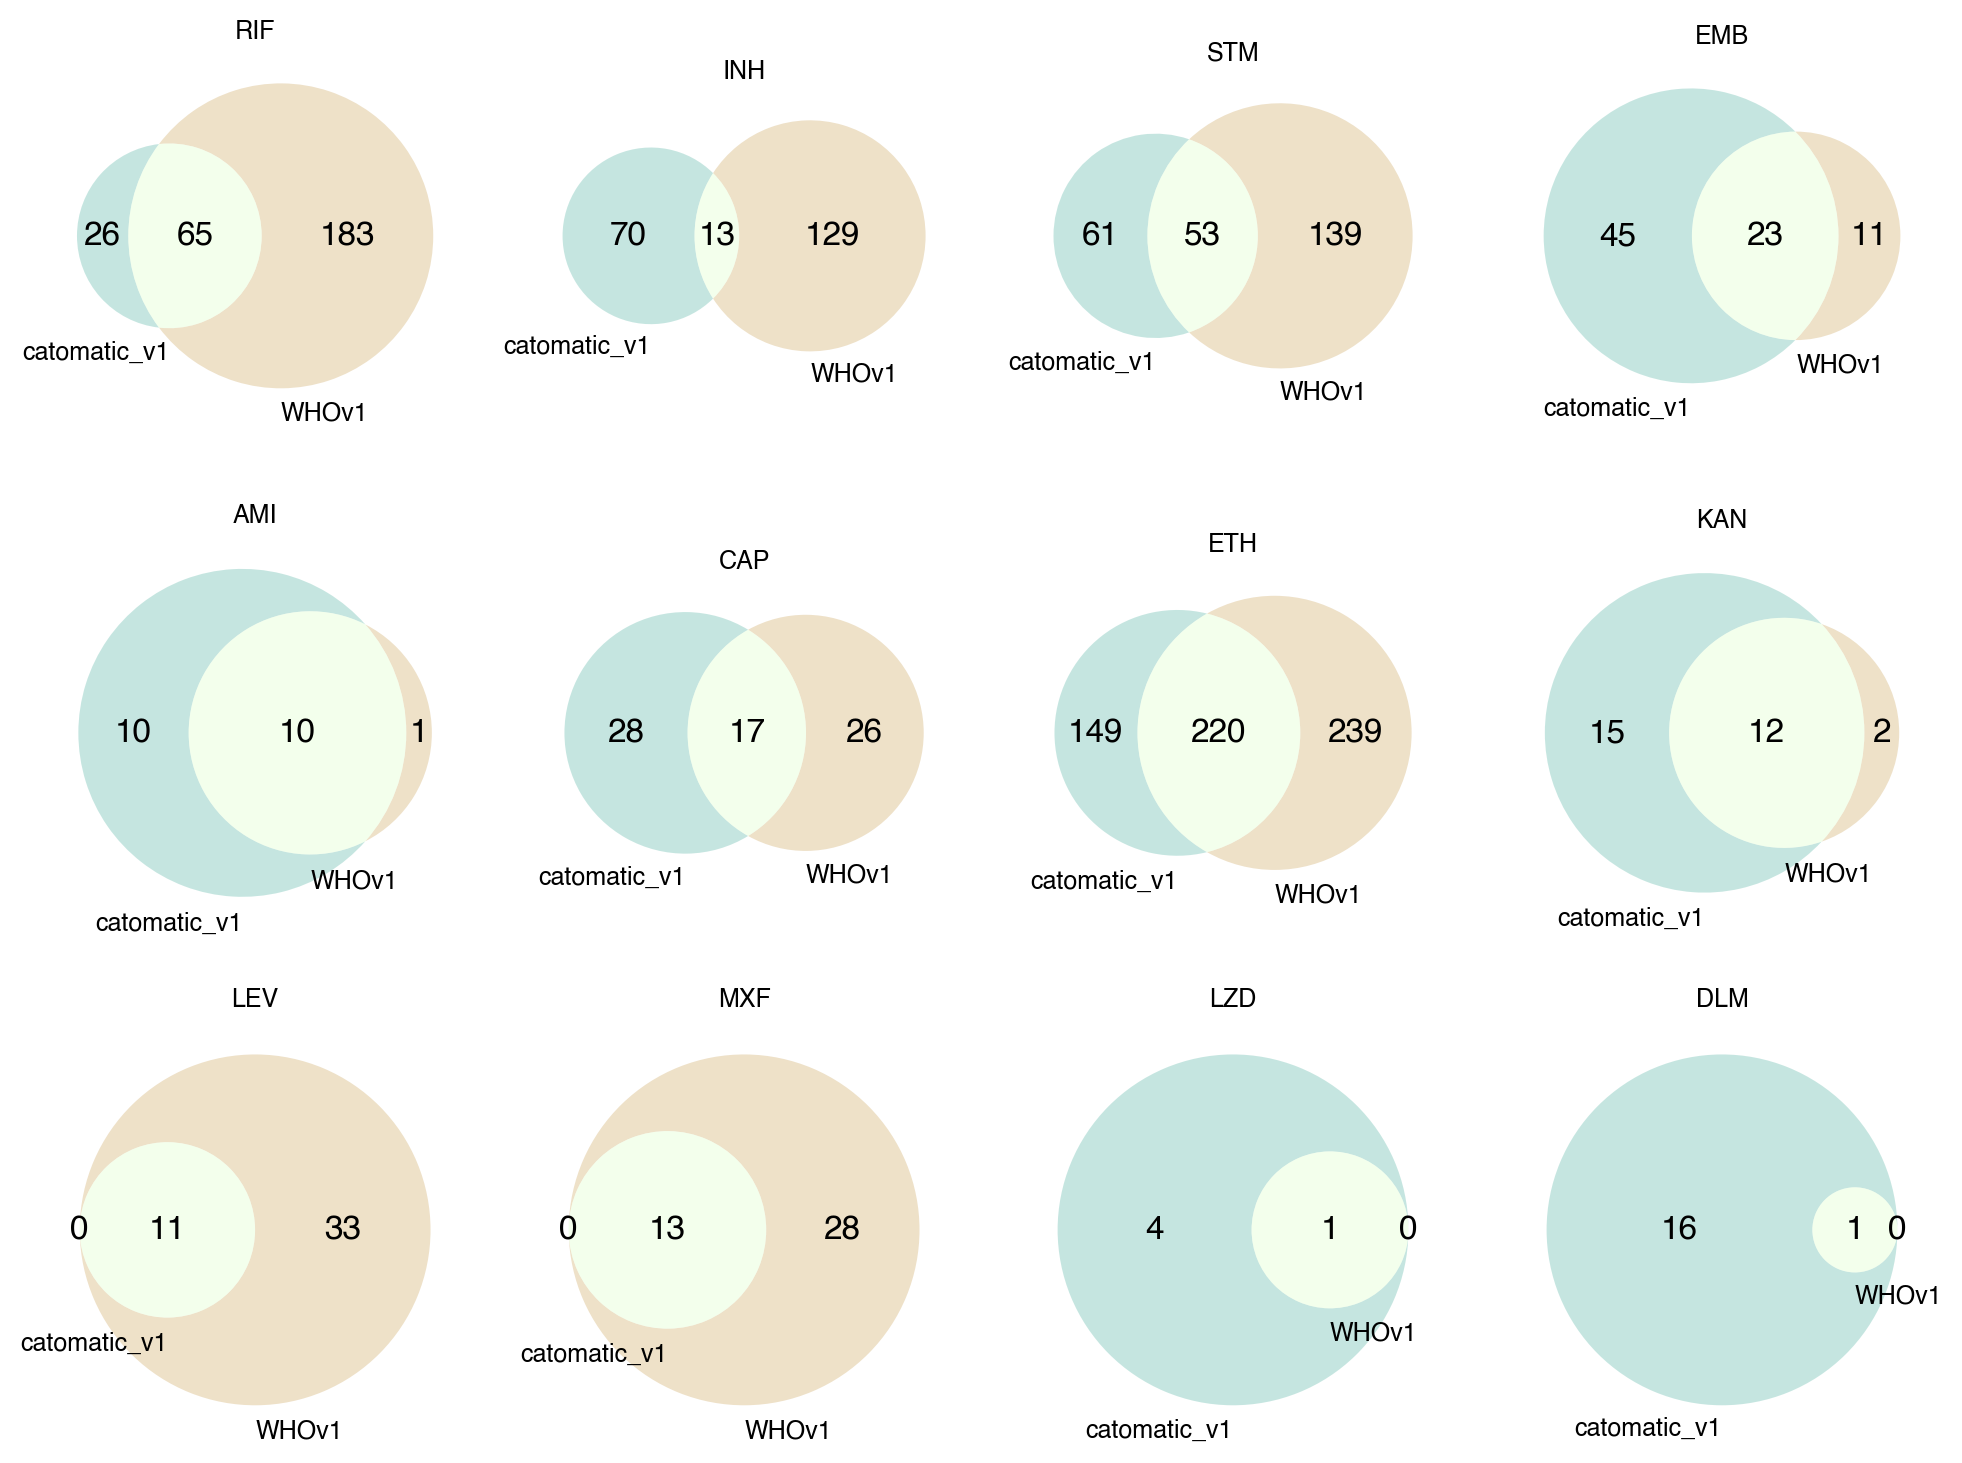

In [51]:
expanded_catalogues = utils.expand_catalogue_pair(cat, who, valid_drugs, 'RUS', ('cat', 'who'))

n_cols = 4
n_rows = -(-len(valid_drugs) // n_cols)  # Calculate rows based on number of drugs

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
axes = axes.flatten()

idx=0
for drug, v in expanded_catalogues.items():    
    merged = v['merged']
    shared_variants = len(merged[(~merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])
    who_only_variants = len(merged[(~merged.PREDICTION_who.isna()) & (merged.PREDICTION_cat.isna())])
    catomatic_only_variants = len(merged[(merged.PREDICTION_who.isna()) & (~merged.PREDICTION_cat.isna())])
    
    ax = axes[idx]
    venn_diagram = venn2(
        subsets=(catomatic_only_variants, who_only_variants, shared_variants),
        set_labels=('catomatic_v1', 'WHOv1'),
        ax=ax,
        set_colors=(catalogue_palette["catomatic_v1"], catalogue_palette["WHOv1"])  
    )
    ax.set_title(f"{drug}", fontsize=9)

    idx+=1

    for label in venn_diagram.set_labels:
        if label:
            label.set_fontsize(9)  # Adjust font size for set labels

    for label in venn_diagram.subset_labels:
        if label:
            label.set_fontsize(12)  # Adjust font size for numbers inside the circles

for ax in axes[len(valid_drugs):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.savefig('figs/discordance/whov1_catomaticv1.pdf')
plt.show()

Can plot the number of solo counts observed for each variant shared across catalogues (not including rules, as the number of counrs in a rule can't be expanded to represent the counts of indvidual mutaitons that fall under that rule (ie the number of points will be less than the shared counts above, which include the rules) - this is automatically handled as the evidence columns for variants expanded from rules dont contain counts).

Could perhaps also plot proportion of resistance?

In [52]:
expanded_catalogues = utils.expand_catalogue_pair(cat, who, valid_drugs, 'RUS', ('cat', 'who'))
all_drugs_merged = pd.concat(expanded_catalogues[drug]['merged'] for drug in valid_drugs)
suffixes = ('cat', 'who')
all_drugs_merged['PREDICTION_PAIR'] = all_drugs_merged.apply(utils.classify_predictions, axis=1, args=(suffixes,))
all_drugs_merged['DRUG'] = all_drugs_merged['DRUG_who'].combine_first(all_drugs_merged['DRUG_cat'])

summary_table = (
    all_drugs_merged.drop_duplicates(['DRUG', 'MUTATION']).groupby(['DRUG', 'PREDICTION_PAIR'])
    .size()
    .unstack(fill_value=0)  # Pivot table to create columns for prediction pairs
    .reset_index()  # Resets the index, moving 'PREDICTION_PAIR' into a column
)

summary_table.rename(columns={'DRUG': 'DRUG'}, inplace=True)
summary_table['total'] = summary_table.drop(columns=['DRUG']).sum(axis=1)
summary_table.columns.name = None

print ('Prediction pairs comparing catomatic_v1 with WHOv1, including rules:')
summary_table

Prediction pairs comparing catomatic_v1 with WHOv1, including rules:


DRUG  R.R  R.S  R.U  S.R  S.S  S.U  U.R  U.S  total
0   AMI    4    0   10    0    6    0    0    1     21
1   CAP   15    0   28    0    2    0   23    3     71
2   DLM    1    0   16    0    0    0    0    0     17
3   EMB   12    0    5    0   11   40    3    8     79
4   ETH  147    0  148    0    0    1  239    0    535
5   INH    8    0   52    0    2   18  120    9    209
6   KAN    8    1   14    0    3    1    0    2     29
7   LEV    5    0    0    0    1    0    9   15     30
8   LZD    1    0    0    0    0    4    0    0      5
9   MXF    6    0    0    0    1    0    8   12     27
10  RIF   31    0   10    1    7   16  178    3    246
11  STM   33    0   56    0    4    5  136    3    237

We can compare which variants were actually captured in each catalogues (ie not deriving solely from rules):

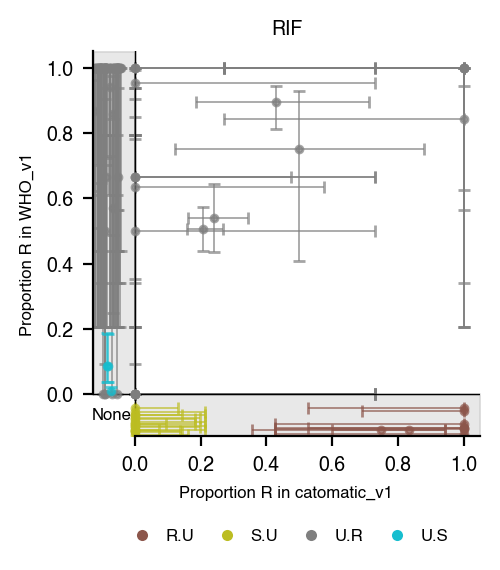

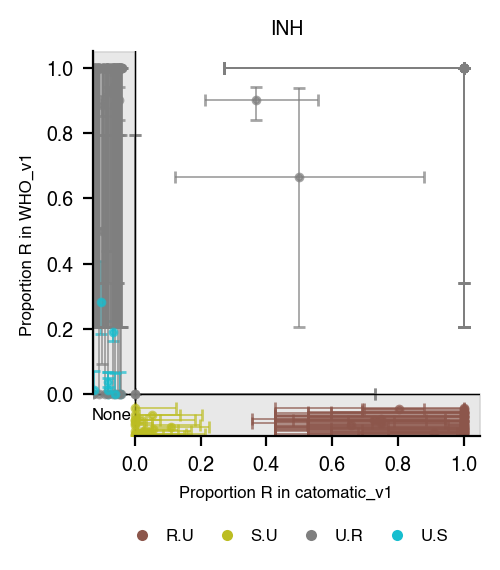

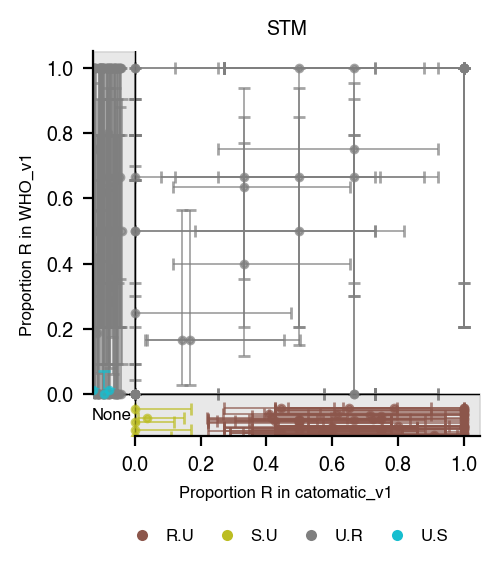

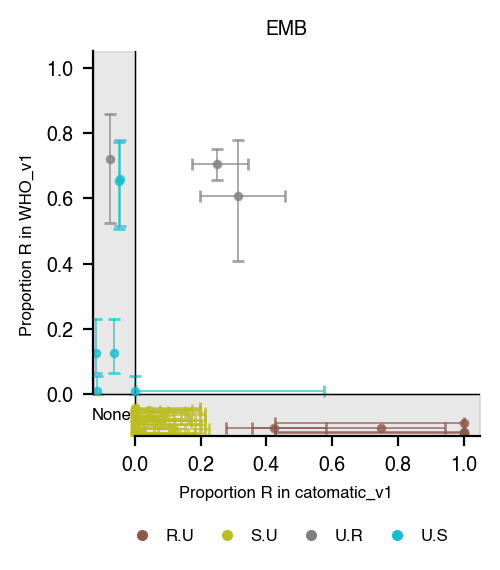

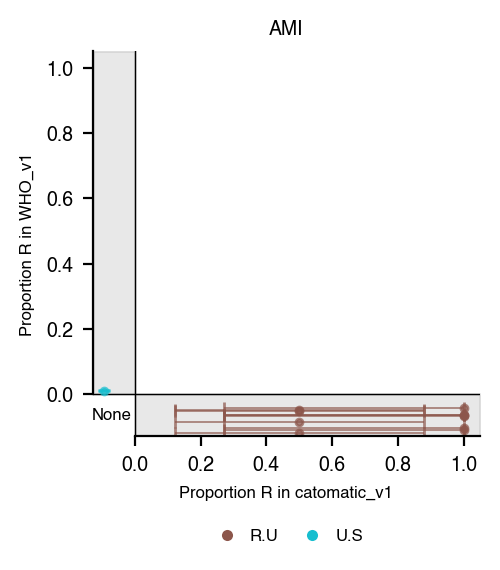

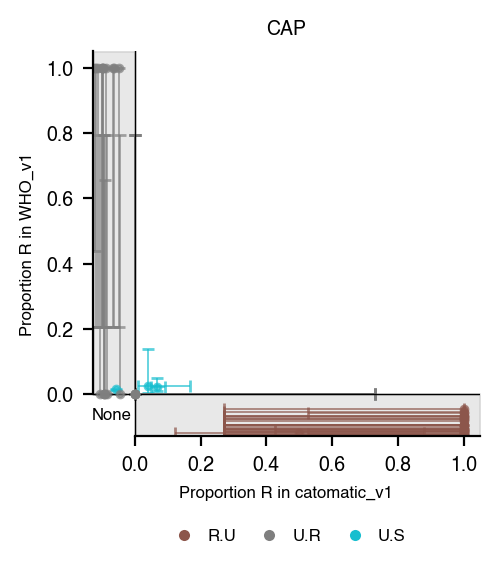

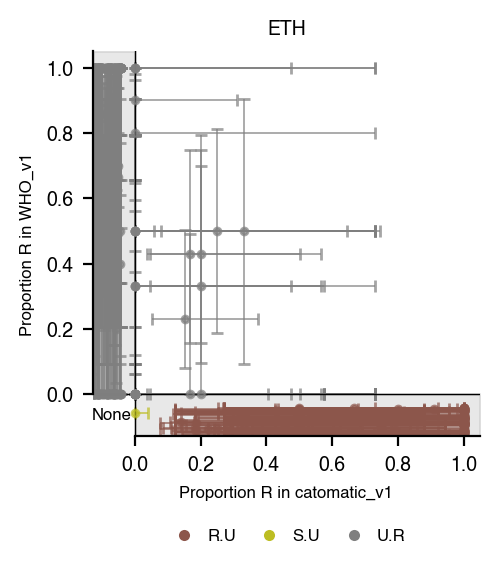

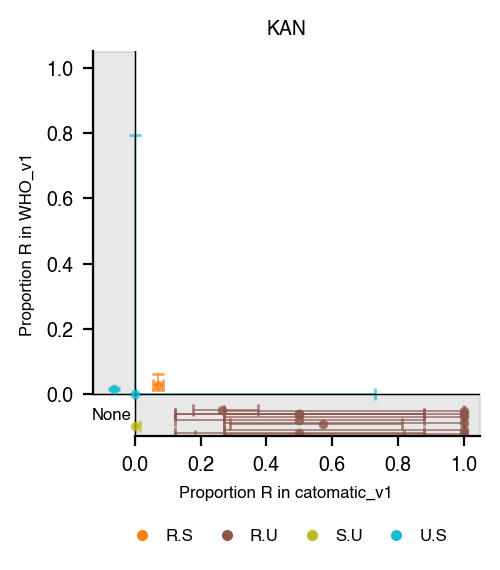

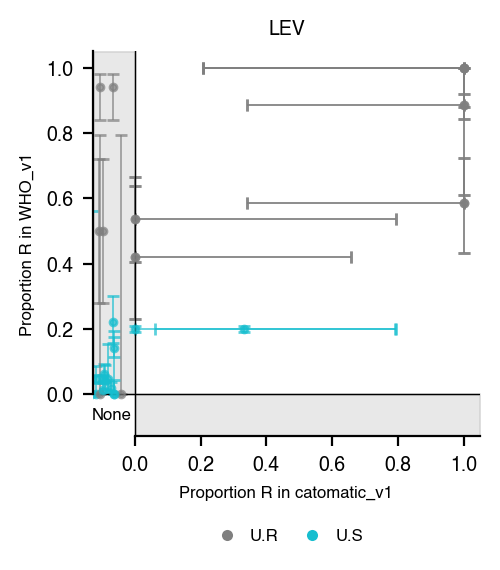

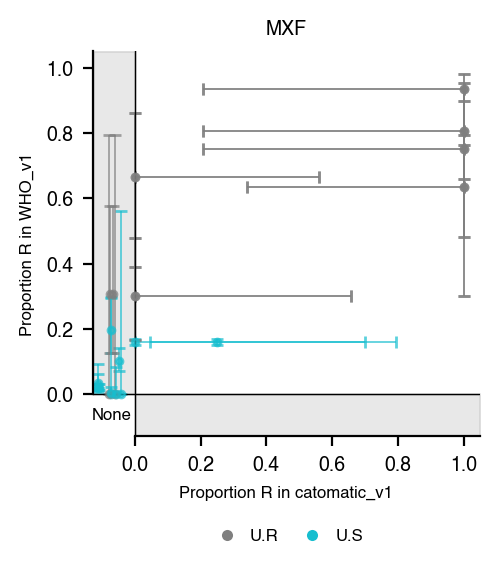

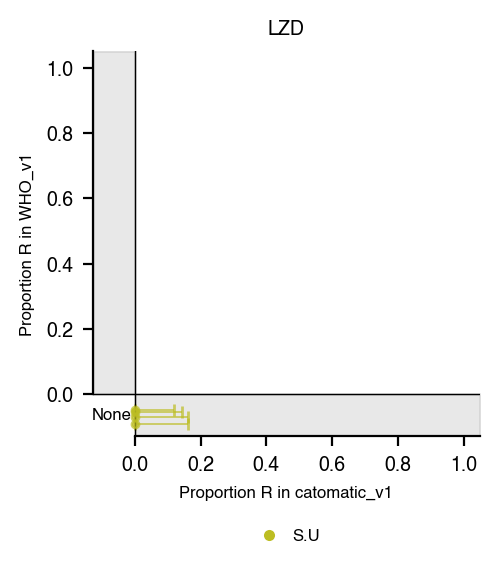

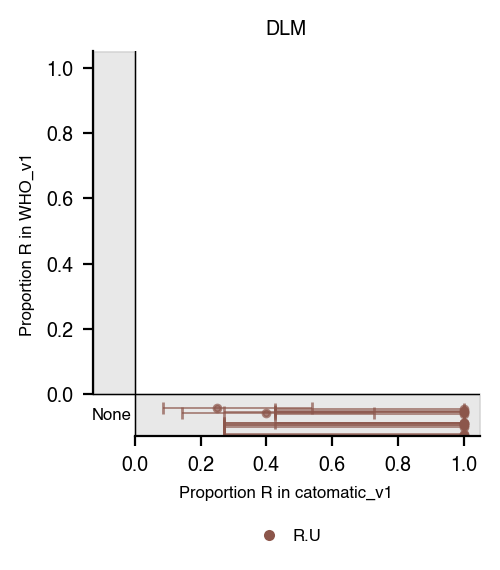

In [53]:
def prep_cat_who_comp_plot(cat, who, drug, min_n = 0, prediction_values='not_matched'):
    twoD_prop_data, oneD_prop_data = {}, {}

    who_v1, u_who_v1 = who[who.DRUG==drug], u_who[u_who.DRUG==drug]
    cat_v1, u_cat_v1 = cat[cat.DRUG==drug], u_cat[u_cat.DRUG==drug]

    expanded_catalogues = utils.expand_catalogue_pair(cat_v1, who_v1, [drug], 'RUS', ('cat', 'who'))
    merged = expanded_catalogues[drug]['merged']

    suffixes = ('cat', 'who')
    merged['PREDICTION_PAIR'] = merged.apply(utils.classify_predictions, axis=1, args=(suffixes,))
    merged['DRUG'] = merged['DRUG_cat'].combine_first(merged['DRUG_who'])

    df = utils.update_missing_proportions(merged, [u_cat_v1, u_who_v1], suffixes=['cat', 'who'])

    if prediction_values=='not_matched':
        df = df[df.PREDICTION_PAIR.isin(['R.S', 'S.R', 'R.U', 'S.U', 'U.R', 'U.S'])].reset_index()
        df_1_prop = merged[(pd.isna(merged[['PROPORTION_cat', 'PROPORTION_cat', 'CONFIDENCE_who', 'CONFIDENCE_who']]).any(axis=1))&(merged.PREDICTION_PAIR.isin(['R.U', 'S.U', 'U.R', 'U.S']))]
    elif prediction_values=='matched':
        df = df[df.PREDICTION_PAIR.isin(['R.R', 'S.S'])].reset_index()
        df_1_prop = merged[(pd.isna(merged[['PROPORTION_cat', 'PROPORTION_cat', 'CONFIDENCE_who', 'CONFIDENCE_who']]).any(axis=1))&(merged.PREDICTION_PAIR.isin([]))]

    df = df[(df.TOTAL_cat > min_n)|(df.TOTAL_who > min_n)]
    df_1_prop = df_1_prop[(df_1_prop.TOTAL_cat > min_n)|(df_1_prop.TOTAL_who > min_n)]

    x, y, xerr, yerr = utils.extract_errors(df, 'PROPORTION', 'CONFIDENCE', suffixes=suffixes)
    x_1_prop, y_1_prop, xerr_1_prop, yerr_1_prop = utils.extract_errors(df_1_prop, 'PROPORTION', 'CONFIDENCE', suffixes=suffixes)

    twoD_prop_data[drug] = {'x': x, 'y': y, 'xerr': xerr, 'yerr': yerr, 'categories': df['PREDICTION_PAIR'].values, 'mutations':df['MUTATION'].values}
    oneD_prop_data[drug] = {'x': x_1_prop, 'y': y_1_prop, 'xerr': xerr_1_prop, 'yerr': yerr_1_prop, 'categories': df_1_prop['PREDICTION_PAIR'].values, 'mutations':df_1_prop['MUTATION'].values}

    return twoD_prop_data, oneD_prop_data

unique_categories = ['R.R', 'R.S', 'S.R', 'S.S', 'R.U', 'U.R', "S.U", 'U.S']
cmap = c_map.get_cmap('tab10', len(unique_categories))
category_colors = {category: mcolors.to_hex(cmap(i)) for i, category in enumerate(unique_categories)}
for drug in valid_drugs:
    twoD_data, oneD_data = prep_cat_who_comp_plot(cat, who, drug, min_n=0, prediction_values='not_matched')

    utils.plot_cat_comp_proportions(twoD_data, oneD_data, ax_labels={'x':'catomatic_v1', 'y':'WHO_v1'}, legend='prediction_pair', category_colors=category_colors, figpath='figs/discordance/whov1_catv1_') 

Really need to work out if the difference in performance for MXF and LEV is only due to LEV-MXF expert rule, or if there is more to it. Looks like they encounter more data? Should we loosen constrains/not prioritise sensitivyt as much? We need to try and get more variants in.

Can also try and add MXF R variants to LEV and vice versa to see the effect.


In [54]:
drug_mapping = {'MXF': 'LEV', 'LEV': 'MXF'}

def duplicate_mxf_lev_rows(df):
    new_rows = []

    for _, row in df.iterrows():
        if row['DRUG'] in drug_mapping and row['PREDICTION'] == 'R':
            new_drug = drug_mapping[row['DRUG']]

            # Check if this mutation already exists with 'R' for the other drug
            exists = ((df['MUTATION'] == row['MUTATION']) & 
                      (df['DRUG'] == new_drug) & 
                      (df['PREDICTION'] == 'R')).any()
            
            if not exists:
                new_row = row.copy()
                new_row['DRUG'] = new_drug
                new_rows.append(new_row)

    if new_rows:
        df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    
    return df

background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == 'MXF', ['BACKGROUND_RATE', 'p_value']].iloc[0]
print (background)
mxf = pd.read_csv(f"./catalogues/cryptic-v1/grid_search/mxf/bg_{background}_p_{p}_FRS_0.1.csv")
background, p = opt_cats_v1.loc[opt_cats_v1.DRUG == 'LEV', ['BACKGROUND_RATE', 'p_value']].iloc[0]
lev = pd.read_csv(f"./catalogues/cryptic-v1/grid_search/lev/bg_{background}_p_{p}_FRS_0.1.csv")

mxf_lev = pd.concat([mxf, lev])
mxf_lev = duplicate_mxf_lev_rows(mxf_lev)

#looks that like that only added a single row to lev... wont make much difference

0.25


Although this information is encded in the plots above, we can also plot isolate counts for each classified mutation to help idenitfy the source of disagreement:

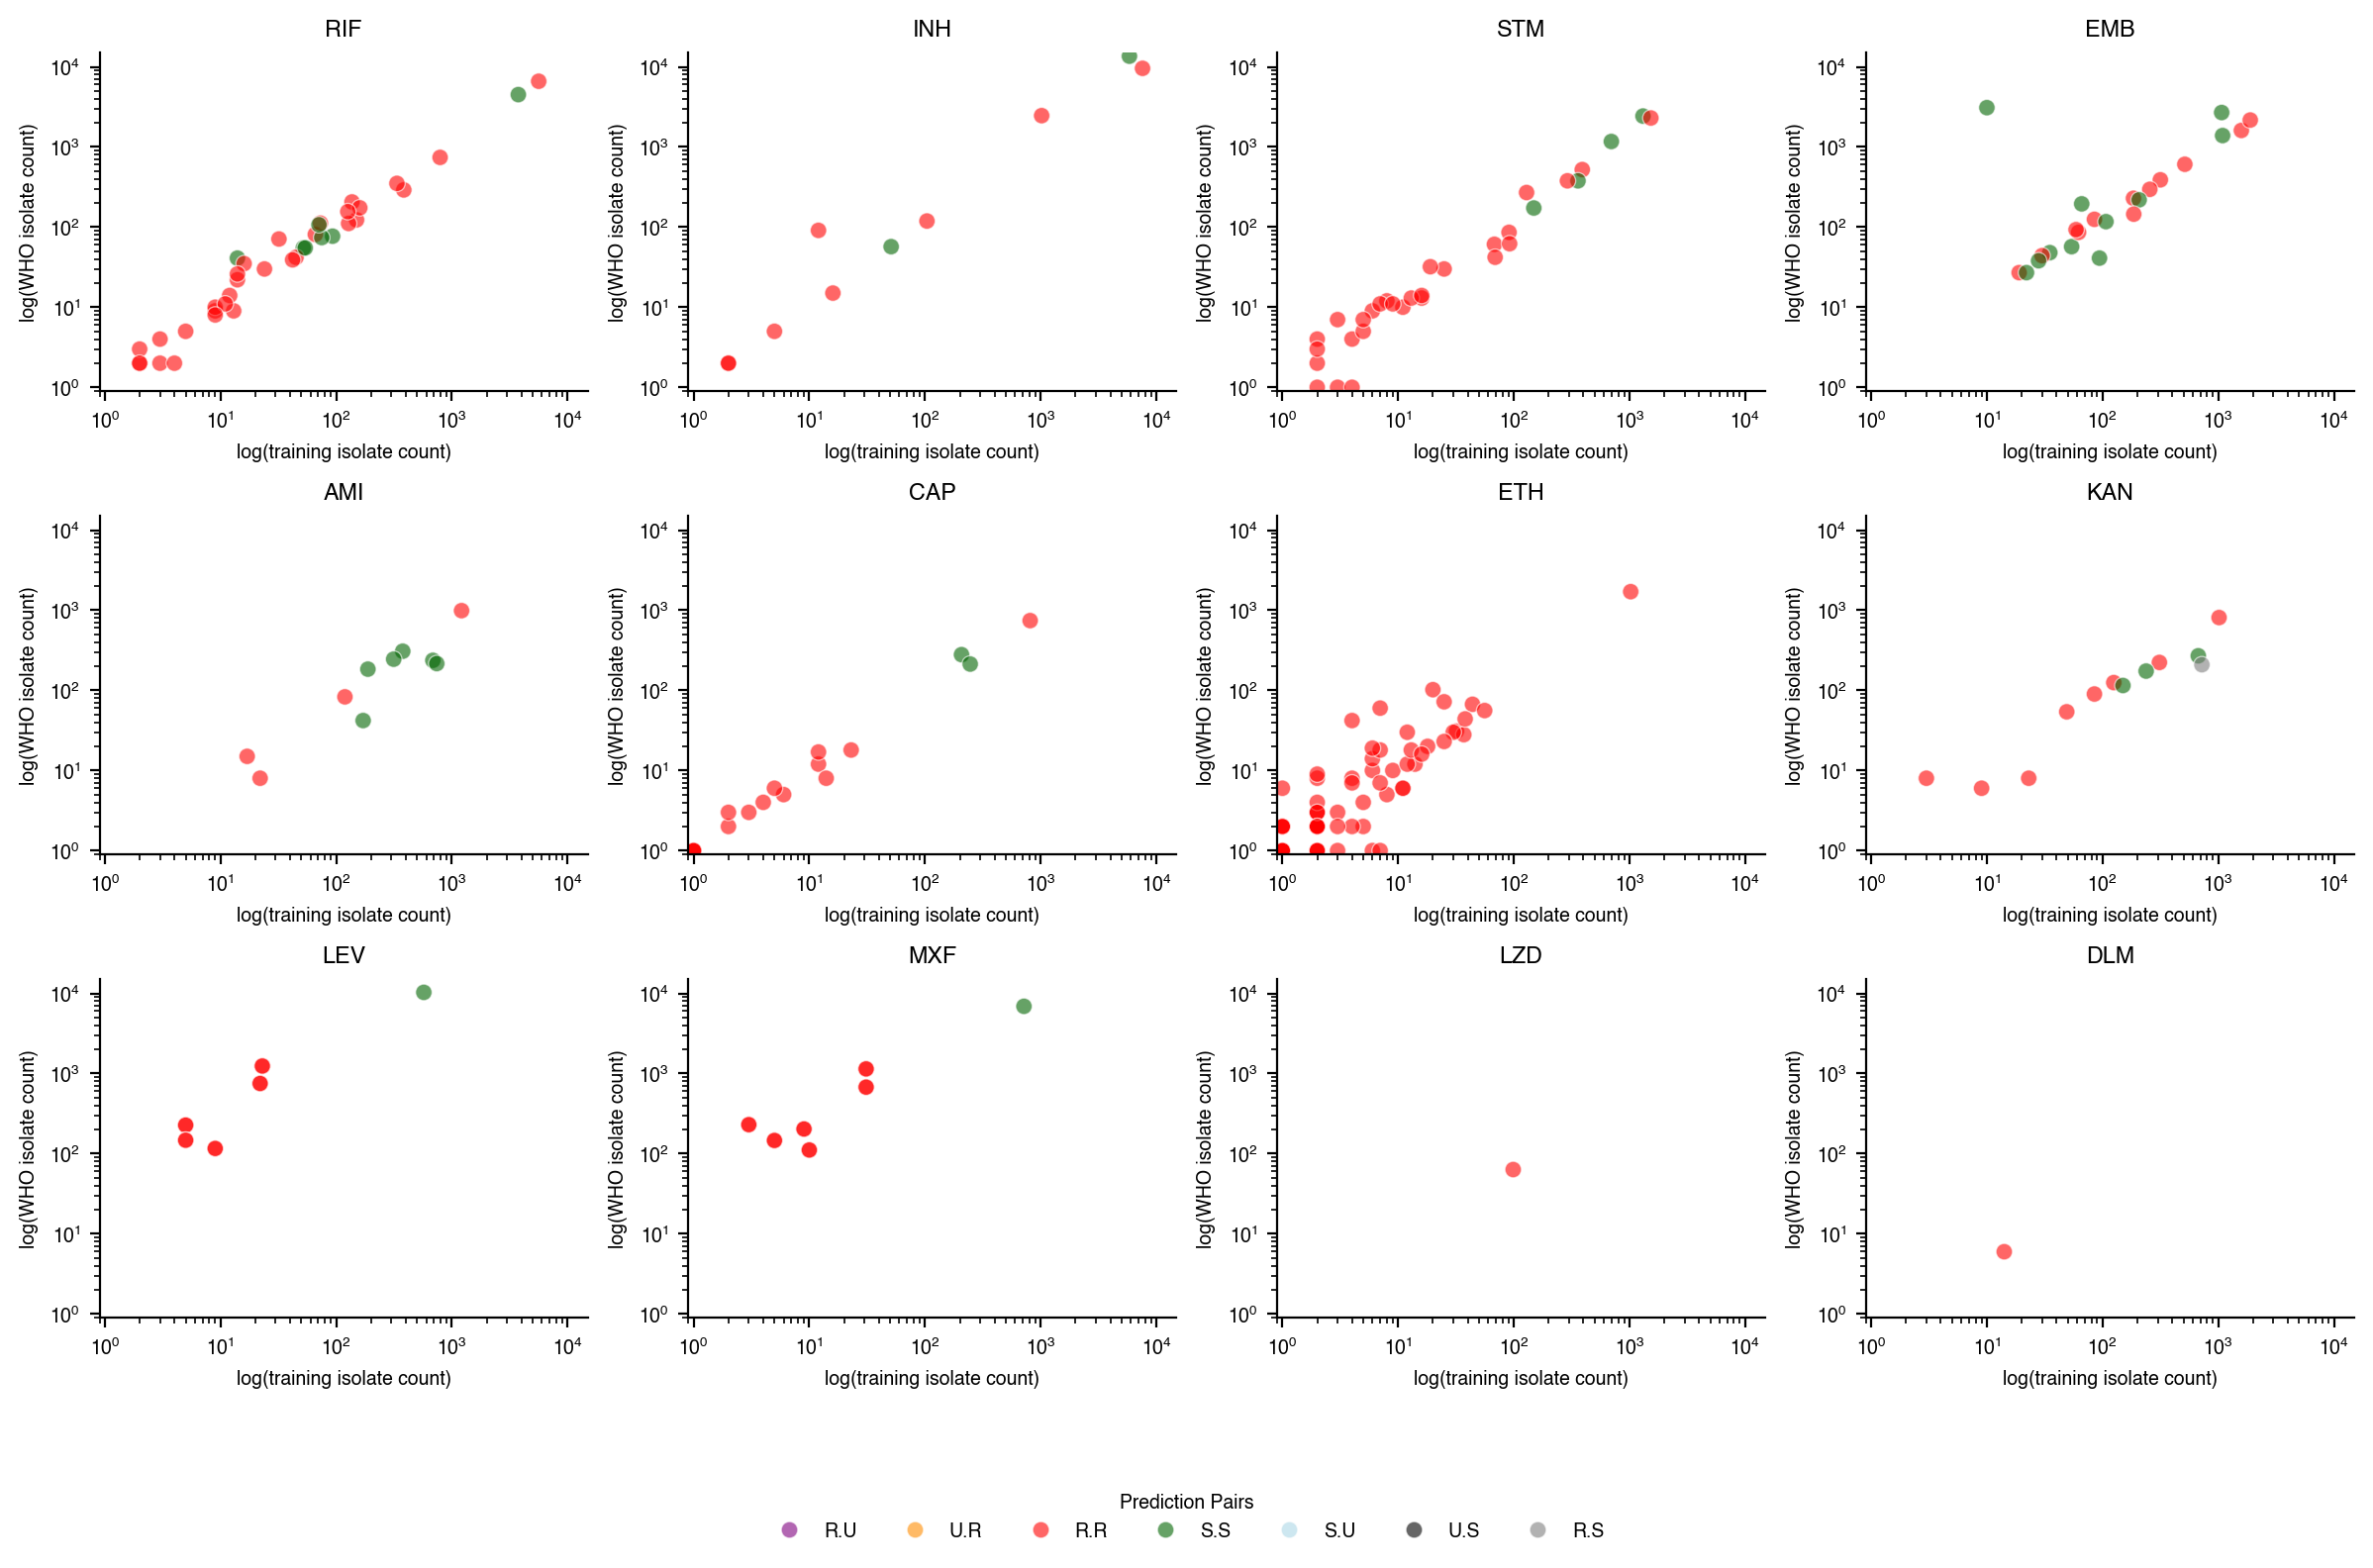

In [55]:
# Define prediction colors
prediction_colors = {
    "R.R": "red", "S.S": "darkgreen", "R.S": "grey", "S.R": "black",
    "U.S": "black", "U.R": "darkorange",
    "S.U": "lightblue", "R.U": "purple",
}
# Filter data and plot
shared = utils.sum_solo_counts(all_drugs_merged[~all_drugs_merged.PREDICTION_PAIR.str.contains('X')])

utils.plot_grid_counts(shared[(shared.EVIDENCE_who != {'expanded_rule'}) & (shared.EVIDENCE_cat != {'expanded_rule'})], valid_drugs, prediction_colors, savefig='figs/discordance/whov1_catomaticv1_shared_counts.pdf')

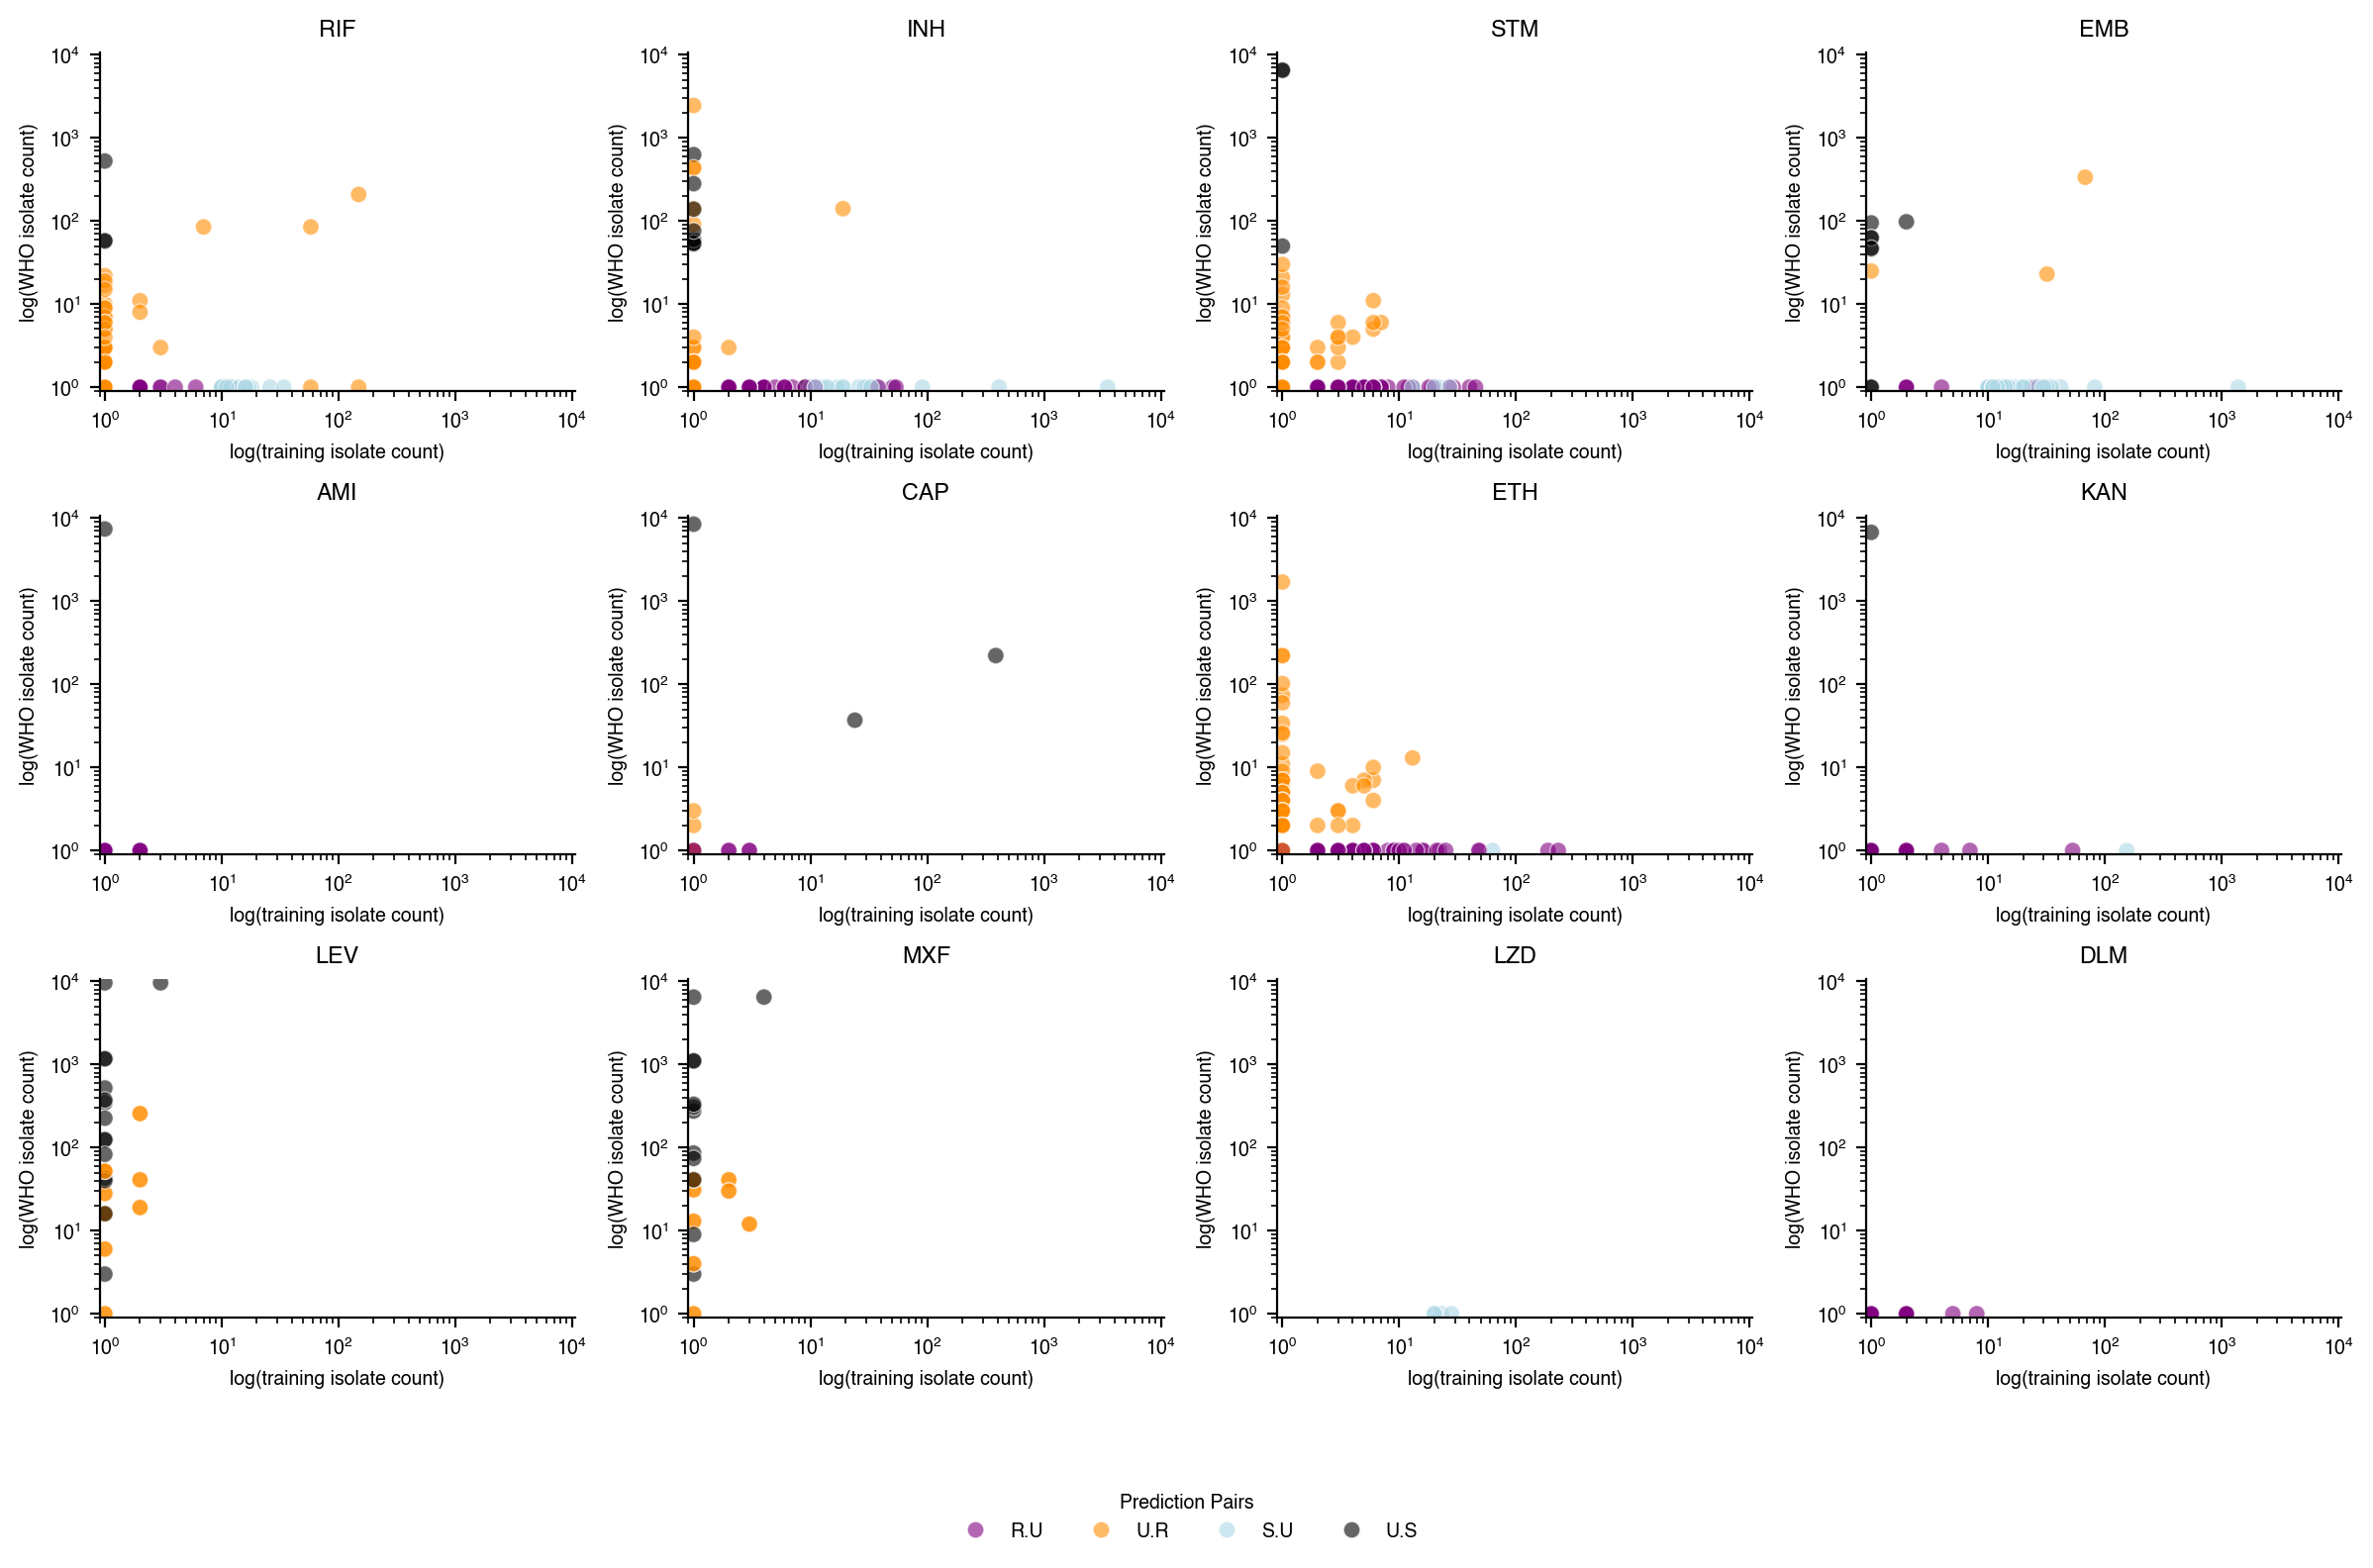

In [56]:
not_shared = utils.sum_solo_counts(all_drugs_merged[all_drugs_merged.PREDICTION_PAIR.str.contains('U')]).reset_index()

def fill_solo_counts(row):
    drug, mutation = row.DRUG, row.MUTATION
    if pd.isna(row.y) and mutation in u_who[u_who.DRUG == drug].MUTATION.values:
        match = u_who[(u_who.DRUG == drug) & (u_who.MUTATION == mutation)]
        row['solo_R_who'], row['solo_S_who'] = match.solo_R.values[0], match.solo_S.values[0]
    if pd.isna(row.x) and mutation in u_cat[u_cat.DRUG == drug].MUTATION.values:
        match = u_cat[(u_cat.DRUG == drug) & (u_cat.MUTATION == mutation)]
        row['solo_R_cat'], row['solo_S_cat'] = match.solo_R.values[0], match.solo_S.values[0]
    return row

not_shared = not_shared.apply(fill_solo_counts, axis=1)
not_shared = utils.sum_solo_counts(not_shared)
not_shared[['x', 'y']] = not_shared[['x', 'y']].fillna(1)

utils.plot_grid_counts(not_shared[(not_shared.EVIDENCE_who != {'expanded_rule'}) & (not_shared.EVIDENCE_cat != {'expanded_rule'})], valid_drugs, prediction_colors, savefig='figs/discordance/whov1_catomaticv1_nonshared_counts.pdf')


## catomatic_v1 vs WHOv1 vs catomatic_v3 vs WHOv2 on crypticv3

Since WHOv1 and the first set of cryptic tables were released, more data has been accumulated. Training on this additional data could potentially boost our catalogue's performance, however we can't fairly compare its performance to either WHO catalogues as it would be trained on different data.

But we can compare all catalogues on an independent validation set, even if their training sets are different, as a fair performance benchmark.

#### Build catomatic-v3

As with crypticv1, need to run a parameter grid search and choose optimal catalogues on crypticv1.

In [31]:
#Generate catomatic catalogue on cryptic v1
grid_results_v3 = parallel_grid_search(
    "data/mutations-v3.1.0/",
    "data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl",
    "data/cryptic-tables-v3.1.0/GENOMES.parquet",
    "data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet",
    "data/cryptic-tables-v3.1.0/MUTATIONS.parquet",
    "data/cryptic-tables-v3.1.0/VARIANTS.parquet",
    "catalogues/cryptic-v3.1.0/grid_search/",
    0.1,
    'v3.1.0',
    'v3.0',
    cores=10 #best to run with 1 core when first generating mutations and variants tables, as mem requirements are steep!!
)

OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILEOUTFILE  catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.15_p_0.9_FRS_0.1.csvcatalogues/cryptic-v3.1.0/grid_search//cip/bg_0.25_p_0.9_FRS_0.1.csv

OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.05_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v3.1.0/grid_search//cap/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cap/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//ami/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//ami/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.2_p_0.95_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.1_p_0.95_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//ami/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.1_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cip/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.25_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.15_p_0.9_FRS_0.1.csv


/Users/dylanadlard/Documents/Oxford/PhD/Projects/cryptic-catalogues-2025/protocols/utils.py:235: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])


OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cap/bg_0.1_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cap/bg_0.2_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//dlm/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//ami/bg_0.05_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//ami/bg_0.15_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//ami/bg_0.25_p_0.95_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//eth/bg_0.1_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//eth/bg_0.2_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//emb/bg_0.05_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//emb/bg_0.15_p_0.9_FRS_0.1.csv
OUTFILE catalogues/cryptic-v3.1.0/grid_search//cap/bg_0.15_p_0.9_FRS_0.1

In [32]:
df = utils.flatten_grid_results(grid_results_v3)

opt_cats_v3 = utils.weighted_score(df).groupby("DRUG").head(1).reset_index(drop=True)
cat_counts = pd.DataFrame([
    {
        "DRUG": opt_cats_v3['DRUG'][i],
        "R": cat["PREDICTION"].value_counts().get("R", 0),
        "S": cat["PREDICTION"].value_counts().get("S", 0),
        "U": cat["PREDICTION"].value_counts().get("U", 0),
        "Total": len(cat)
    }
    for i in opt_cats_v3.index
    for cat in [pd.read_csv(f"./catalogues/cryptic-v3.1.0/grid_search/{opt_cats_v3['DRUG'][i].lower()}/bg_{opt_cats_v3['BACKGROUND_RATE'][i]}_p_{opt_cats_v3['p_value'][i]}_FRS_0.1.csv")]
])

opt_cats_v3 = pd.merge(opt_cats_v3, cat_counts, on='DRUG')
opt_cats_v3['catalogue'] = 'catomatic_v3'
opt_cats_v3

DRUG  BACKGROUND_RATE  p_value  SENSITIVITY  SPECIFICITY  COVERAGE  \
0   RIF             0.25     0.90     0.960991     0.981641  0.972014   
1   INH             0.25     0.90     0.946128     0.984747  0.960012   
2   STM             0.25     0.90     0.951566     0.933720  0.894246   
3   MXF             0.25     0.90     0.944738     0.918924  0.877769   
4   EMB             0.20     0.90     0.944436     0.896771  0.906662   
5   AMI             0.05     0.90     0.855944     0.983055  0.925393   
6   KAN             0.25     0.90     0.823952     0.975143  0.961610   
7   CAP             0.05     0.90     0.839443     0.973390  0.906064   
8   ETH             0.10     0.90     0.886343     0.893107  0.890084   
9   LEV             0.25     0.95     0.987962     0.724138  0.212541   
10  CIP             0.20     0.95     0.727273     0.953488  0.053571   
11  LZD             0.05     0.95     0.303523     0.997728  0.991295   
12  DLM             0.05     0.90     0.165957     0.998941  0.991661   

       Score    R   S     U  Total     catalogue  
0   0.969391   45  26   384    455  catomatic_v3  
1   0.960491   82  28   688    798  catomatic_v3  
2   0.934748   76  13   558    647  catomatic_v3  
3   0.923600   12  23   463    498  catomatic_v3  
4   0.922582   20  45  1141   1206  catomatic_v3  
5   0.907967   13   8   463    484  catomatic_v3  
6   0.896841    8  23   466    497  catomatic_v3  
7   0.892951   59   3   286    348  catomatic_v3  
8   0.889120  162   5   655    822  catomatic_v3  
9   0.753731    6   4    89     99  catomatic_v3  
10  0.660397    2   2     9     13  catomatic_v3  
11  0.649339    2   1    51     54  catomatic_v3  
12  0.580993   20   1    59     80  catomatic_v3

### Generate validation samples

In [33]:
crypticv3 = pd.read_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet').reset_index()
validation_ids = crypticv3[(crypticv3.dataset=='CRyPTIC-v3.0')&(crypticv3.in_final_tables)].UNIQUEID.unique()
validation_ids_theory = crypticv3[(crypticv3.dataset=='CRyPTIC-v3.0')].UNIQUEID.unique()

print ('Number of matched validation samples:', len(validation_ids))
print ('Number of validation phenotypes:', len(validation_ids_theory))


Number of matched validation samples: 5827
Number of validation phenotypes: 8896


In [34]:
def process_performance(args):
    drug, genes, opt_cats_v1, validation = args
    FRS = 0.1
    results = []
    catalogues = {
        'WHOv1': 'catalogues/whov1/NC_000962.3_WHO-UCN-GTB-PCI-2021.7_v1.0_GARC1_RUS_corrected.csv',
        'WHOv2': 'catalogues/whov2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv',
        'catomatic_v1': f"./catalogues/cryptic-v1/grid_search/{drug.lower()}/bg_{opt_cats_v1.loc[opt_cats_v1.DRUG == drug, 'BACKGROUND_RATE'].iloc[0]}_p_{opt_cats_v1.loc[opt_cats_v1.DRUG == drug, 'p_value'].iloc[0]}_FRS_0.1.csv",
        'catomatic_v3': f"./catalogues/cryptic-v3.1.0/grid_search/{drug.lower()}/bg_{opt_cats_v3.loc[opt_cats_v3.DRUG == drug, 'BACKGROUND_RATE'].iloc[0]}_p_{opt_cats_v3.loc[opt_cats_v3.DRUG == drug, 'p_value'].iloc[0]}_FRS_0.1.csv",
    }

    if drug in pd.read_csv(catalogues['WHOv2'])['DRUG'].unique():
        mutations = prep_mutations('data/mutations-v3.1.0/', drug_genes[drug], version='v3.1.0', mut_path='data/cryptic-tables-v3.1.0/MUTATIONS.parquet', var_path='data/cryptic-tables-v3.1.0/VARIANTS.parquet')
        phenotypes = prep_phenotypes(
            drug,
            'data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl',
            'data/cryptic-tables-v3.1.0/GENOMES.parquet',
            'data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet',
            'v3.0',
            validation=validation
        )
        all_data = pd.merge(phenotypes, mutations[mutations.FRS >= FRS], on=['UNIQUEID'], how='left')
        if len(all_data)>0:
            for name, path in catalogues.items():
                cm, cov, sens, spec, _, _ = utils.piezo_predict(iso_df=all_data, drug=drug, catalogue_file=path, U_to_S=False, Print=False)
                results.append({
                    'DRUG': drug,
                    'catalogue': name,
                    'SENSITIVITY': sens,
                    'SPECIFICITY': spec,
                    'COVERAGE': cov
                })
    return results

def parallel_performance_evaluation(drug_genes, opt_cats_v1, validation=False):
    tasks = [(drug, genes, opt_cats_v1, validation) for drug, genes in drug_genes.items()]
    ctx = mp.get_context("fork")  # Works on Mac/Linux
    num_workers = min(10, len(tasks))  # Don't use more workers than tasks
    with ctx.Pool(num_workers) as pool:
        all_results = pool.map(process_performance, tasks)  # Run in parallel
    results_df = pd.DataFrame([item for sublist in all_results for item in sublist])

    return results_df



## Results comparison on entire dataset

In [35]:
results_all = parallel_performance_evaluation(drug_genes, opt_cats_v1, validation=False)

In [42]:
results_all

DRUG     catalogue  SENSITIVITY  SPECIFICITY  COVERAGE
0   AMI         WHOv1     0.855337     0.983240  0.924877
1   AMI         WHOv2     0.848583     0.983330  0.930073
2   AMI  catomatic_v1     0.856011     0.982962  0.925512
3   AMI  catomatic_v3     0.855944     0.983055  0.925393
4   CAP         WHOv1     0.811852     0.974604  0.954797
5   CAP         WHOv2     0.817855     0.973830  0.955836
6   CAP  catomatic_v1     0.832719     0.974160  0.924408
7   CAP  catomatic_v3     0.839443     0.973390  0.906064
8   DLM         WHOv1     0.053140     0.999801  0.989010
9   DLM         WHOv2     0.121076     0.999603  0.990239
10  DLM  catomatic_v1     0.155172     0.999073  0.991338
11  DLM  catomatic_v3     0.165957     0.998941  0.991661
12  EMB         WHOv1     0.953798     0.885961  0.834180
13  EMB         WHOv2     0.938512     0.895359  0.867529
14  EMB  catomatic_v1     0.942926     0.900039  0.901291
15  EMB  catomatic_v3     0.944436     0.896771  0.906662
16  ETH         WHOv1     0.889537     0.899366  0.853478
17  ETH         WHOv2     0.885714     0.895498  0.851258
18  ETH  catomatic_v1     0.896532     0.865430  0.895807
19  ETH  catomatic_v3     0.886343     0.893107  0.890084
20  INH         WHOv1     0.941566     0.986293  0.947072
21  INH         WHOv2     0.942069     0.985185  0.950808
22  INH  catomatic_v1     0.945209     0.985802  0.961587
23  INH  catomatic_v3     0.945534     0.984924  0.966920
24  KAN         WHOv1     0.825199     0.974491  0.939643
25  KAN         WHOv2     0.825511     0.974292  0.933190
26  KAN  catomatic_v1     0.847274     0.932230  0.953171
27  KAN  catomatic_v3     0.823952     0.975143  0.961610
28  LEV         WHOv1     0.910928     0.969521  0.923389
29  LEV         WHOv2     0.911590     0.968228  0.925928
30  LEV  catomatic_v1     0.986910     0.746702  0.198089
31  LEV  catomatic_v3     0.987962     0.724138  0.212541
32  LZD         WHOv1     0.301630     0.997728  0.991247
33  LZD         WHOv2     0.301630     0.997728  0.991247
34  LZD  catomatic_v1     0.300813     0.997739  0.996297
35  LZD  catomatic_v3     0.303523     0.997728  0.991295
36  MXF         WHOv1     0.940558     0.919249  0.911663
37  MXF         WHOv2     0.940401     0.918650  0.922516
38  MXF  catomatic_v1     0.990488     0.453397  0.247087
39  MXF  catomatic_v3     0.944738     0.918924  0.877769
40  RIF         WHOv1     0.961864     0.970078  0.979411
41  RIF         WHOv2     0.962197     0.969986  0.977291
42  RIF  catomatic_v1     0.960879     0.981634  0.971405
43  RIF  catomatic_v3     0.960991     0.981641  0.972014
44  STM         WHOv1     0.949090     0.937639  0.860561
45  STM         WHOv2     0.948834     0.939259  0.858176
46  STM  catomatic_v1     0.953264     0.922193  0.903932
47  STM  catomatic_v3     0.951566     0.933720  0.894246

/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


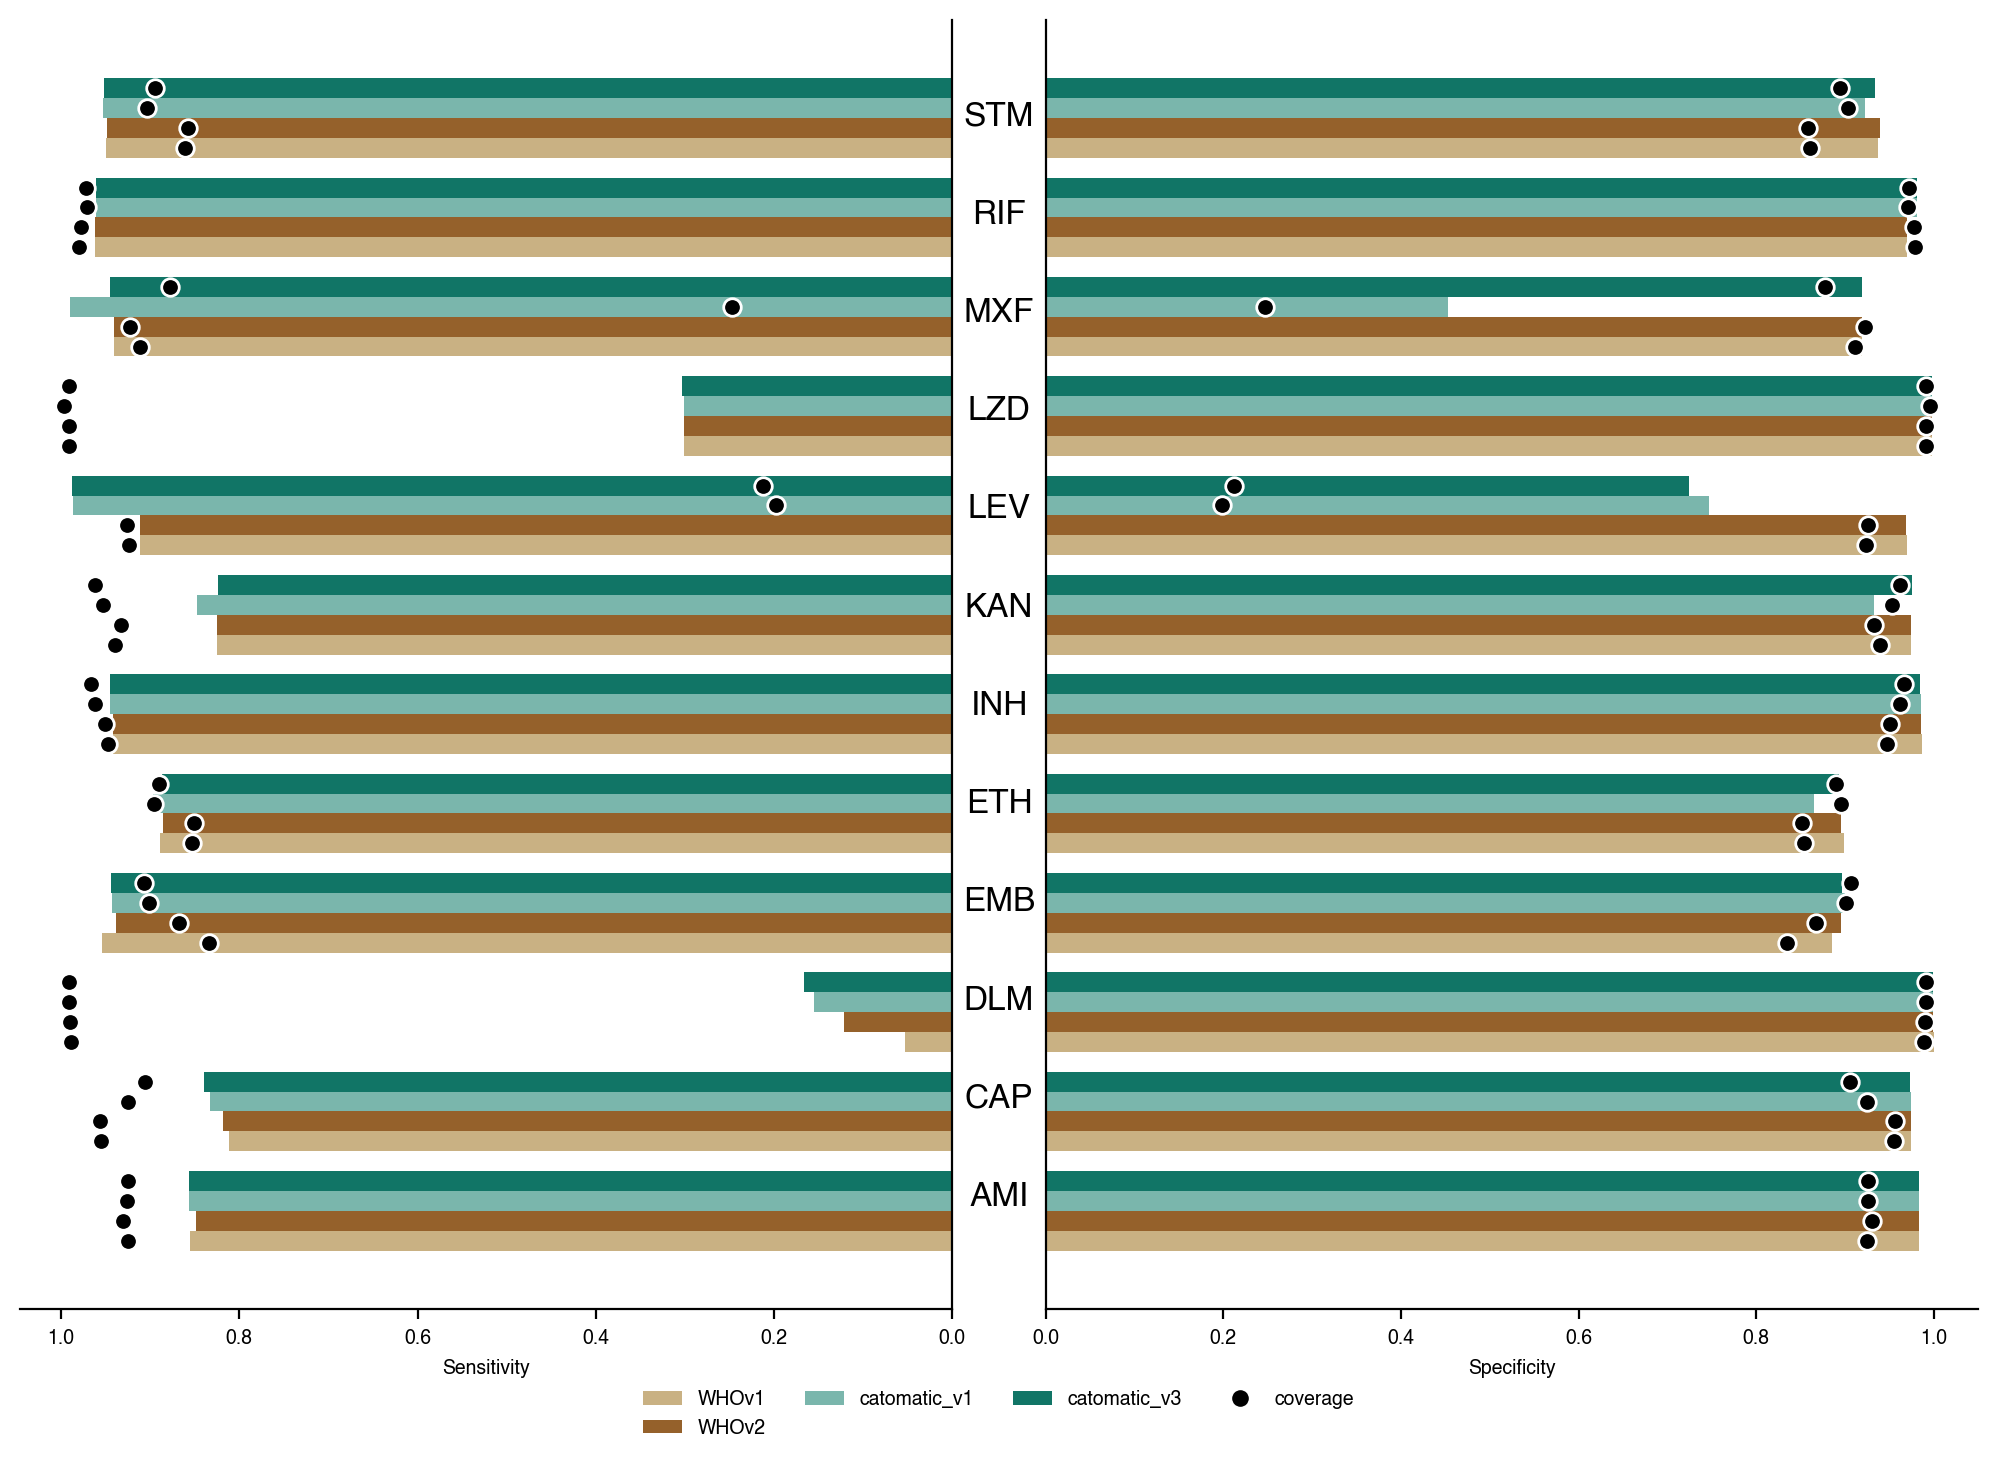

In [43]:
utils.back2back_sens_spec(results_all.sort_values(by=['DRUG', 'catalogue']), palette=catalogue_palette, savefig='figs/performance/whov1_whov2_catomaticv1_catomativ3.pdf'
)

## Results comparison on validation set

In [37]:
results_val = parallel_performance_evaluation(drug_genes, opt_cats_v1, validation=True)

/Users/dylanadlard/miniforge3/envs/cryptic-catalogues-25/lib/python3.13/site-packages/seaborn/categorical.py:383: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(n - .5, -.5, auto=None)


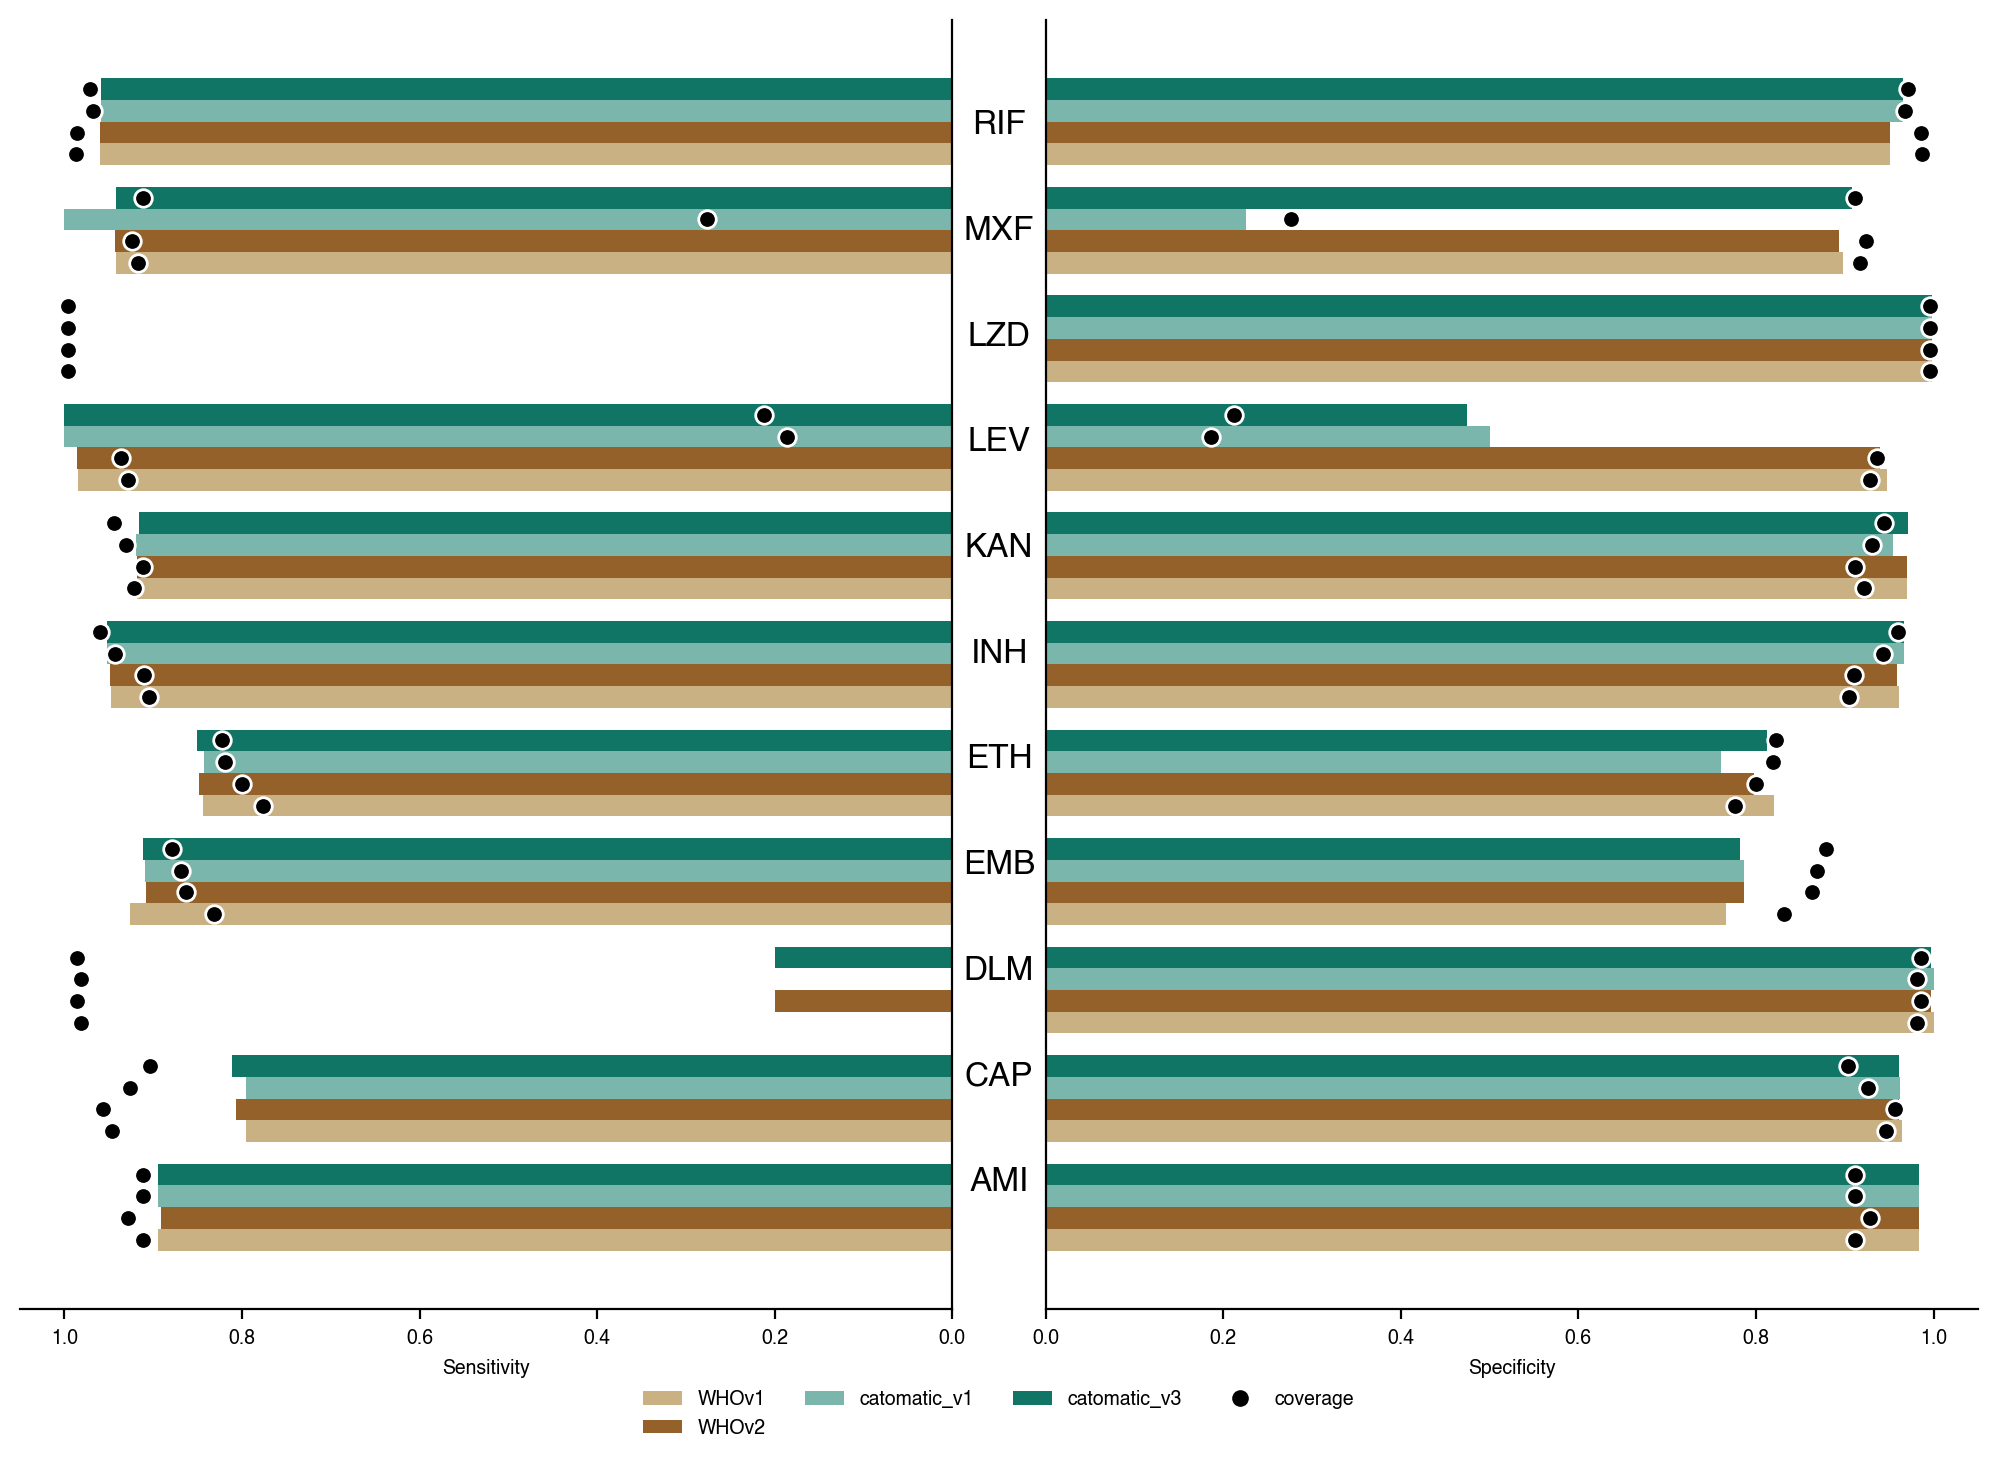

In [44]:
utils.back2back_sens_spec(results_val.sort_values(by=['DRUG', 'catalogue']), palette=catalogue_palette, savefig='figs/performance/whov1_whov2_catomaticv1_catomativ3_val.pdf')

## Discordance analysis between catomatic_v1 and catomatic_v3

In [58]:
valid_drugs = opt_cats_v1.DRUG.unique()

cats_v1 = opt_cats_v1.apply(
    lambda row: utils.load_catomatic_catalogue(
        drug=row['DRUG'], 
        background=row['BACKGROUND_RATE'], 
        p=row['p_value'], 
        frs=0.1,  # Assuming FRS is fixed at 0.1
        dir="./catalogues/cryptic-v1/grid_search/"
    ), 
    axis=1
).tolist()

cat_v1 = pd.concat(cats_v1, ignore_index=True)
cat_v1['solo_R'] = cat_v1['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 0))
cat_v1['solo_S'] = cat_v1['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 1))
u_cat_v1 = cat_v1[~cat_v1.PREDICTION.isin(['R', 'S'])]
cat_v1 = cat_v1[cat_v1.PREDICTION.isin(['R', 'S'])]

cats_v3 = opt_cats_v3.apply(
    lambda row: utils.load_catomatic_catalogue(
        drug=row['DRUG'], 
        background=row['BACKGROUND_RATE'], 
        p=row['p_value'], 
        frs=0.1,  # Assuming FRS is fixed at 0.1
        dir="./catalogues/cryptic-v3.1.0/grid_search/"
    ), 
    axis=1
).tolist()

# Concatenate all loaded catalogues into one big DataFrame
cat_v3 = pd.concat(cats_v3, ignore_index=True)
cat_v3['solo_R'] = cat_v3['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 0))
cat_v3['solo_S'] = cat_v3['EVIDENCE'].apply(lambda x: utils.extract_value(x, 'contingency', 0, 1))
u_cat_v3 = cat_v3[~cat_v3.PREDICTION.isin(['R', 'S'])]
cat_v3 = cat_v3[cat_v3.PREDICTION.isin(['R', 'S'])]

expanded_catalogues = utils.expand_catalogue_pair(cat_v1, cat_v3, valid_drugs, 'RUS', ('cat_v1', 'cat_v3'))

all_drugs_merged = pd.concat(expanded_catalogues[drug]['merged'] for drug in valid_drugs)
suffixes = ('cat_v1', 'cat_v3')
all_drugs_merged['PREDICTION_PAIR'] = all_drugs_merged.apply(utils.classify_predictions, axis=1, args=(suffixes,))
all_drugs_merged['DRUG'] = all_drugs_merged['DRUG_cat_v1'].combine_first(all_drugs_merged['DRUG_cat_v3'])

summary_table = (
    all_drugs_merged.drop_duplicates(['DRUG', 'MUTATION']).groupby(['DRUG', 'PREDICTION_PAIR'])
    .size()
    .unstack(fill_value=0)  
    .reset_index() 
)

summary_table.rename(columns={'DRUG': 'DRUG'}, inplace=True)
summary_table['total'] = summary_table.drop(columns=['DRUG']).sum(axis=1)
summary_table.columns.name = None

print ('Prediction pairs comparing catomatic_v1 with catomatic_v3, including rules:')
summary_table

Prediction pairs comparing catomatic_v1 with catomatic_v3, including rules:


DRUG  R.R  R.S  R.U  S.S  S.U  U.R  U.S  total
0   AMI   13    0    1    6    0    0    0     20
1   CAP   41    0    2    1    1   18    0     63
2   CIP    2    0    0    1    0    0    0      3
3   DLM   17    0    0    0    0    3    0     20
4   EMB   15    0    2   38   13    5    5     78
5   ETH  135    0  160    1    0   27    1    324
6   INH   59    0    1   20    0   23    5    108
7   KAN    8    1   14    4    0    0   16     43
8   LEV    5    0    0    1    0    1    1      8
9   LZD    1    0    0    0    4    1    0      6
10  MXF    6    0    0    1    0    6   20     33
11  RIF   40    0    1   23    1    5    2     72
12  STM   70    0   19    9    0    6    1    105

In [59]:
shared = utils.sum_solo_counts(all_drugs_merged[~all_drugs_merged.PREDICTION_PAIR.str.contains('X')], suffixes=['cat_v1', 'cat_v3'])
not_shared = utils.sum_solo_counts(all_drugs_merged[all_drugs_merged.PREDICTION_PAIR.str.contains('X')], suffixes=['cat_v1', 'cat_v3'])

def fill_solo_counts(row):
    drug, mutation = row.DRUG, row.MUTATION
    if pd.isna(row.y) and mutation in u_cat_v1[u_cat_v1.DRUG == drug].MUTATION.values:
        match = u_cat_v1[(u_cat_v1.DRUG == drug) & (u_cat_v1.MUTATION == mutation)]
        row['solo_R_v1'], row['solo_S_v1'] = match.solo_R.values[0], match.solo_S.values[0]
    if pd.isna(row.x) and mutation in u_cat_v3[u_cat_v3.DRUG == drug].MUTATION.values:
        match = u_cat_v3[(u_cat_v3.DRUG == drug) & (u_cat_v3.MUTATION == mutation)]
        row['solo_R_v3'], row['solo_S_v3'] = match.solo_R.values[0], match.solo_S.values[0]
    return row

not_shared = not_shared.apply(fill_solo_counts, axis=1)
not_shared = utils.sum_solo_counts(not_shared, suffixes=['cat_v1', 'cat_v3'])
not_shared[['x', 'y']] = not_shared[['x', 'y']].fillna(1)


Can filter shared and not_shared to find matched and unmatched mutations.

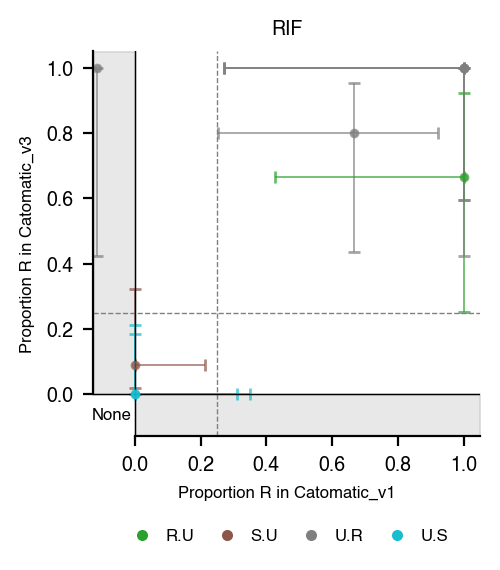

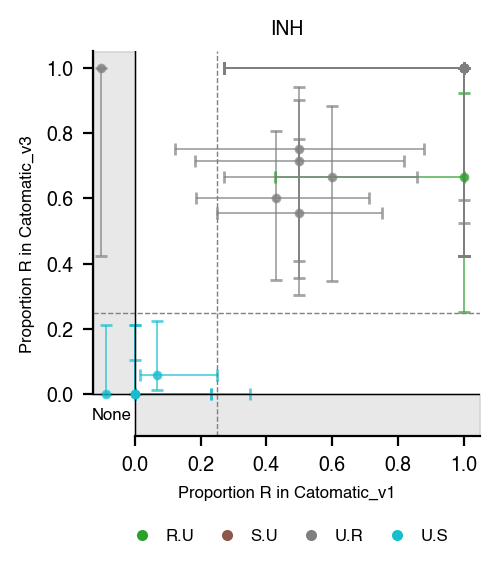

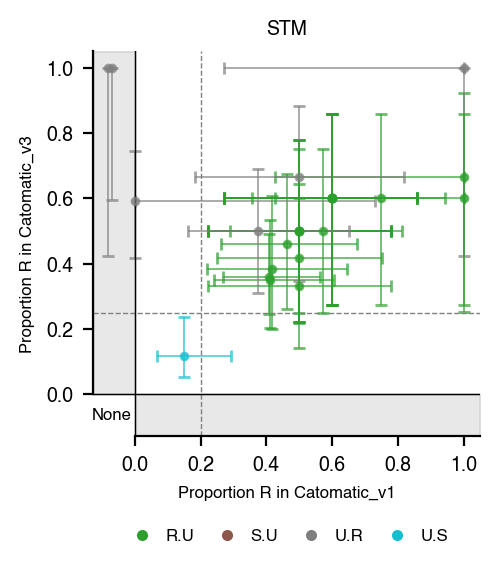

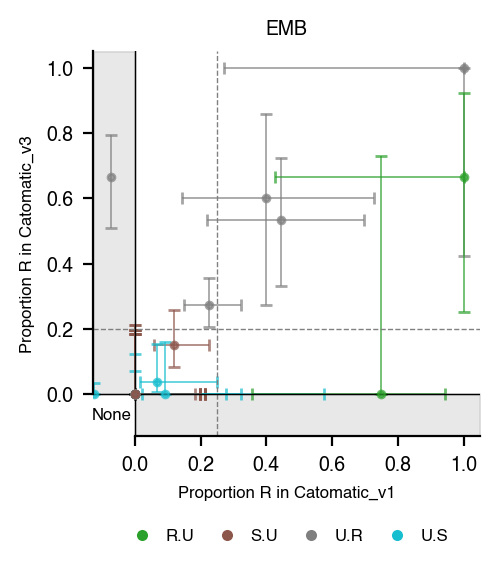

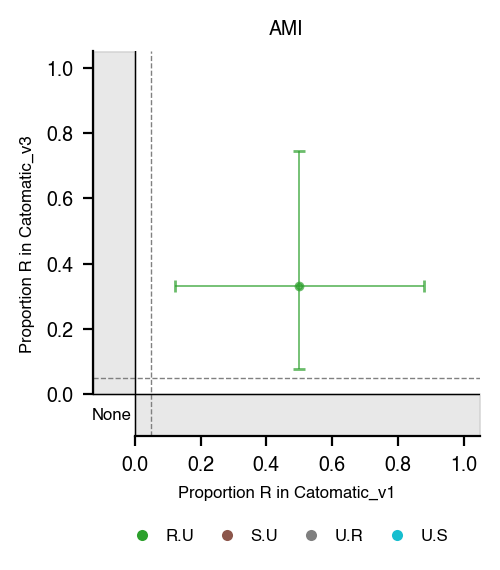

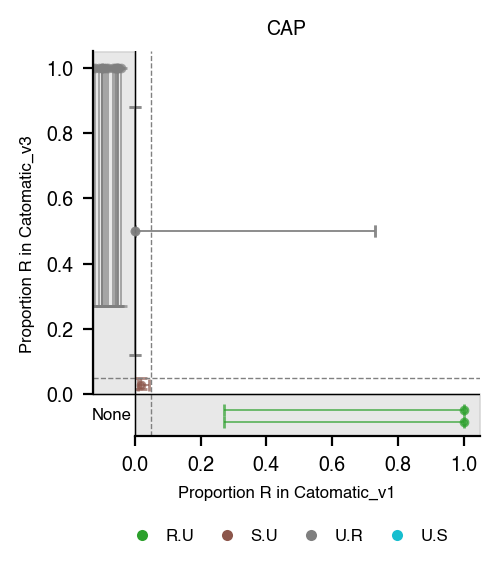

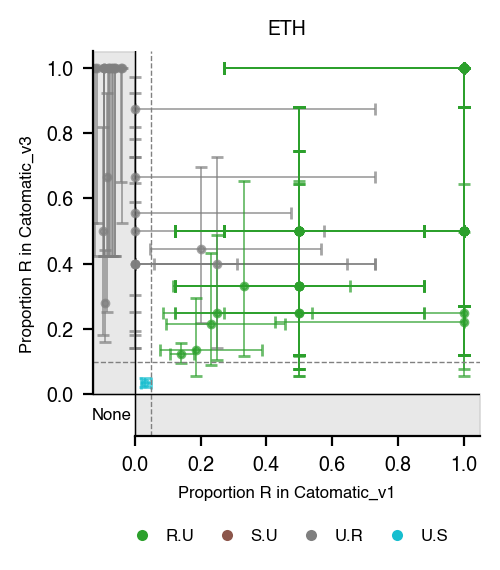

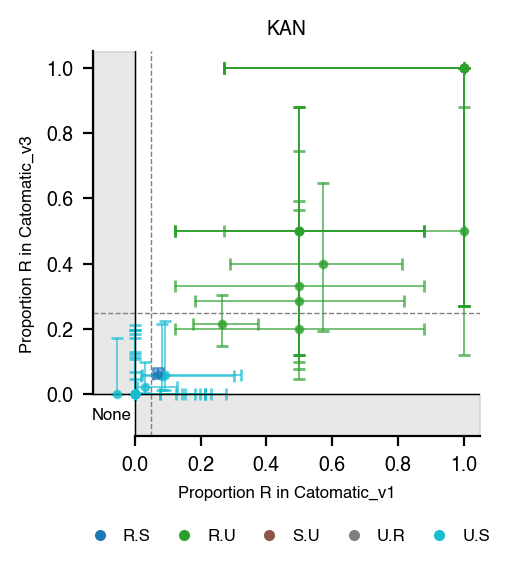

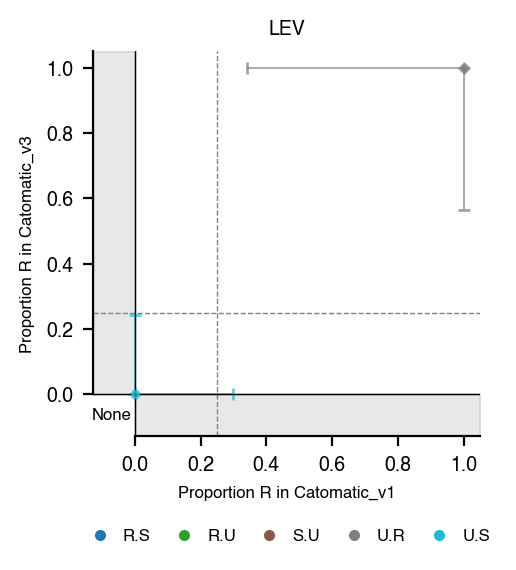

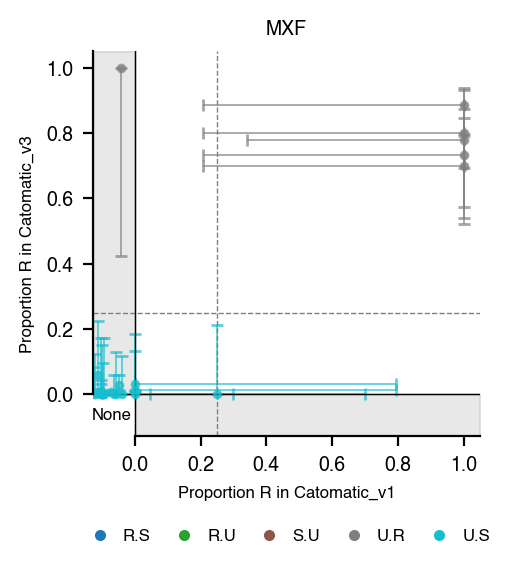

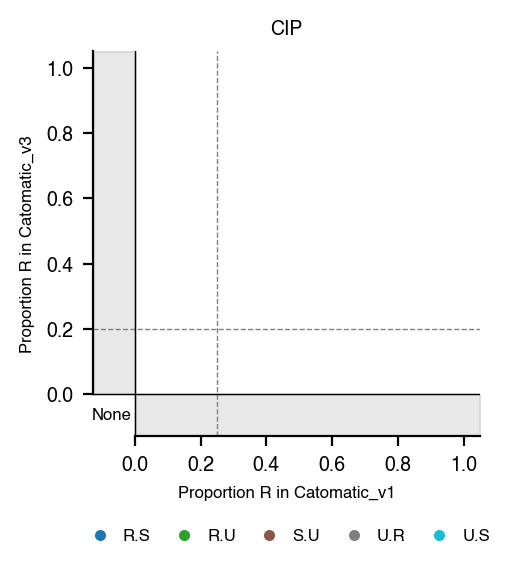

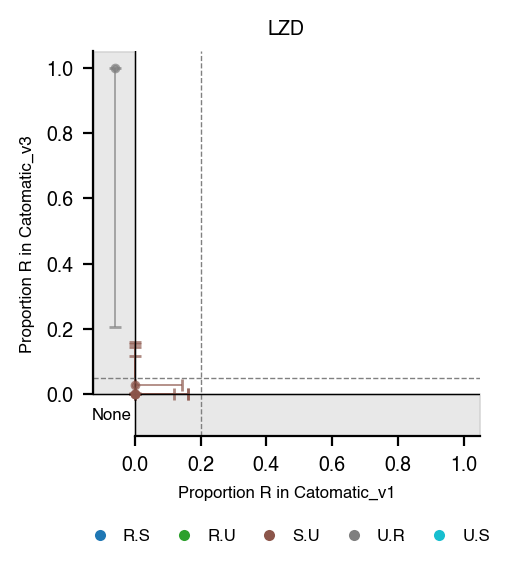

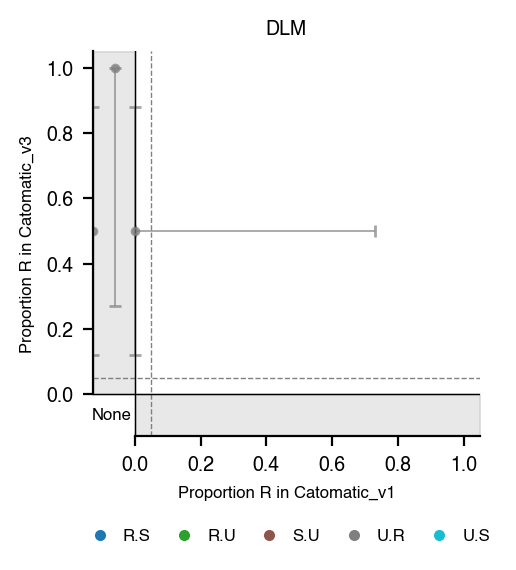

In [60]:
twoD_prop_data, oneD_prop_data = {}, {}
for drug in opt_cats_v1.DRUG:
    v1_background, v1_p = opt_cats_v1.loc[opt_cats_v1.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]
    v3_background, v3_p = opt_cats_v3.loc[opt_cats_v3.DRUG == drug, ['BACKGROUND_RATE', 'p_value']].iloc[0]
    
    #change v3 to v1 (or vice versa) for cat2 to compare cataogues built with same parameters
    cat1, cat2 = utils.load_catomatic_catalogue(drug, v1_background, v1_p, 0.1, dir='./catalogues/cryptic-v1/grid_search/'), utils.load_catomatic_catalogue(drug, v3_background, v3_p, 0.1, dir='./catalogues/cryptic-v3.1.0/grid_search/')

    df, merged_cats = utils.expand_and_classify_cats(cat1, cat2, drug)
    df = df[df.PREDICTION_PAIR.isin(['R.S', 'S.R', 'R.U', 'S.U', 'U.R', 'U.S'])].reset_index()

    #also pull out rows that only exist in 1 catalogue - these become the oneD data 
    df_1_prop = merged_cats[(pd.isna(merged_cats[['PROPORTION_cat1', 'PROPORTION_cat2', 'CONFIDENCE_cat1', 'CONFIDENCE_cat2']]).any(axis=1))&(merged_cats.PREDICTION_PAIR.isin(['R.U', 'S.U', 'U.R', 'U.S']))]

    x, y, xerr, yerr = utils.extract_errors(df, 'PROPORTION', 'CONFIDENCE')
    x_1_prop, y_1_prop, xerr_1_prop, yerr_1_prop = utils.extract_errors(df_1_prop, 'PROPORTION', 'CONFIDENCE')
    
    twoD_prop_data[drug] = {'x': x, 'y': y, 'xerr': xerr, 'yerr': yerr, 'categories': df['PREDICTION_PAIR'].values, 'background_1': v1_background,'background_2': v3_background, 'mutations':df['MUTATION'].values}
    oneD_prop_data[drug] = {'x': x_1_prop, 'y': y_1_prop, 'xerr': xerr_1_prop, 'yerr': yerr_1_prop, 'categories': df_1_prop['PREDICTION_PAIR'].values, 'background_1': v1_background,'background_2': v3_background, 'mutations':df_1_prop['MUTATION'].values}

utils.plot_cat_comp_proportions(twoD_prop_data, oneD_prop_data, ax_labels={'x':'Catomatic_v1', 'y':'Catomatic_v3'}, figpath='figs/discordance/catv1_catv3_') 